In [1]:
import os
os.chdir("..")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.models import MDN
from utils.data_module import RothfussDataModule, VoestDataModule, SyntheticDataModule, TrainingDataModule
from utils.train import train_model
from utils.evaluation_functions import make_to_pass_precomputed_variables
from tqdm import tqdm
import yaml
from torch.utils.tensorboard import SummaryWriter
import wandb
import matplotlib
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

2024-02-18 22:26:56.641302: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 22:26:56.641352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 22:26:56.642511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 22:26:56.648960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 22:26:57.450350: W tensorflow/compiler/tf2

{'a/b/c': 1, 'a/b/d': 2, 'a/e': 3, 'f': 4}


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/alexander/miniconda3/envs/uncertainty_prediction/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [14]:
with open("configs/dummy_config_synthetic.yml", "r") as f:
        true_config = yaml.safe_load(f)

In [15]:
training_hyperparameters = true_config["training_hyperparameters"]
model_hyperparameters = true_config["model_hyperparameters"]

In [16]:
dm = SyntheticDataModule("datasets/simulated_data/gmm_2_10000/gmm_2_10000")
#dm = RothfussDataModule(dataset_name="concrete", data_path="datasets/rothfuss_datasets/", pre_normalize_mean_absolute_response=True, validation_is_test=True)
#dm = VoestDataModule(data_path= "datasets/voest_datasets/", original= False)

if not dm.has_distribution():
    training_hyperparameters["evaluation_function_names"] = []

training_dm = TrainingDataModule(dm.train_dataset, dm.val_dataset)
model = MDN(training_dm, **model_hyperparameters).to(device)
summary_writer = SummaryWriter(
        os.path.join("runs", "test_project")
    )
wandb.init(
        project="project_name",
        config=true_config,
        name="run_name",
        group="group_name",
        dir=os.path.join("runs", "project_name"),
        mode="disabled",
    )

In [17]:
best_params, val_metrics = train_model(
    model,
    training_dm,
    **training_hyperparameters,
    device=device,
    summary_writer=summary_writer
)

val_nll_loss: 2.490553186416626:  20%|██        | 30/150 [00:23<01:32,  1.30it/s] 

Early stopping


In [8]:
val_metrics

{'val_mean_weights': 0.05000000074505806,
 'val_std_weights': 0.1113061974644661,
 'val_mean_mu': 0.02965839856863022,
 'val_std_mu': 4.374927768707275,
 'val_mean_sigma': 2.3194389514923097,
 'val_std_sigma': 1.6440580053329468,
 'val_nll_loss': 2.4286150817871093,
 'val_nll_loss_normalized': 0.8825722818374634,
 'val_weights_entropy': 1.5853219060897827,
 'val_misclibration_area': 0.043826731860637666,
 'val_hellinger_distance': 0.344156748149544,
 'val_wasserstein_distance': 0.5150815858699692,
 'val_kl_divergence': 1.186741403459261,
 'val_epoch': 38}

In [8]:
model.load_state_dict(best_params)

<All keys matched successfully>

In [22]:
finer_factor = 10
conformal_p = 0.90
has_true_distribution = dm.has_distribution()
draw_plot = False
only_one_batch = False

In [23]:
%matplotlib inline

  2%|▏         | 2/84 [00:00<00:13,  5.87it/s]

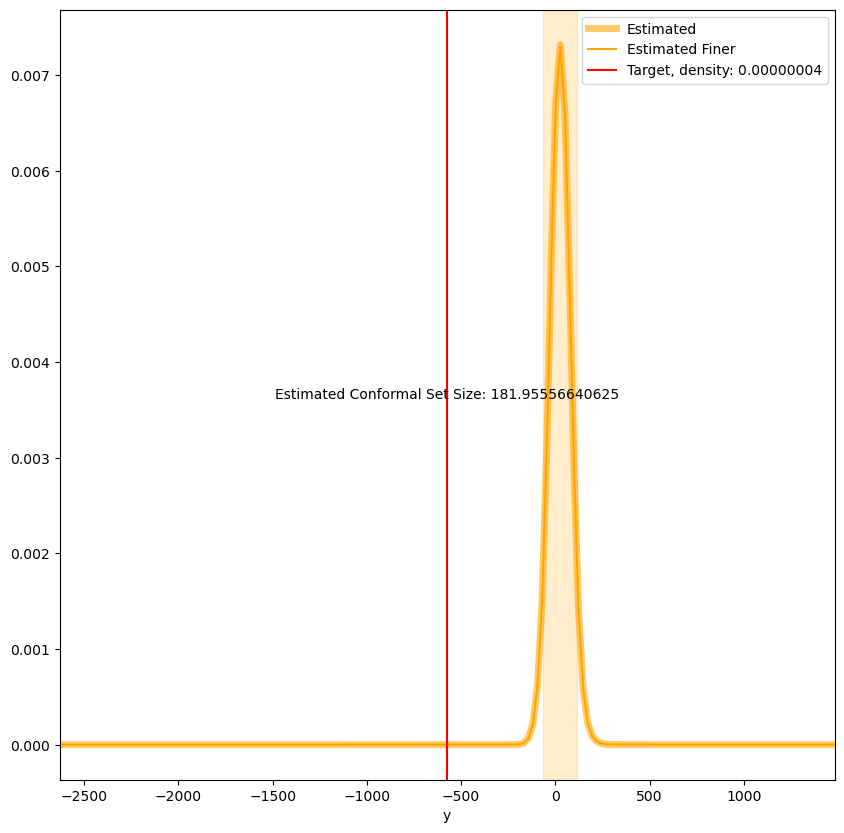

  5%|▍         | 4/84 [00:01<00:24,  3.32it/s]

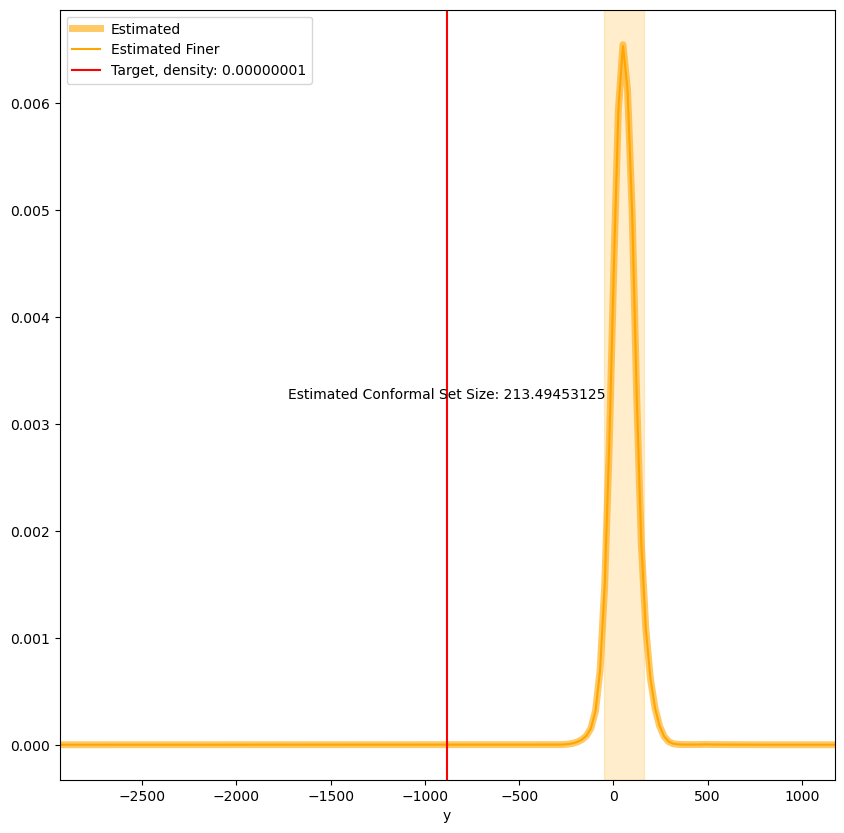

  6%|▌         | 5/84 [00:01<00:32,  2.47it/s]

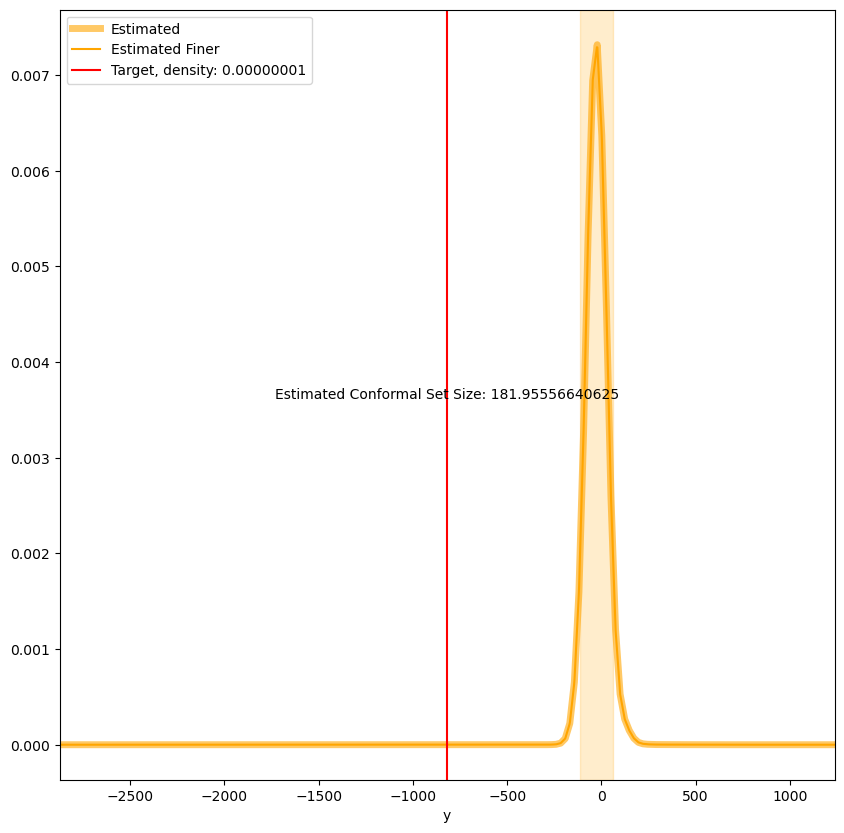

  7%|▋         | 6/84 [00:02<00:32,  2.40it/s]

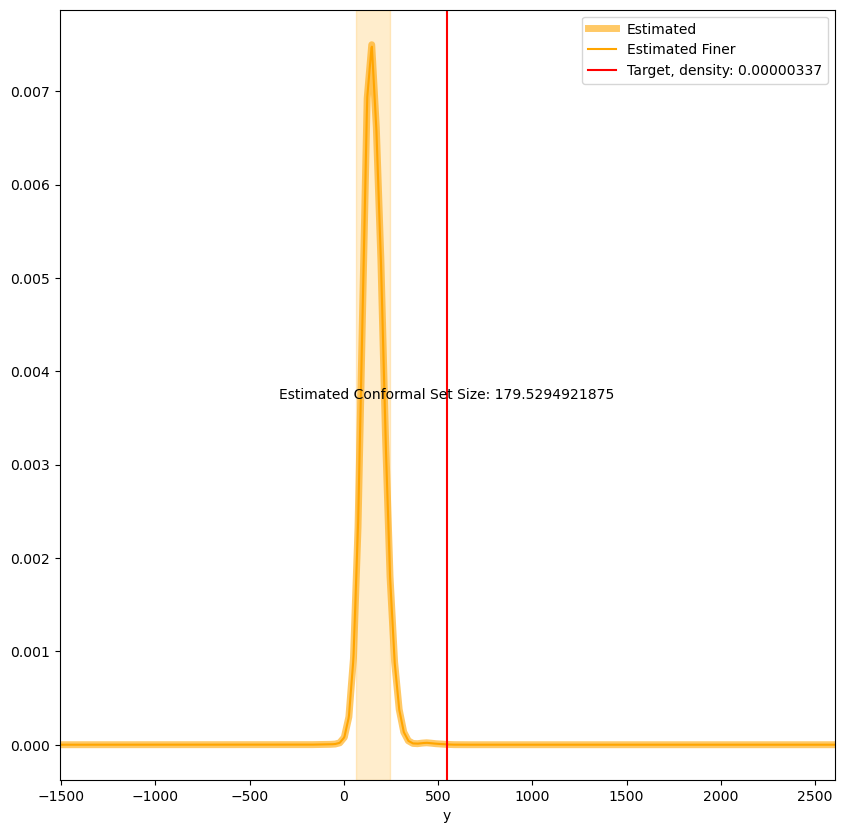

  8%|▊         | 7/84 [00:02<00:36,  2.11it/s]

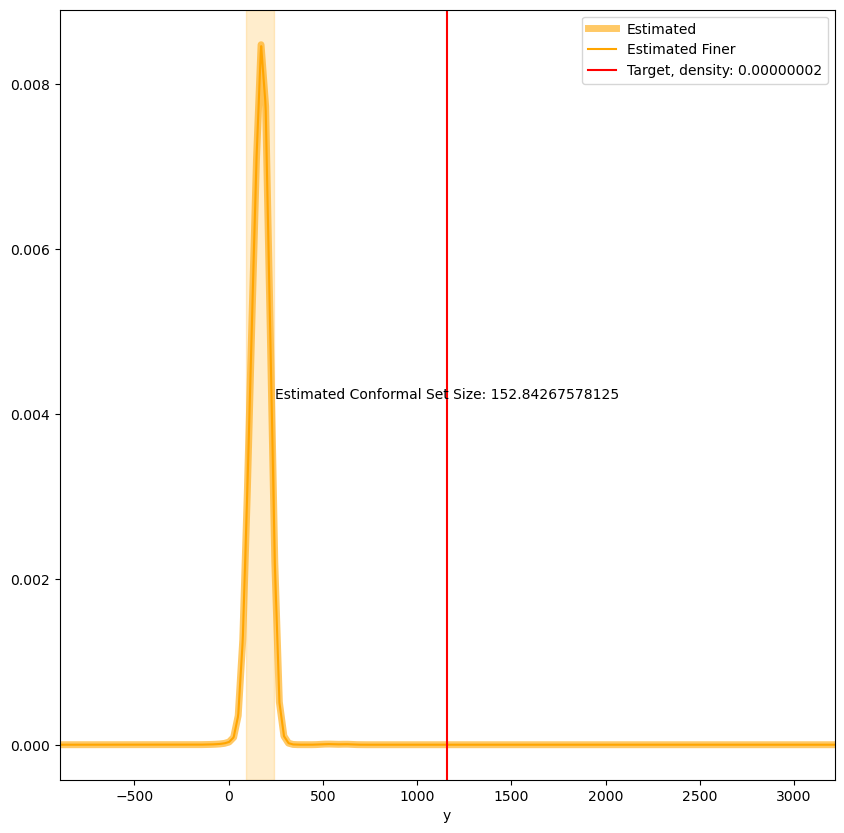

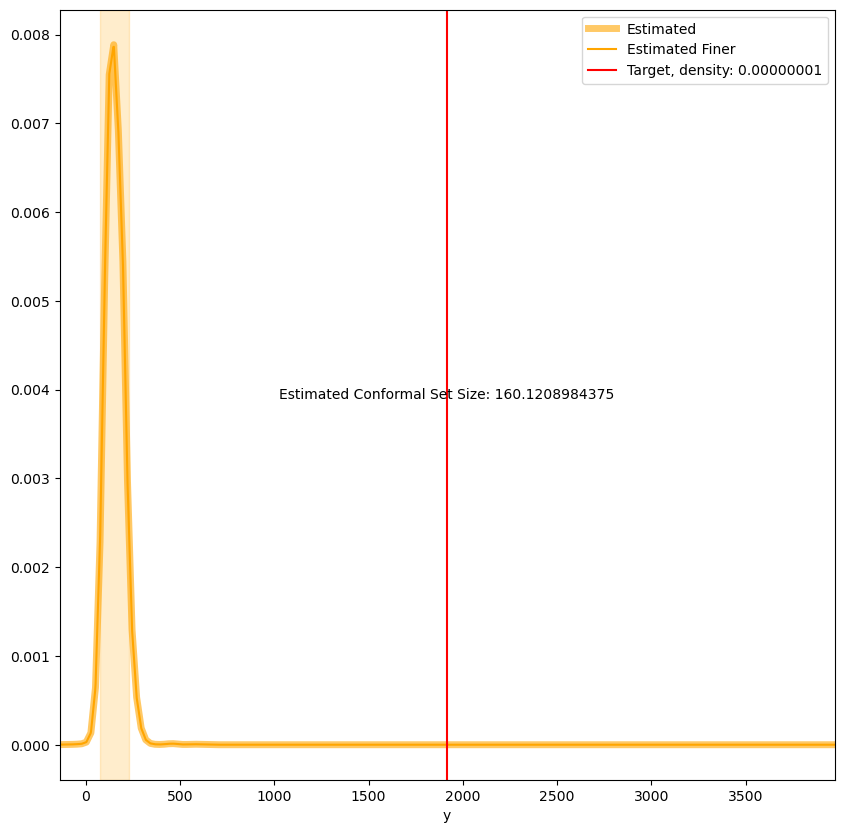

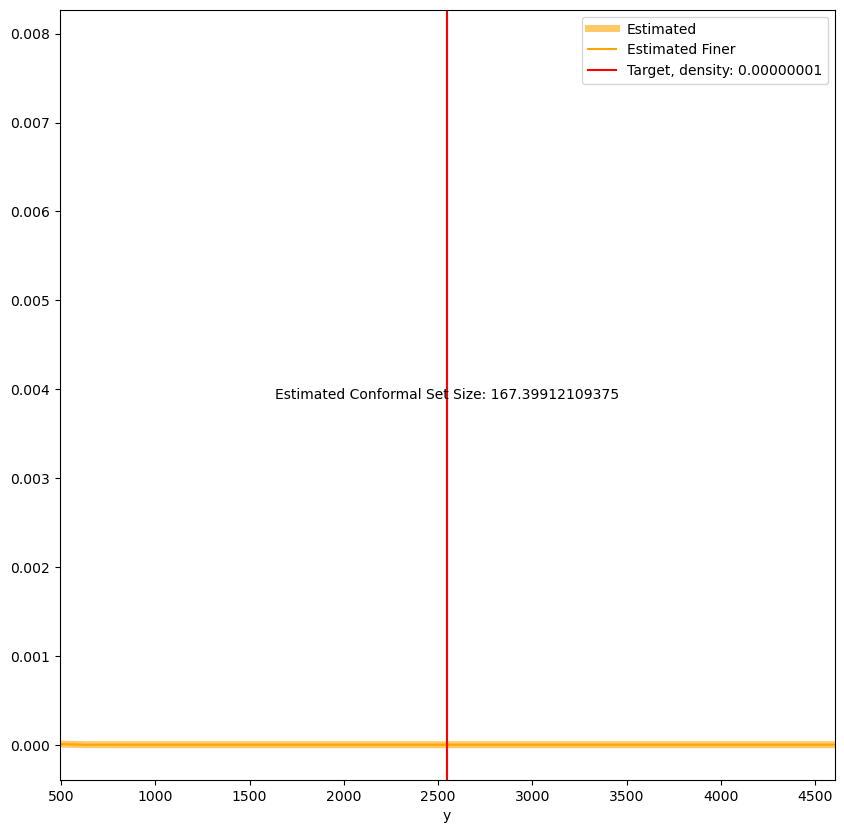

 10%|▉         | 8/84 [00:04<00:58,  1.30it/s]

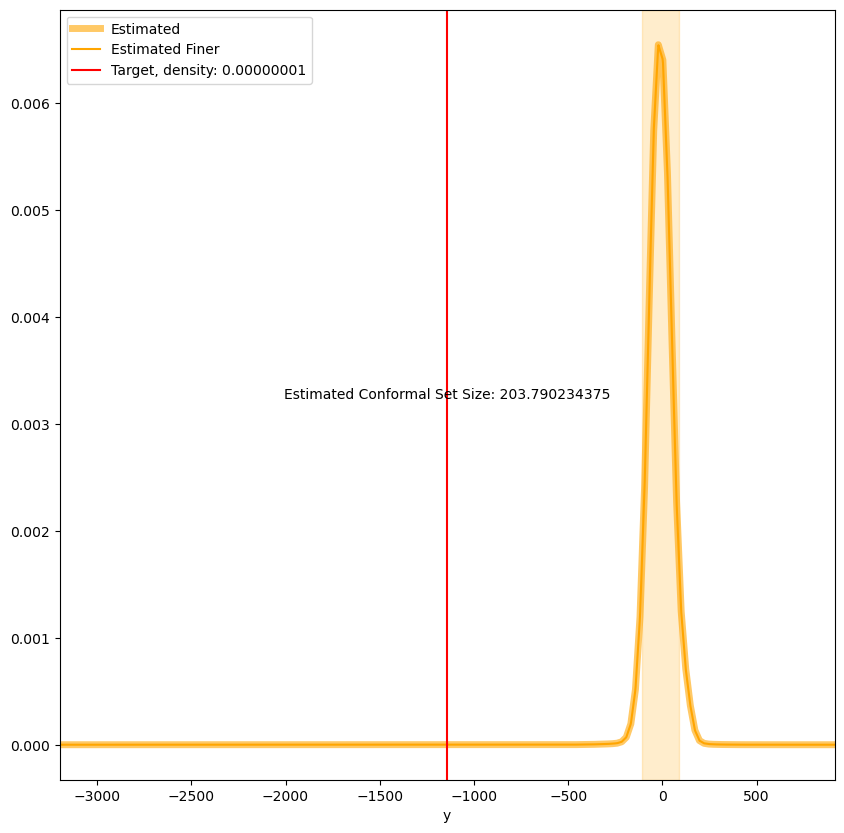

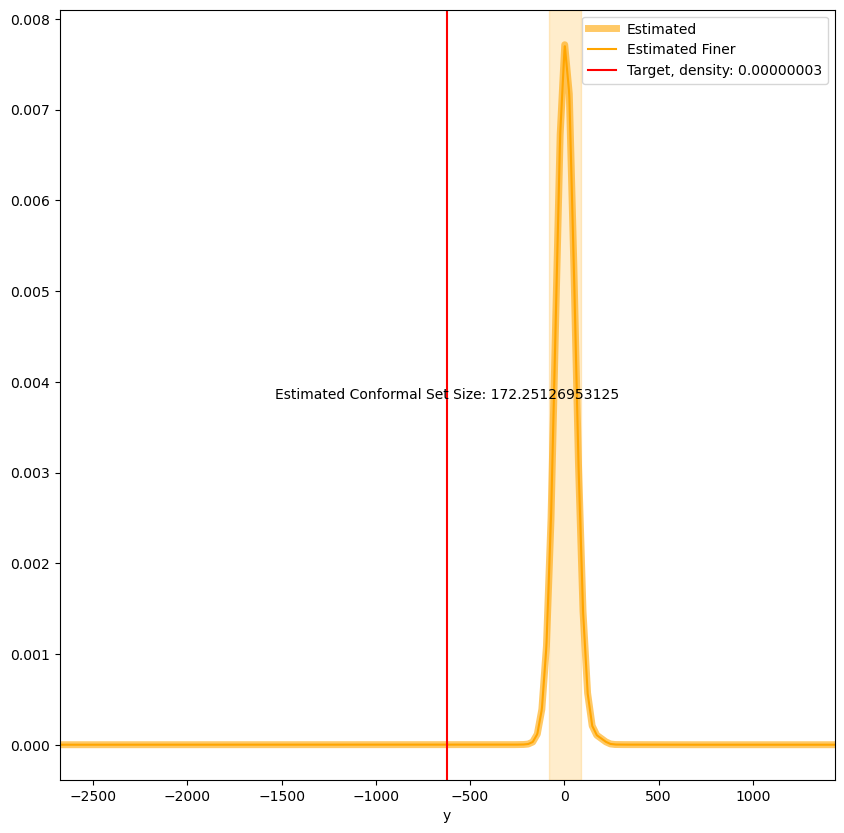

 18%|█▊        | 15/84 [00:05<00:13,  5.03it/s]

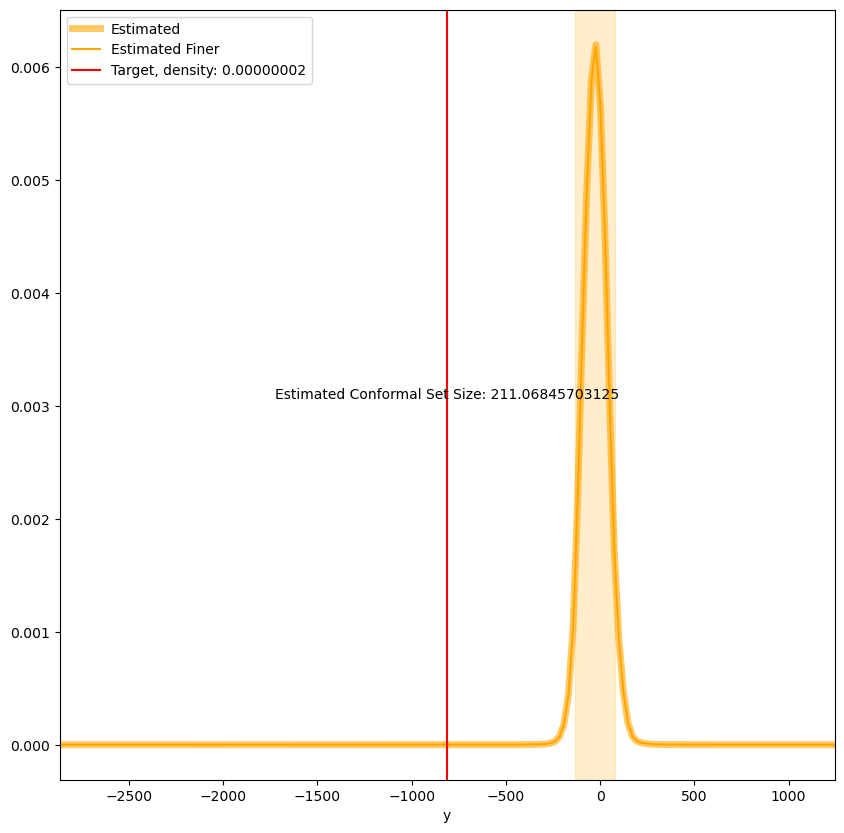

 19%|█▉        | 16/84 [00:06<00:21,  3.11it/s]

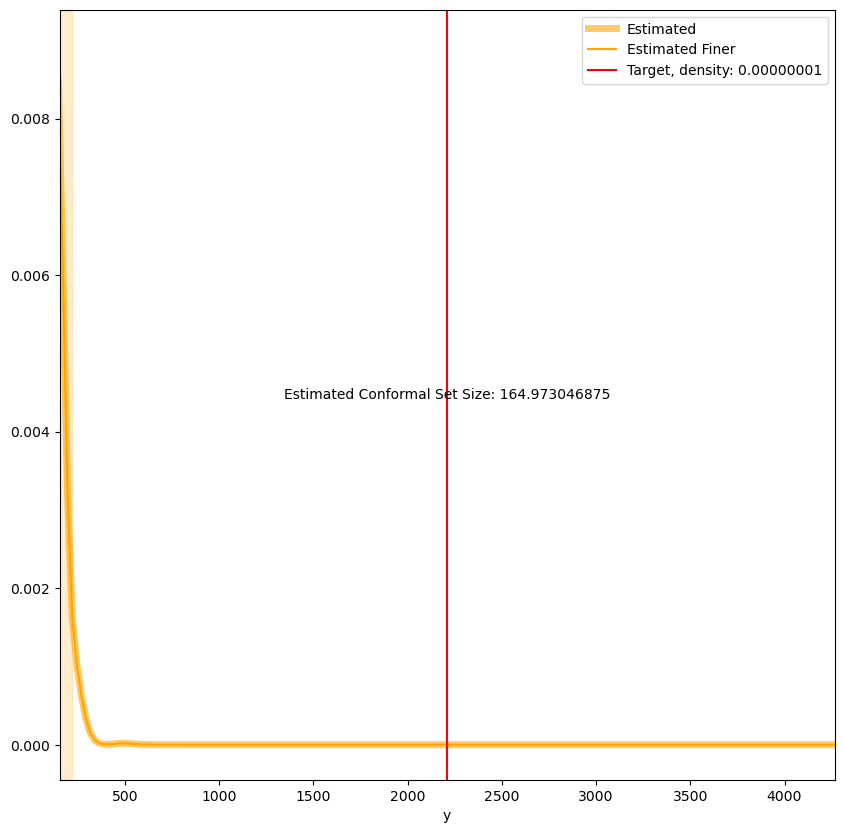

 33%|███▎      | 28/84 [00:08<00:06,  8.20it/s]

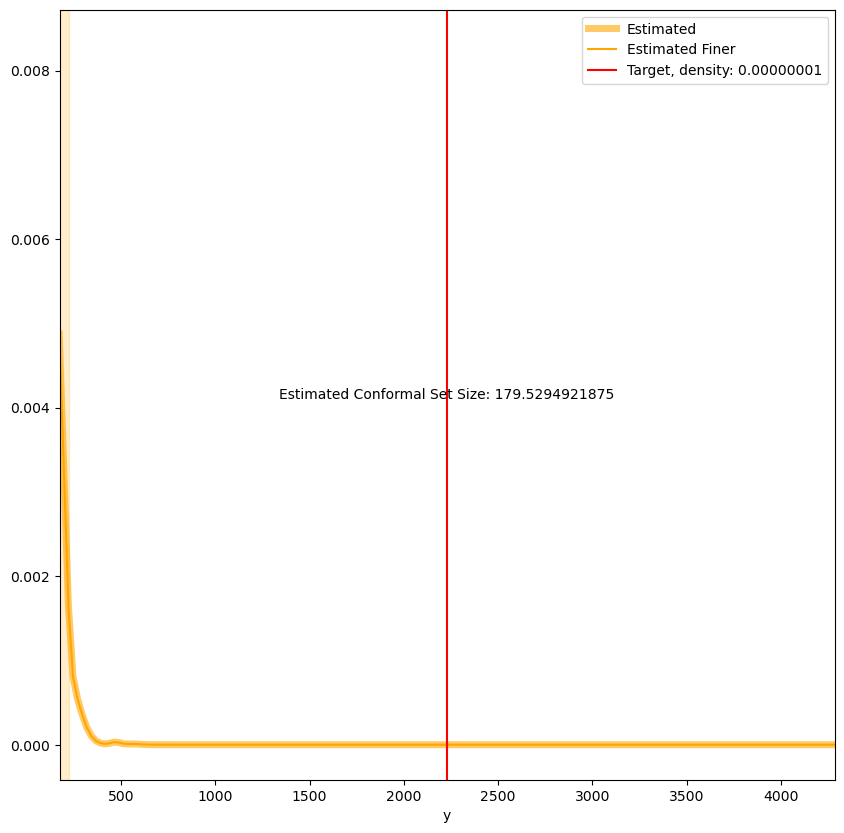

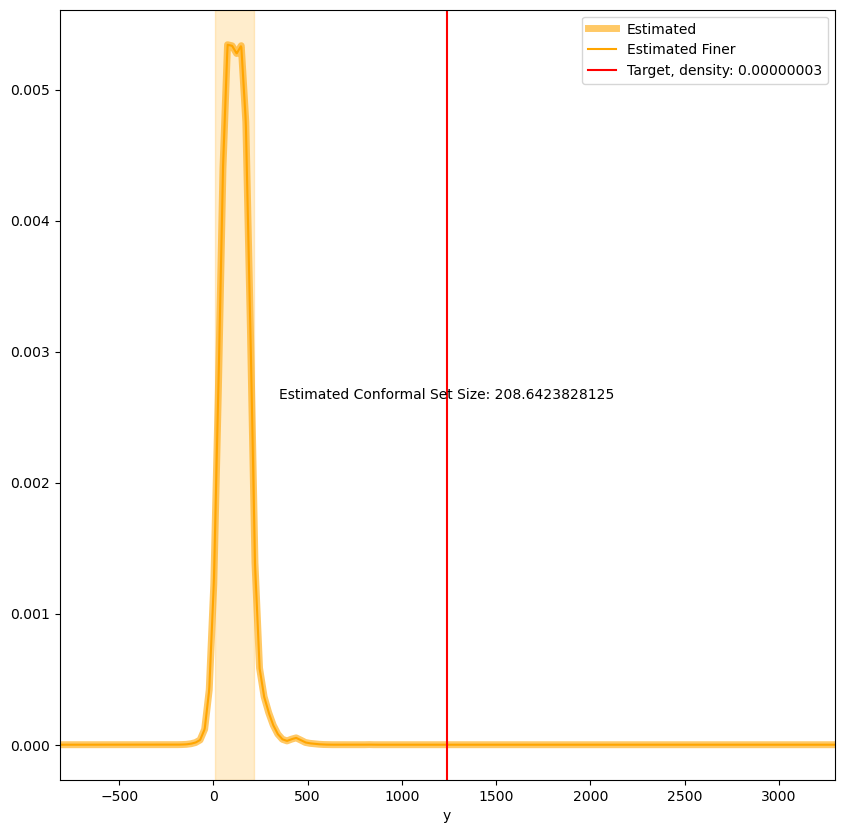

 35%|███▍      | 29/84 [00:09<00:22,  2.41it/s]

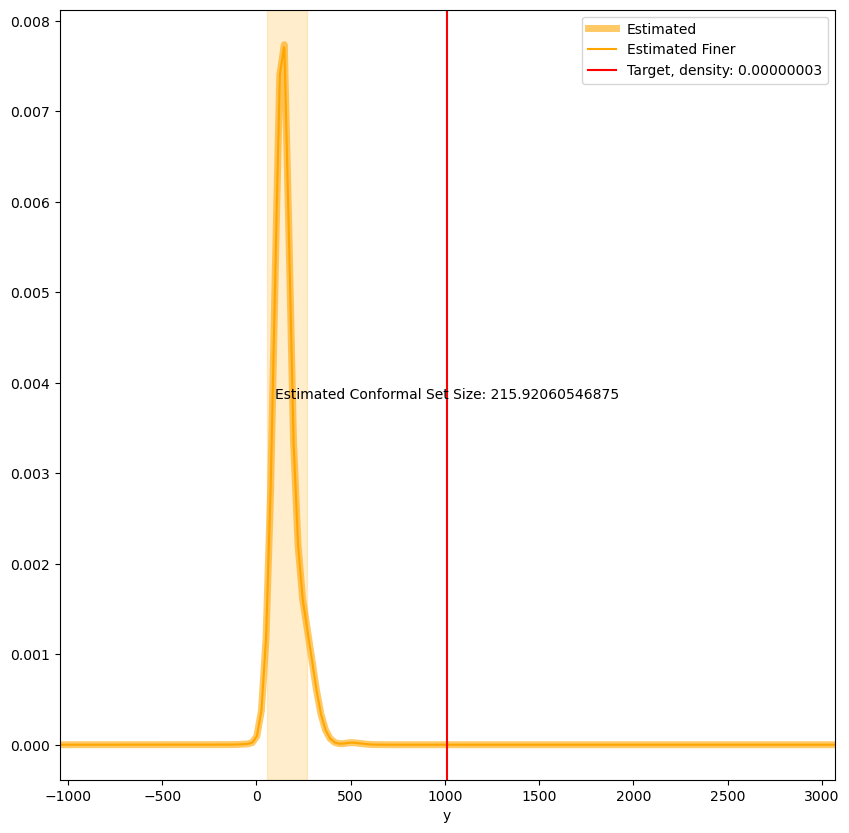

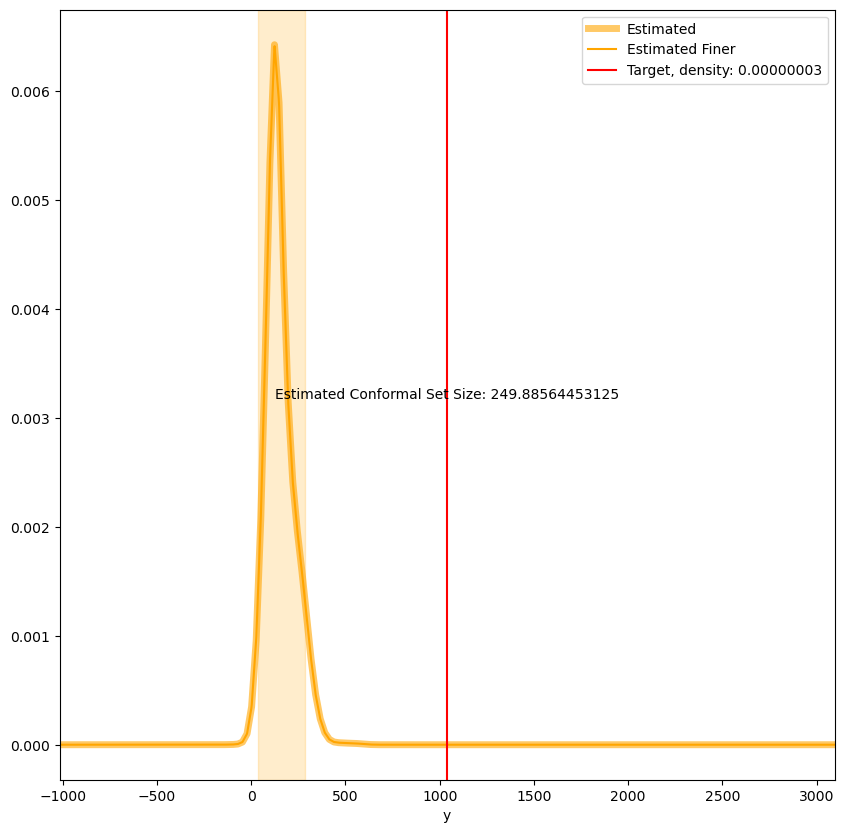

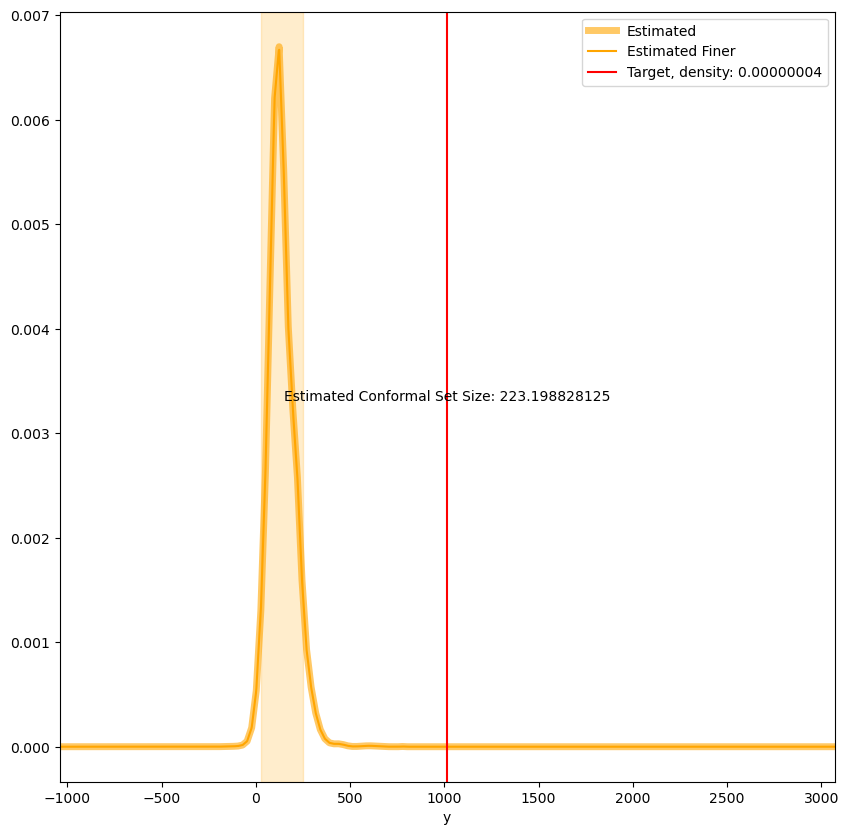

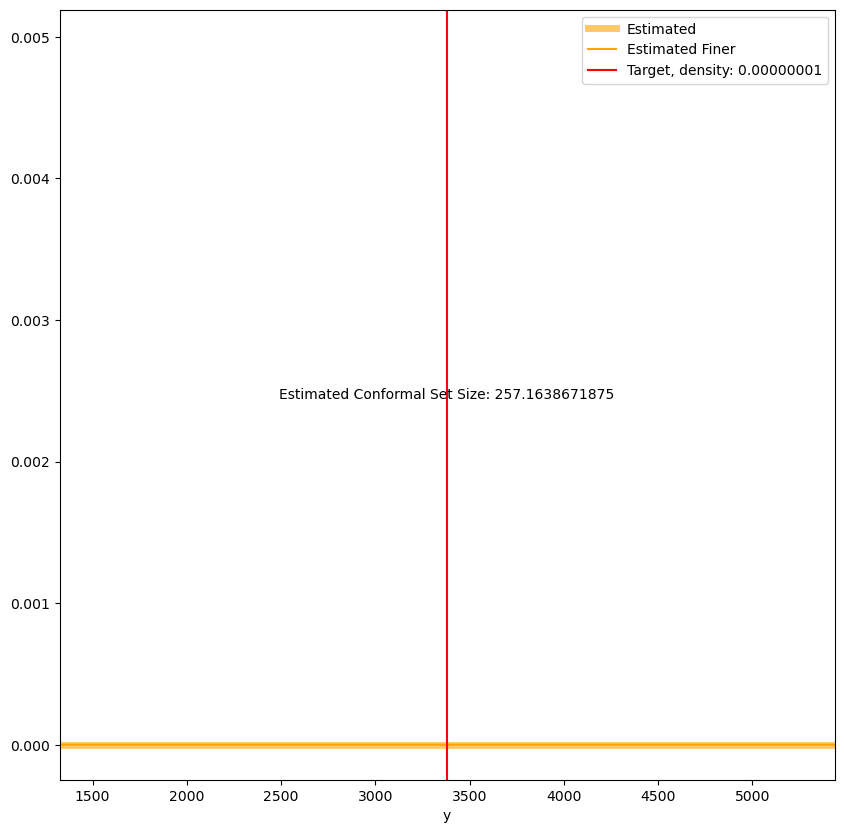

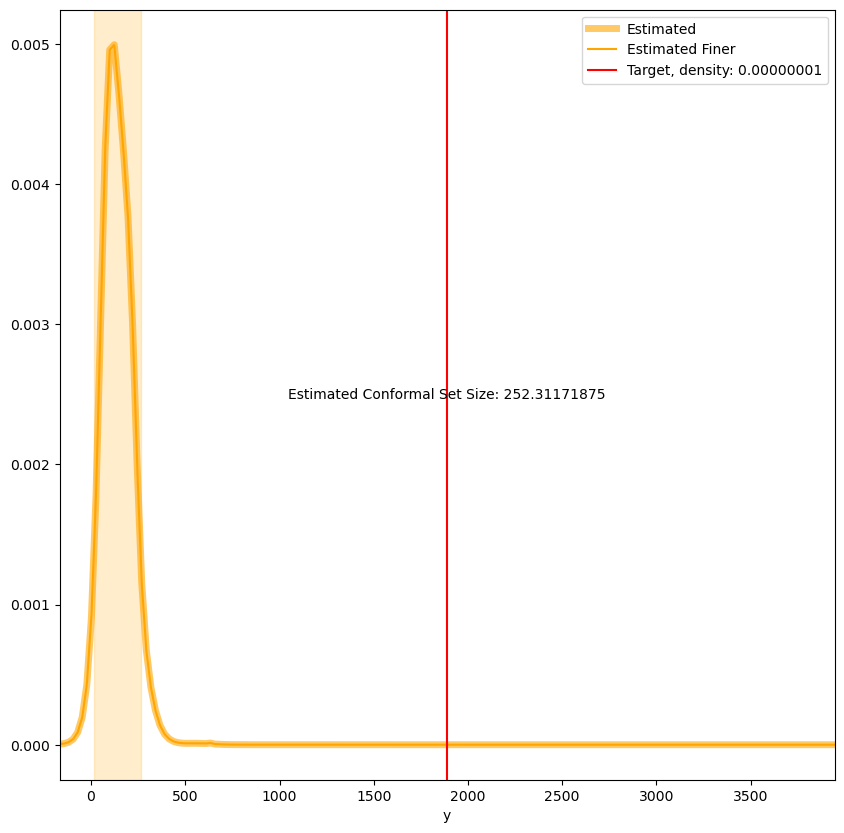

 36%|███▌      | 30/84 [00:11<00:53,  1.01it/s]

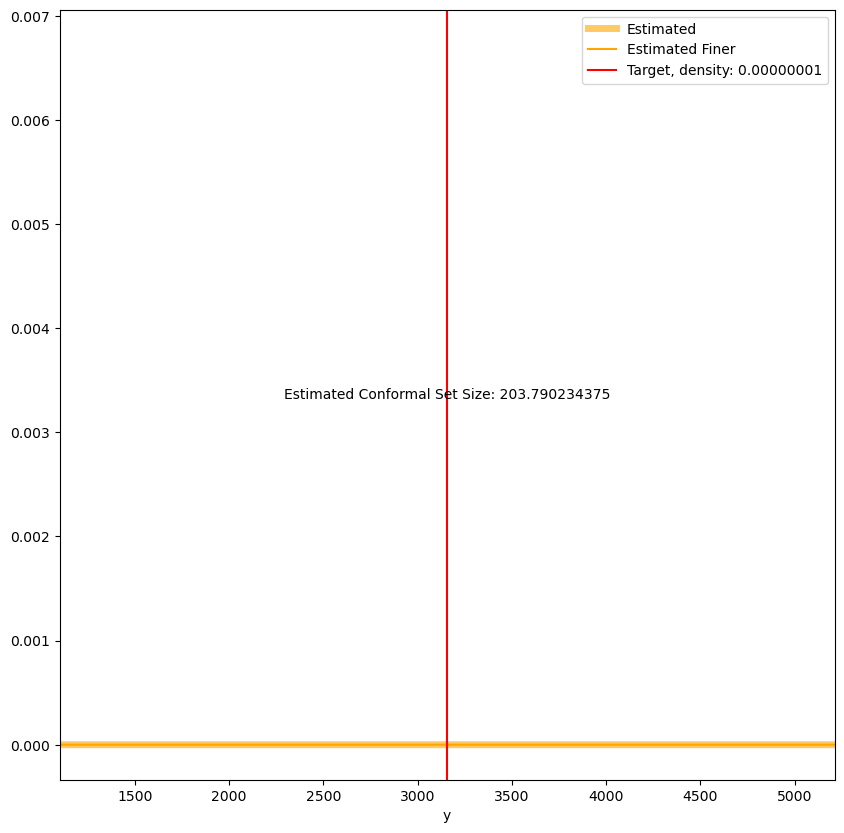

 39%|███▉      | 33/84 [00:12<00:23,  2.18it/s]

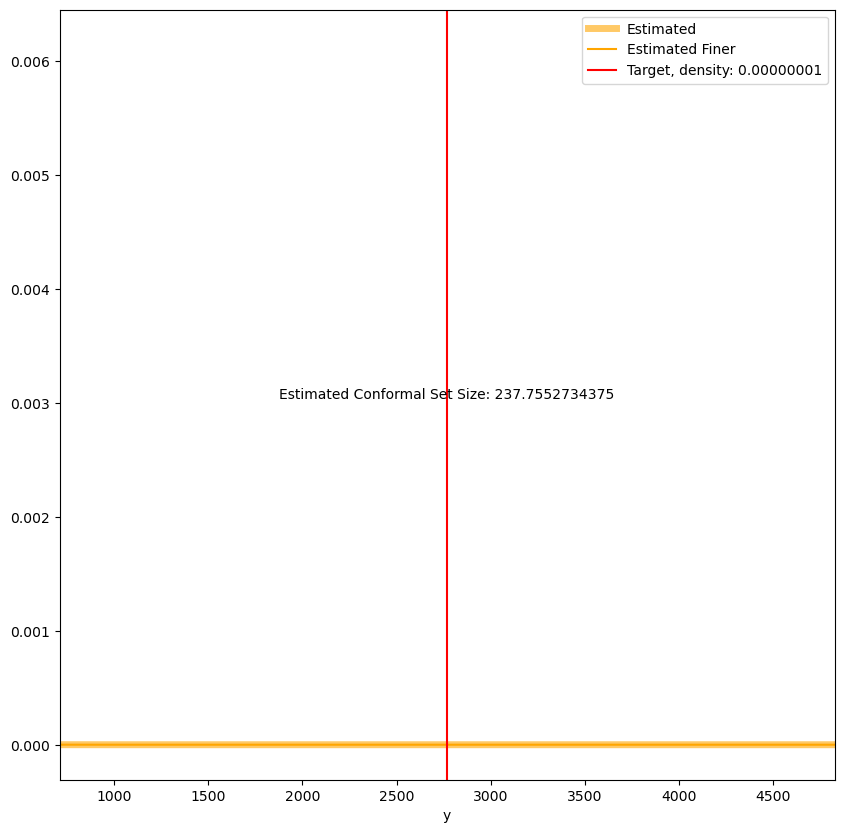

 40%|████      | 34/84 [00:12<00:24,  2.06it/s]

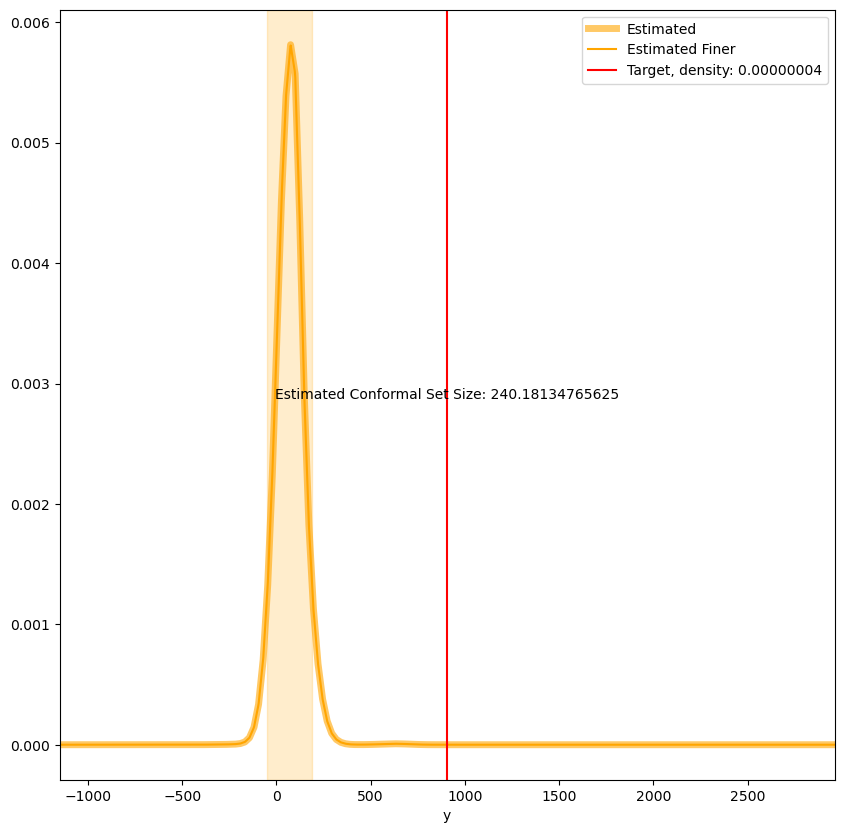

 42%|████▏     | 35/84 [00:13<00:25,  1.95it/s]

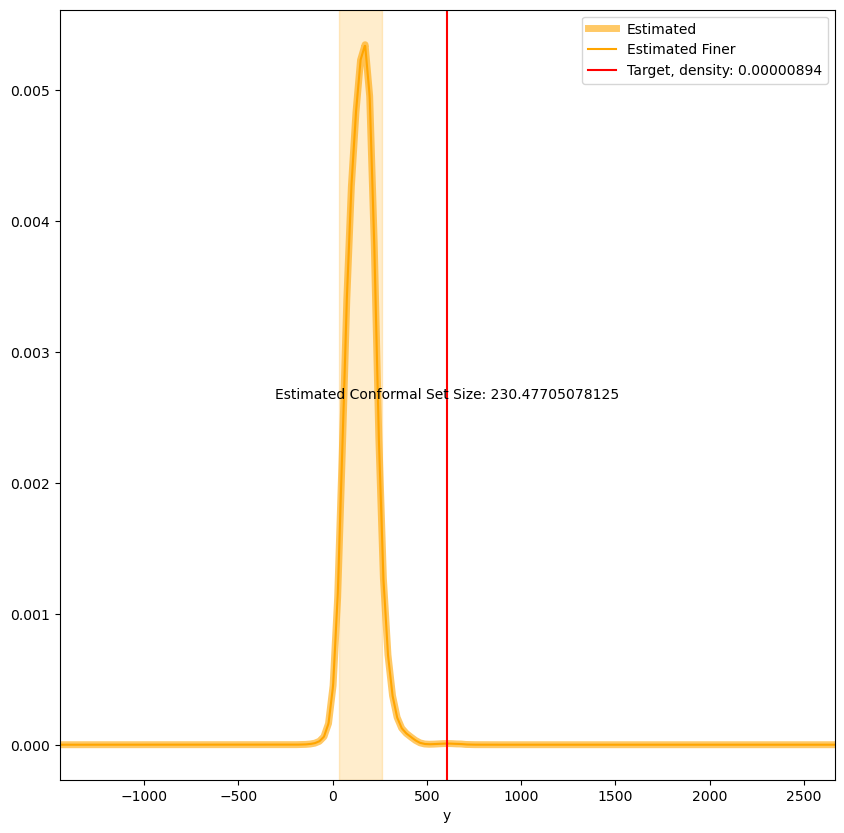

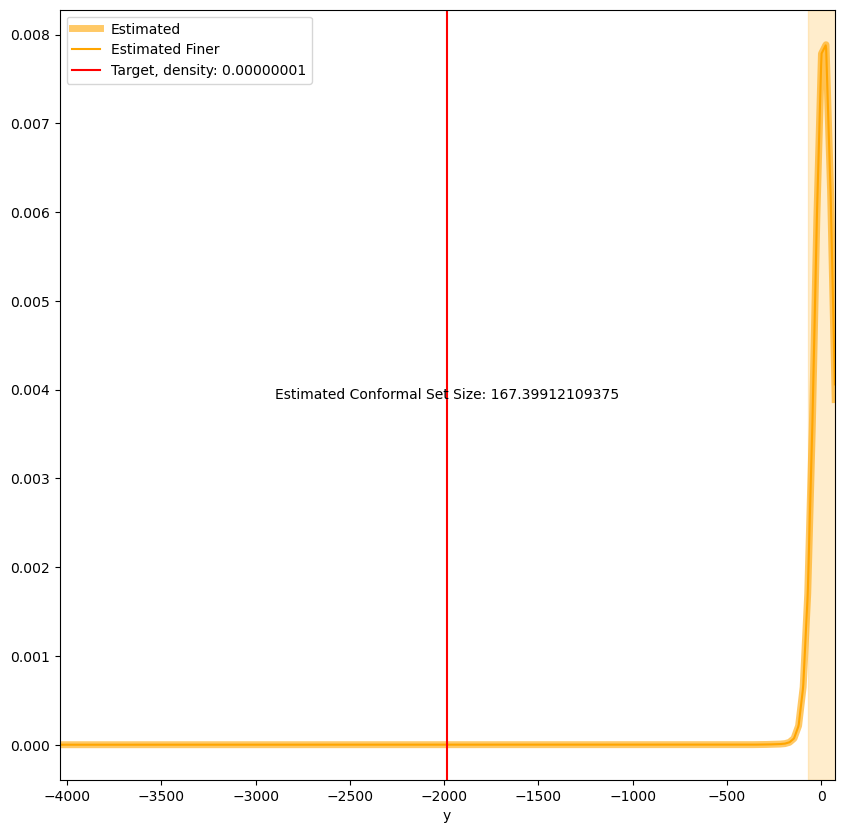

 44%|████▍     | 37/84 [00:14<00:22,  2.07it/s]

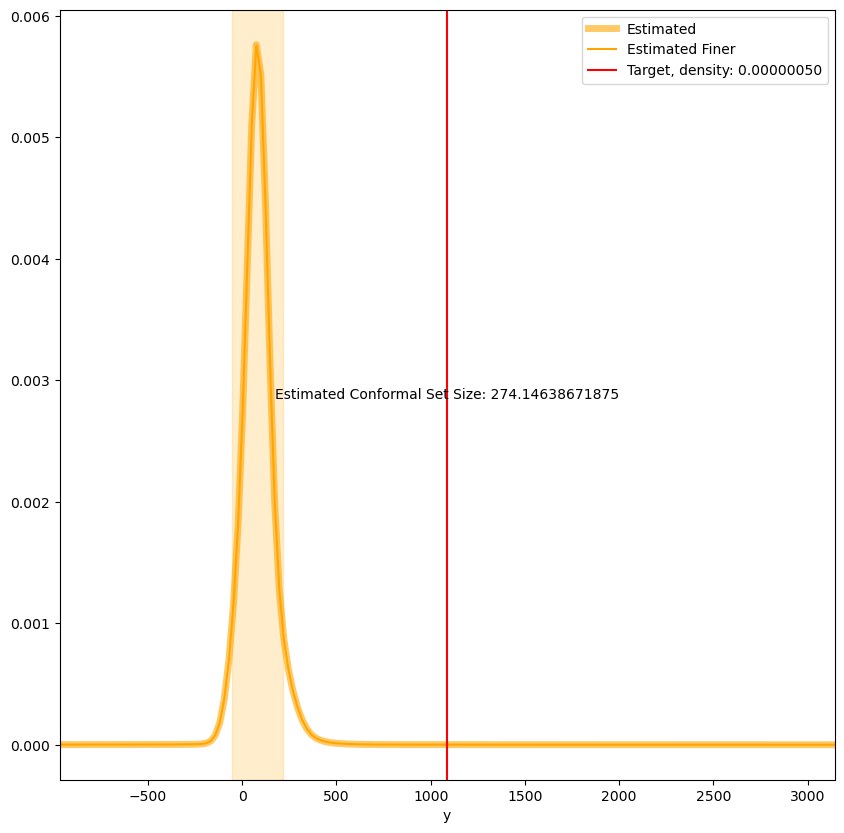

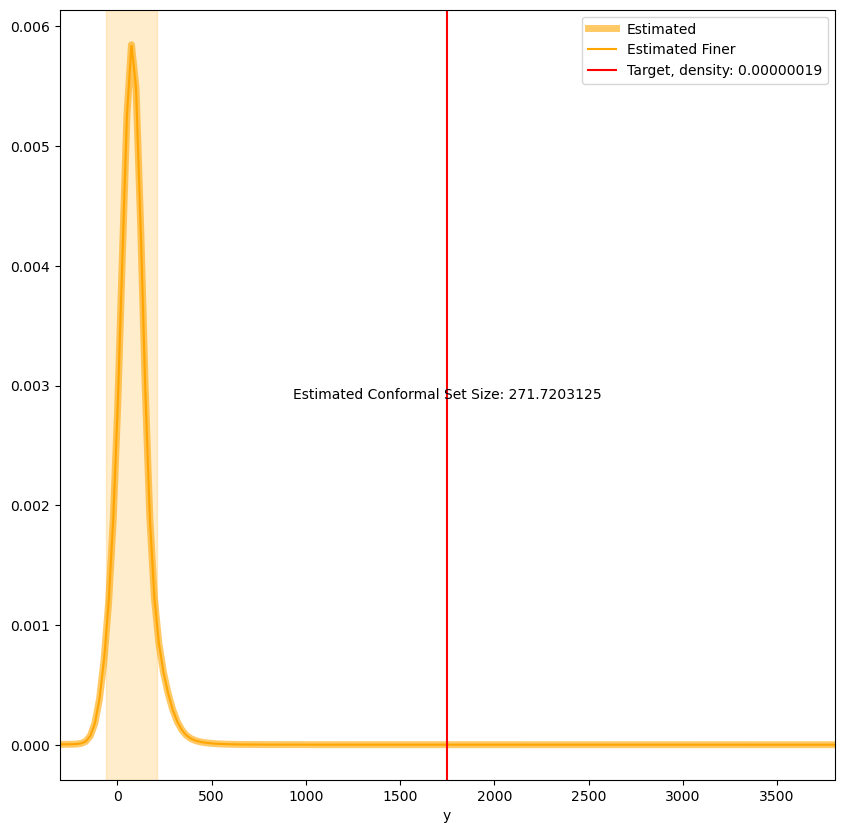

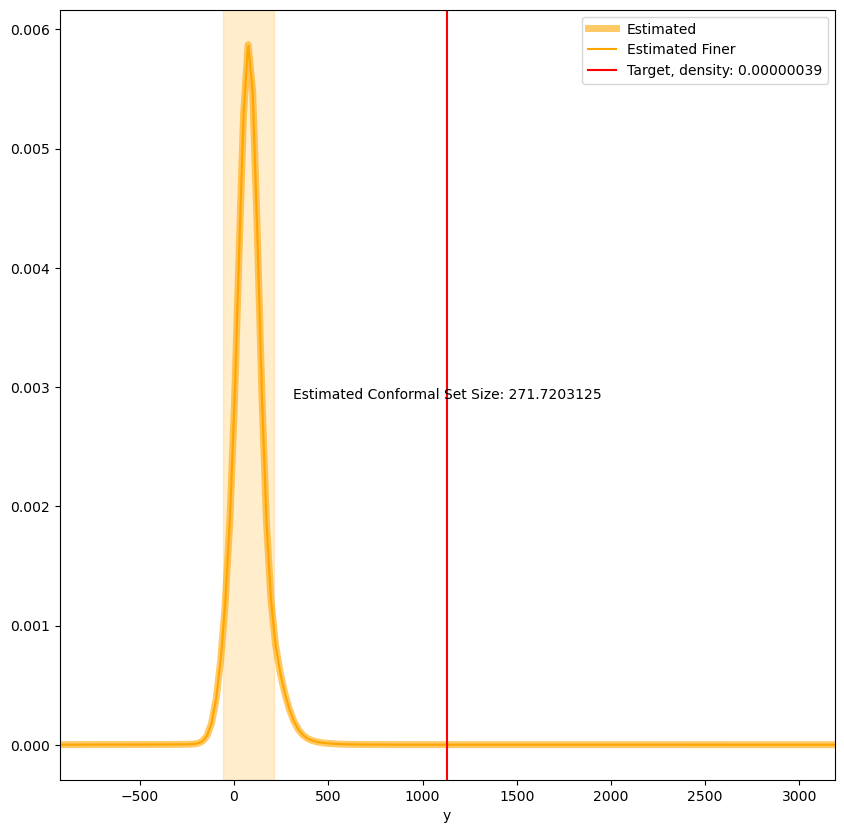

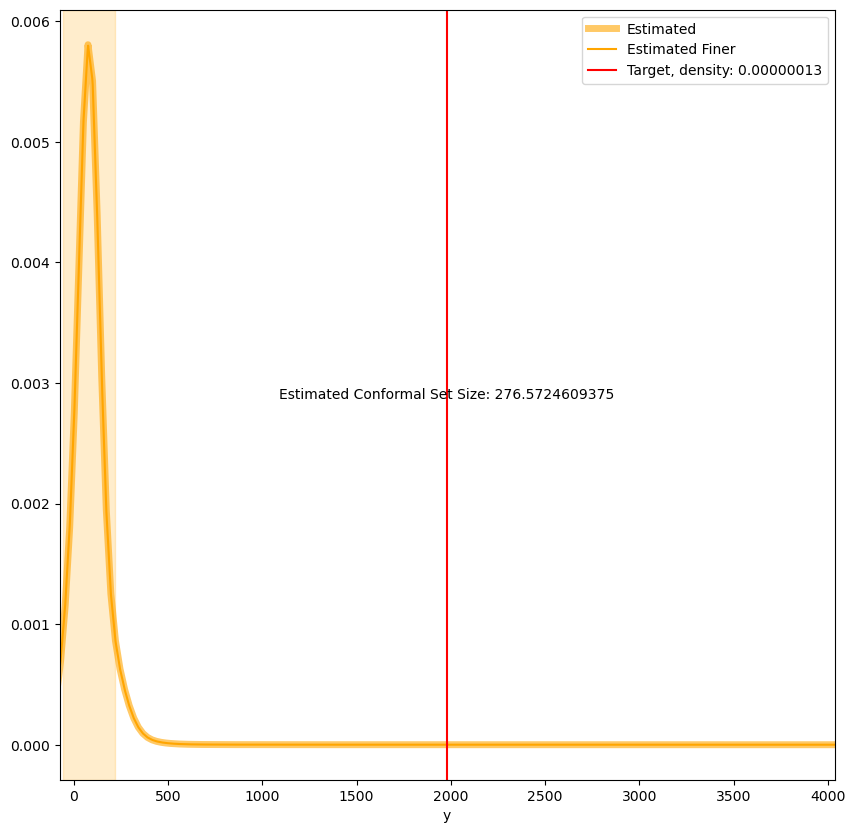

 46%|████▋     | 39/84 [00:16<00:29,  1.50it/s]

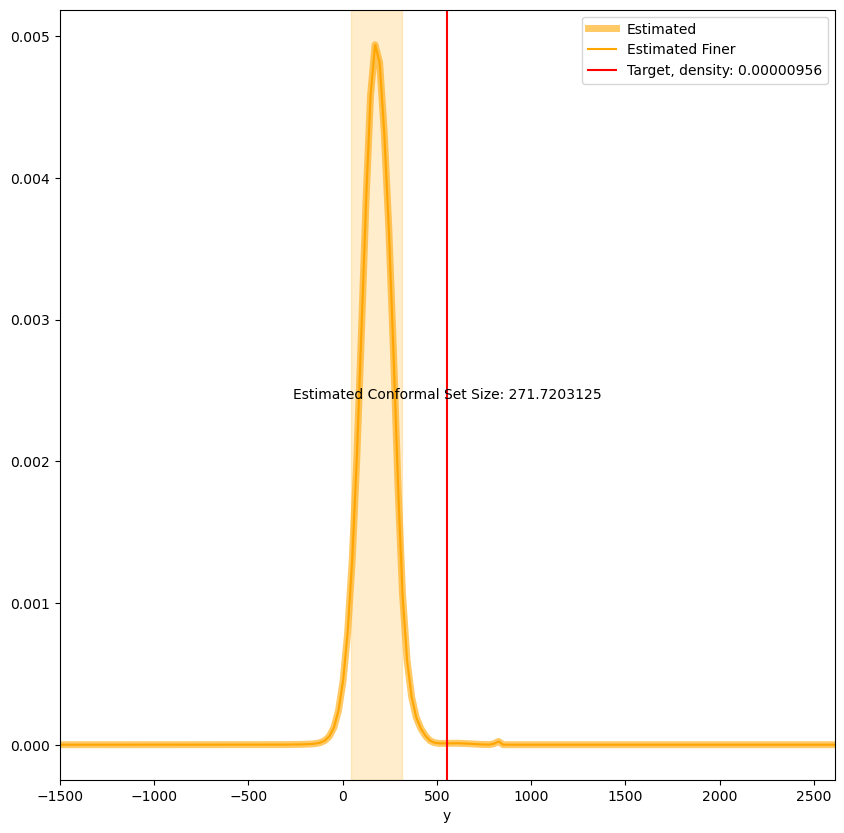

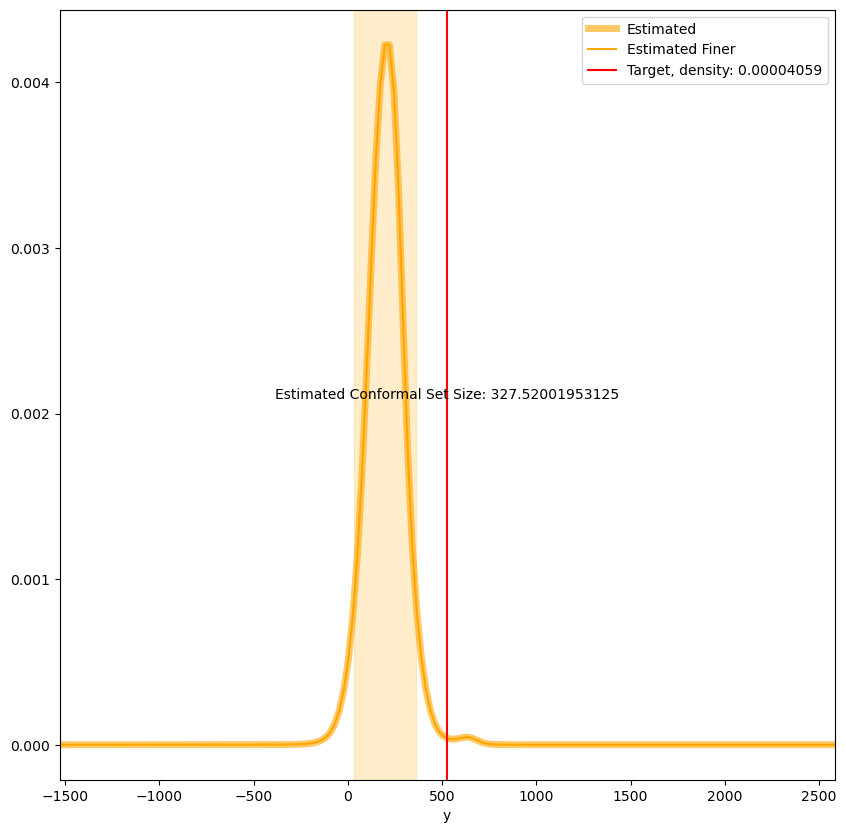

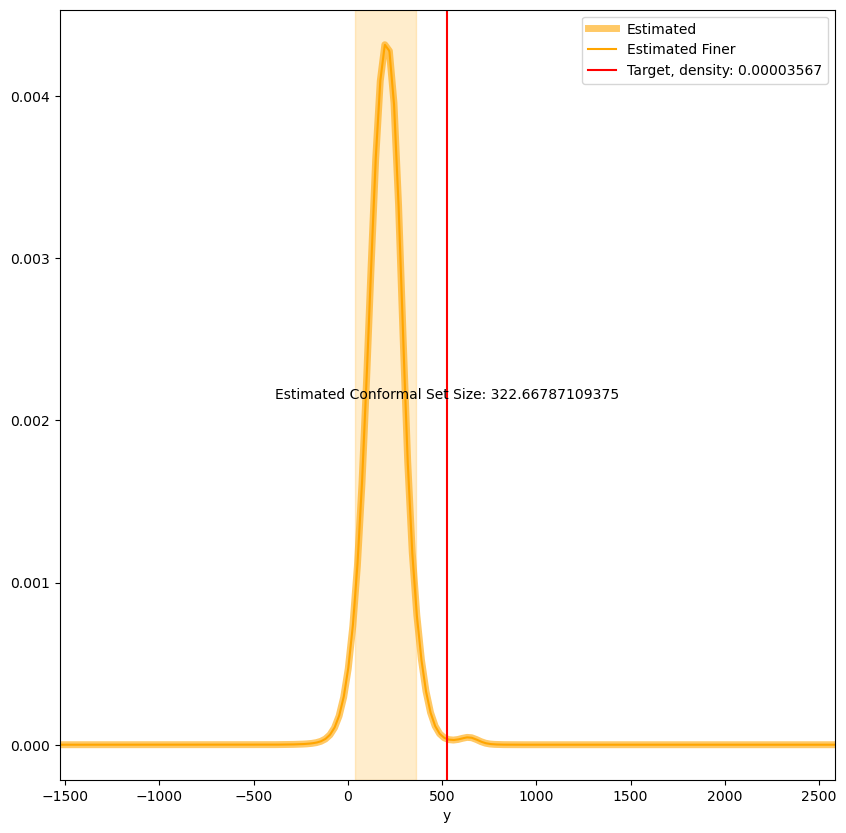

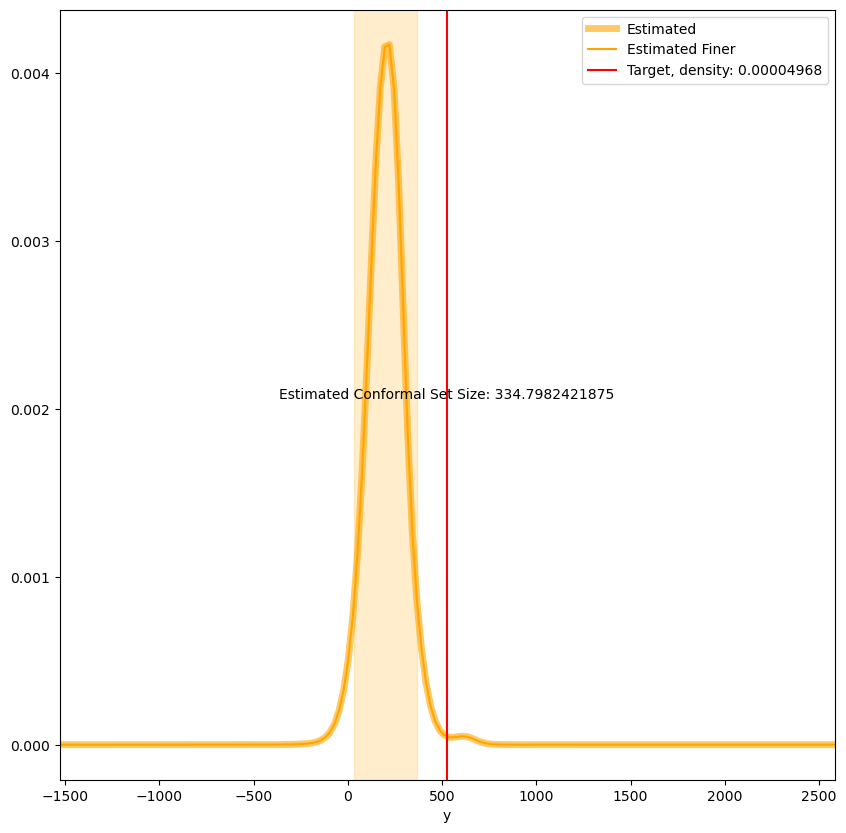

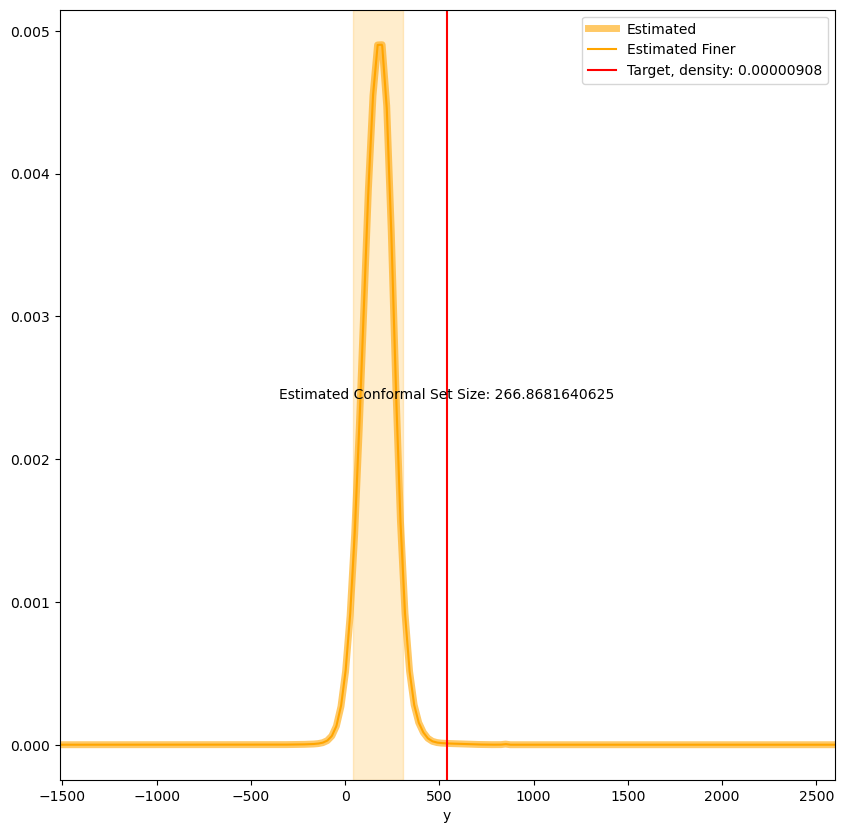

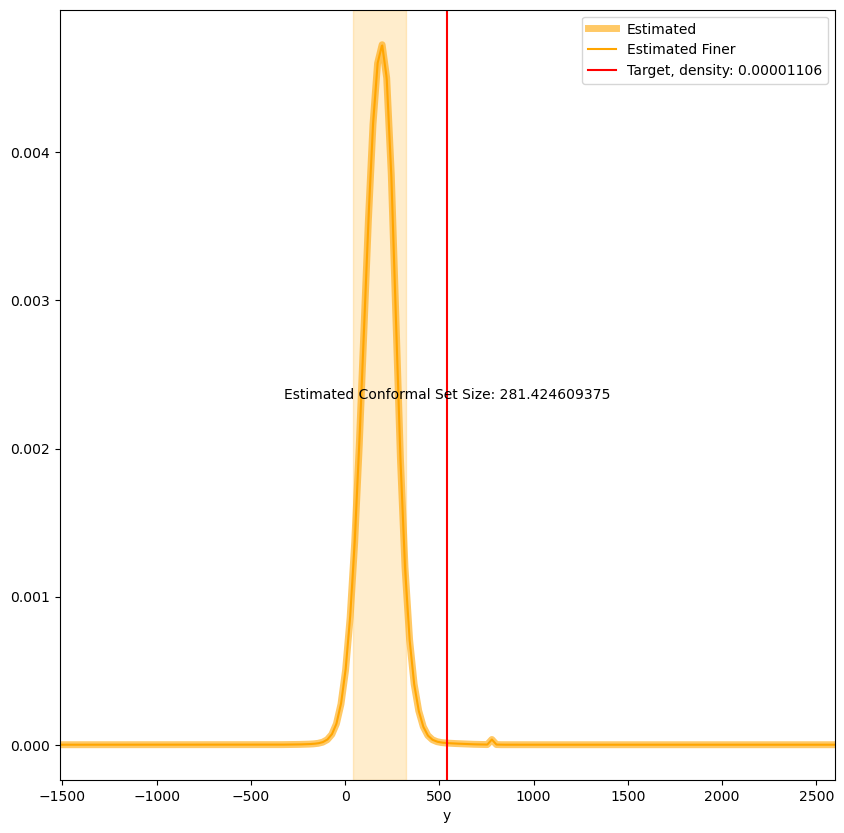

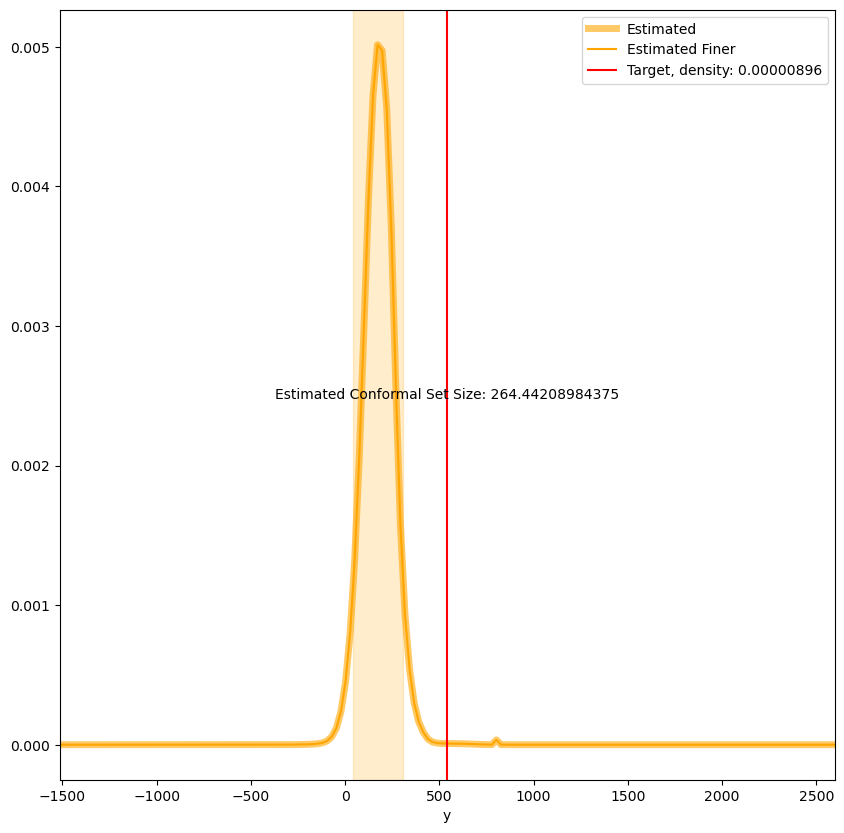

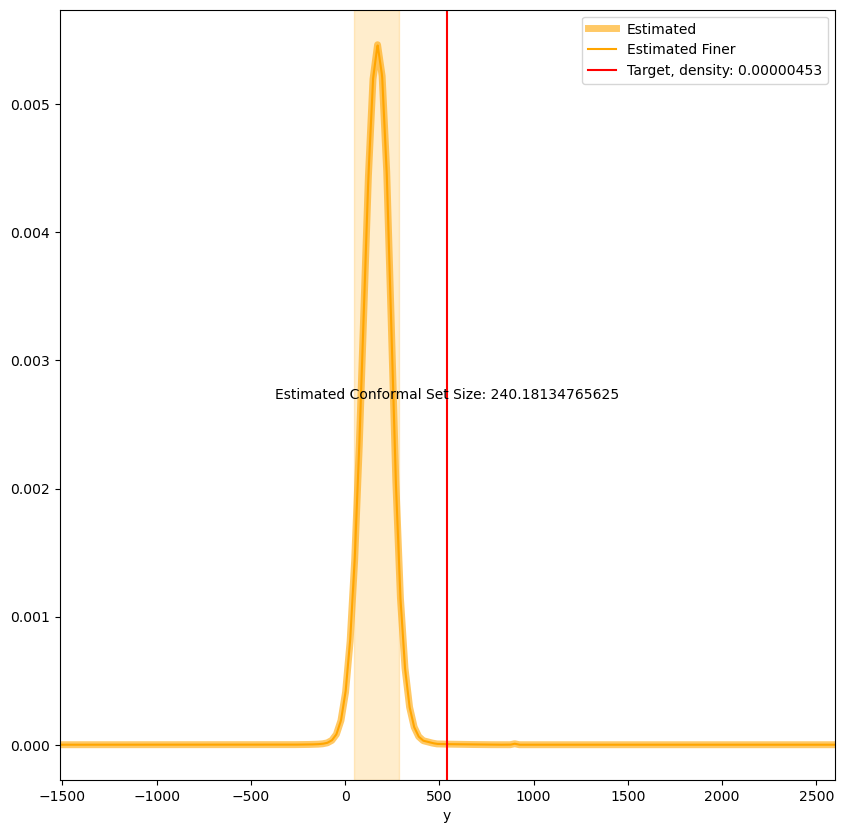

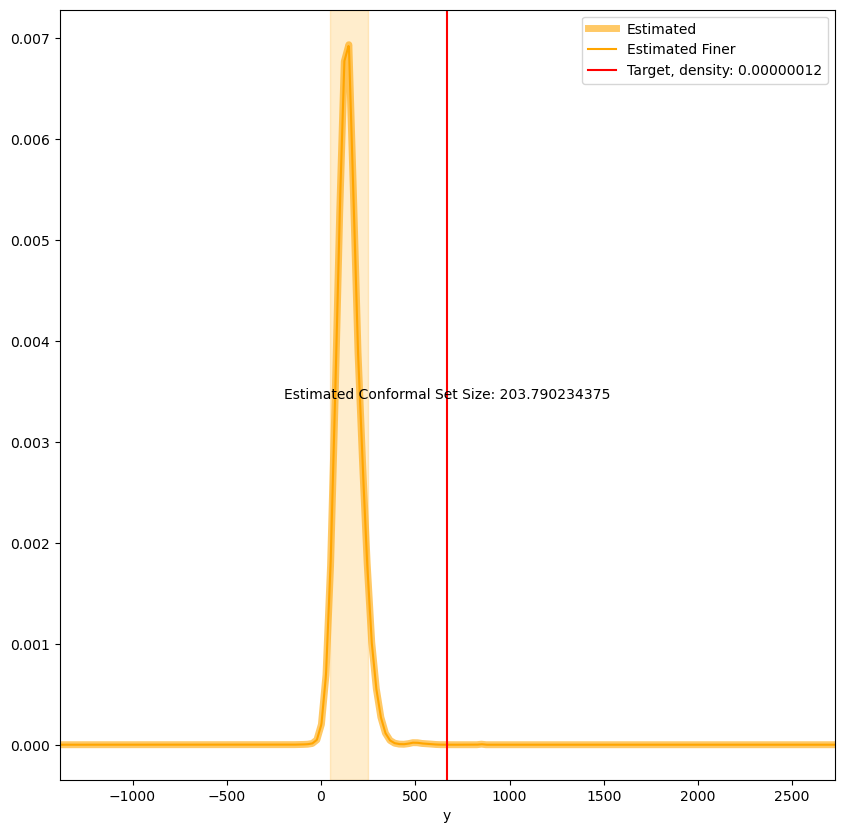

 49%|████▉     | 41/84 [00:20<00:50,  1.18s/it]

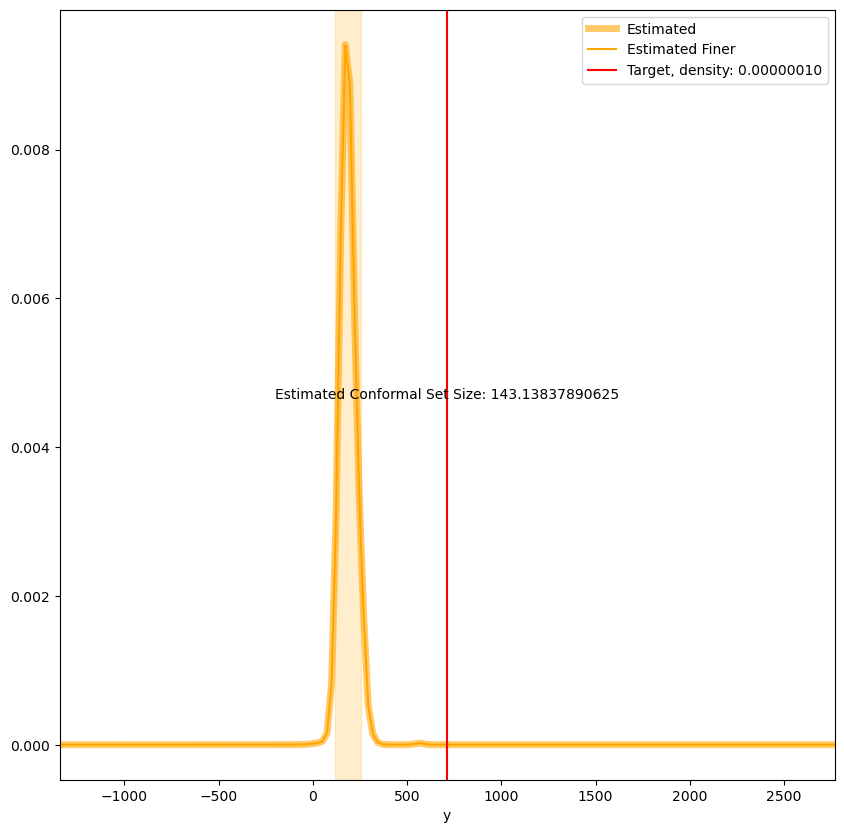

 51%|█████     | 43/84 [00:21<00:30,  1.35it/s]

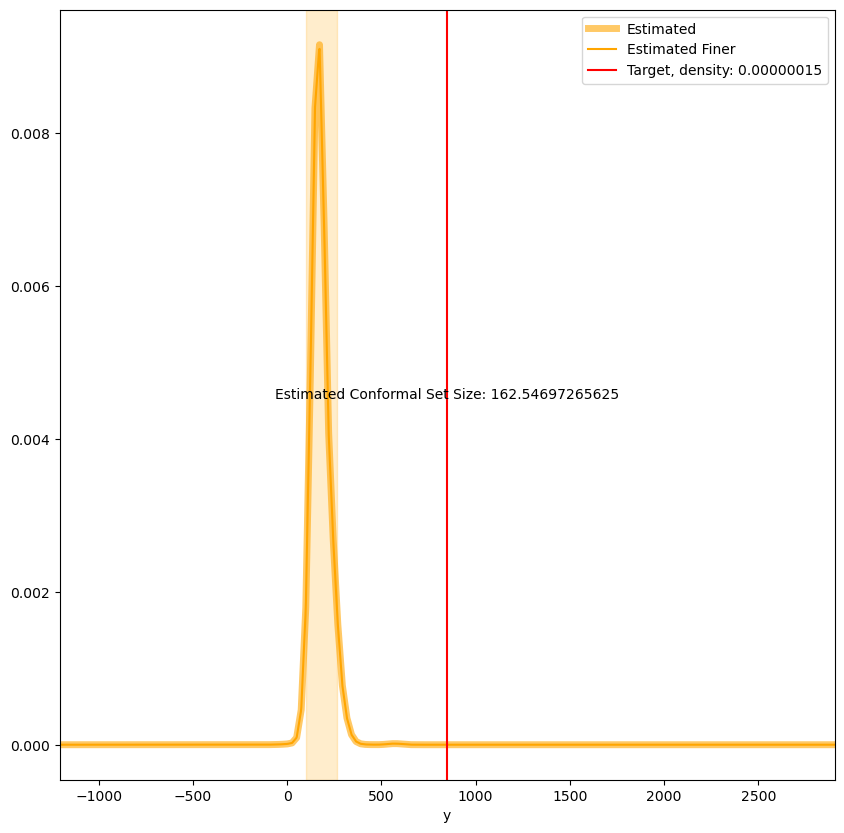

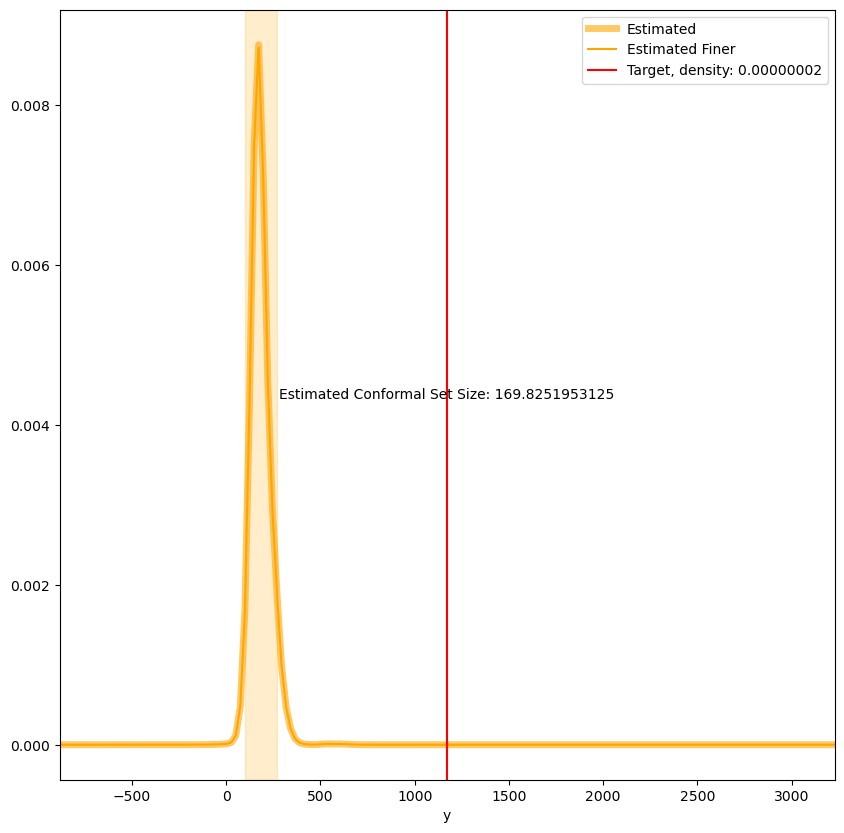

 52%|█████▏    | 44/84 [00:22<00:31,  1.28it/s]

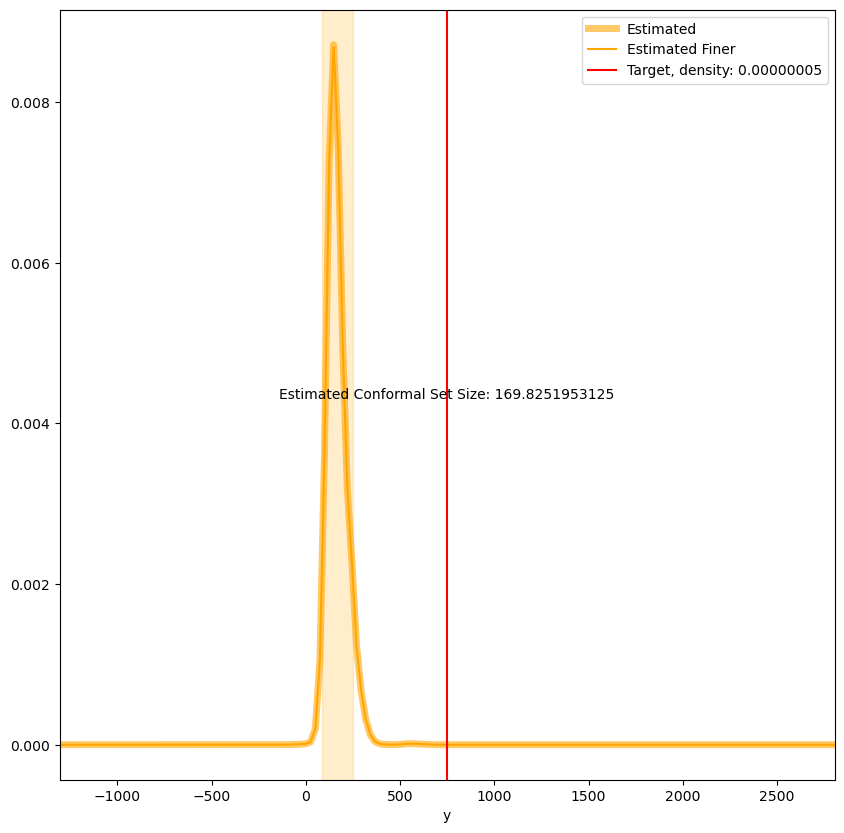

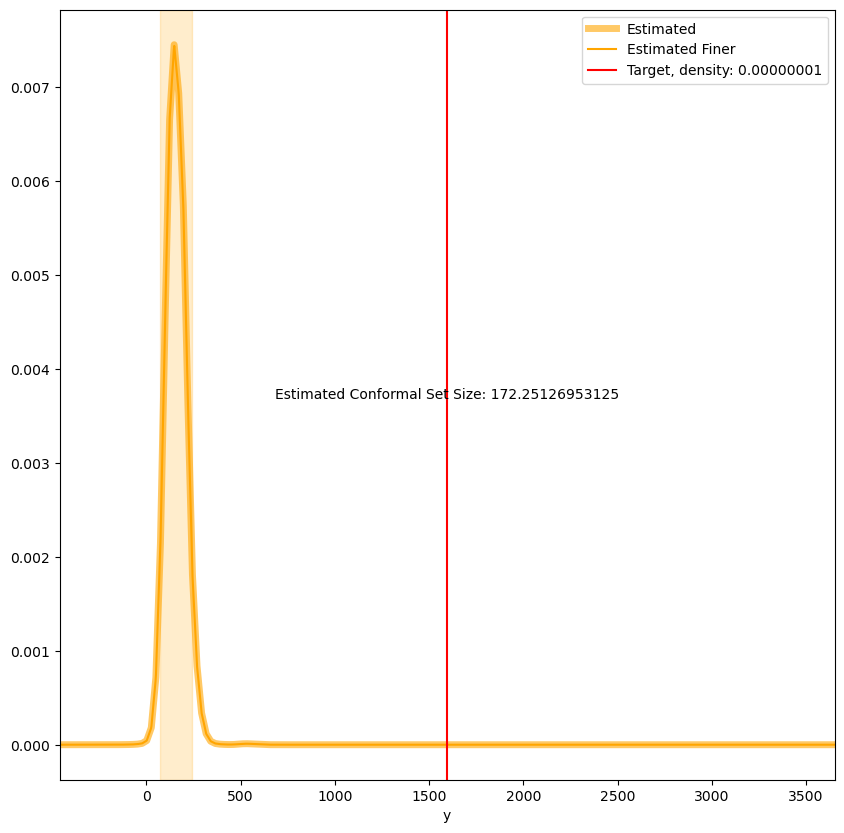

 54%|█████▎    | 45/84 [00:23<00:33,  1.15it/s]

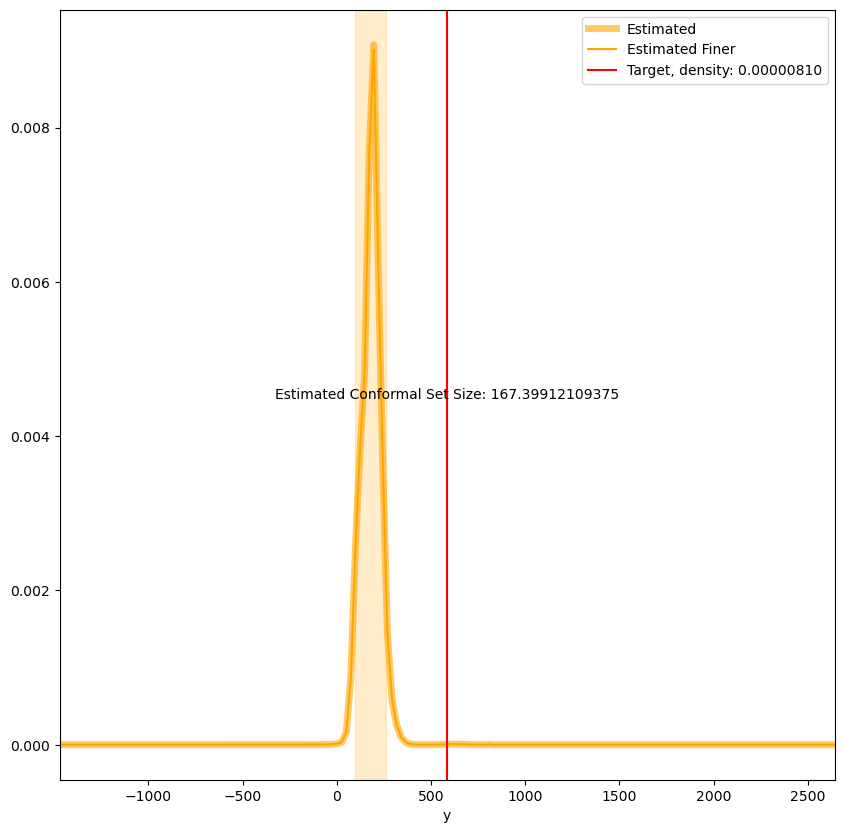

 55%|█████▍    | 46/84 [00:23<00:28,  1.33it/s]

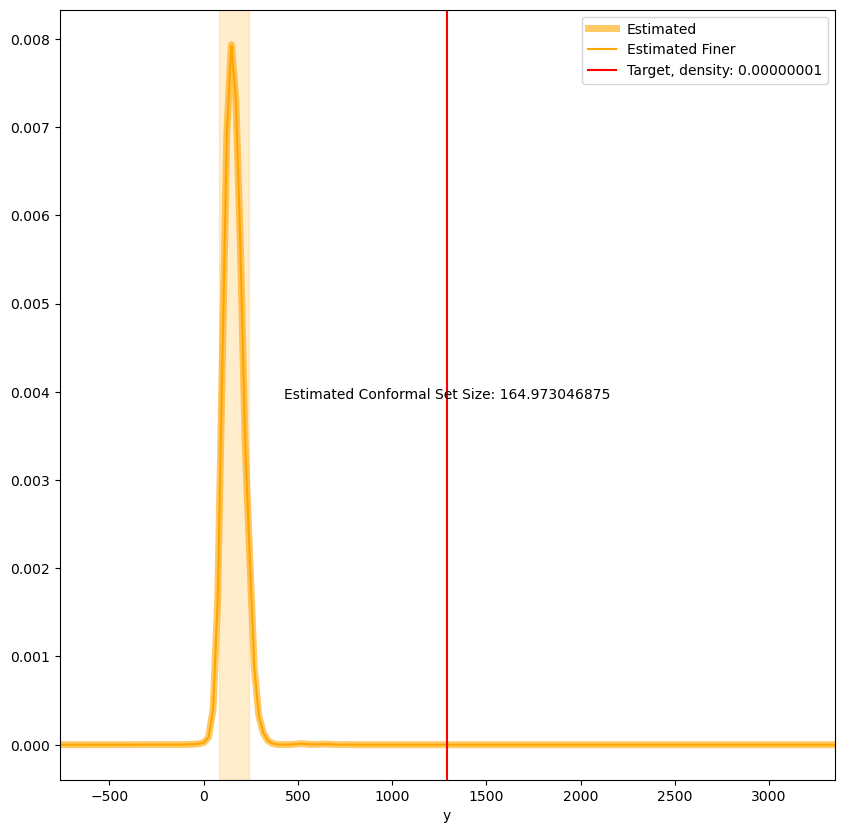

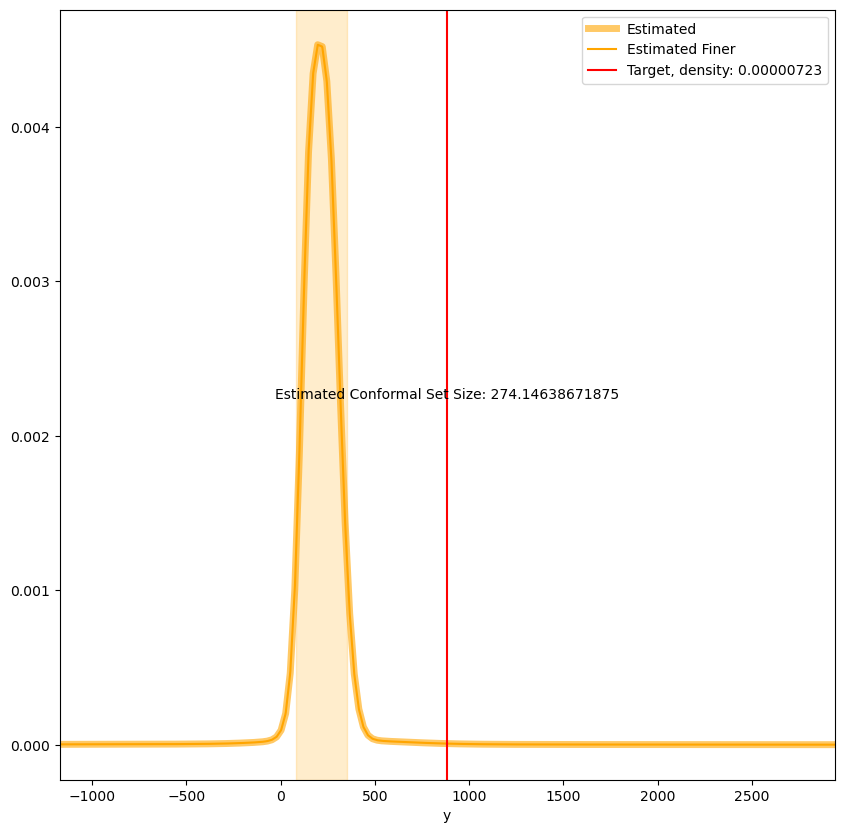

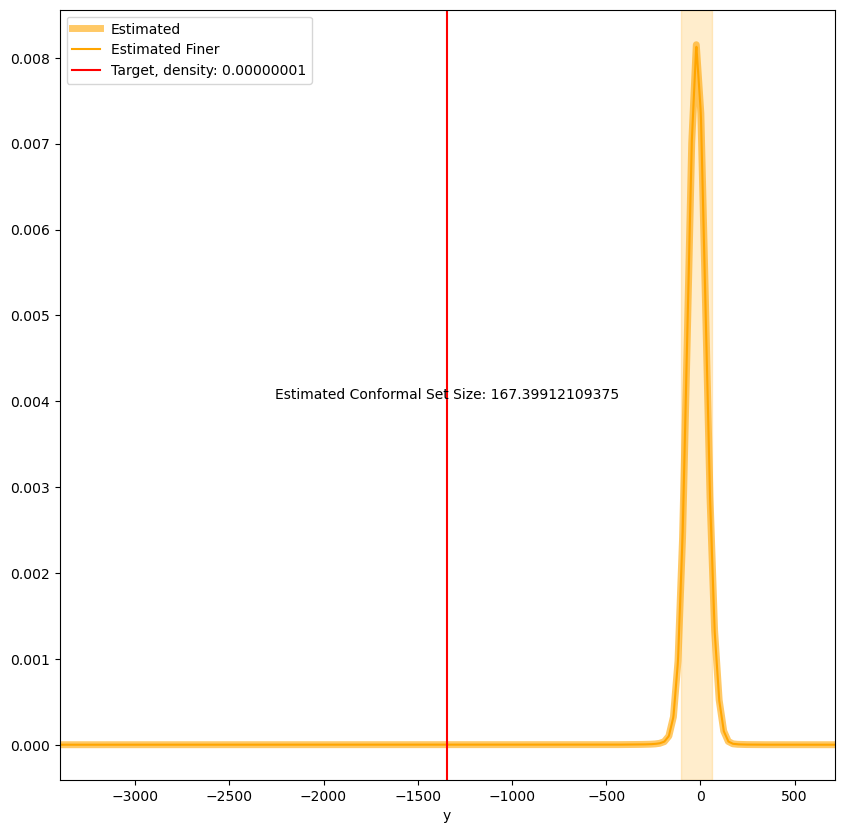

 56%|█████▌    | 47/84 [00:25<00:36,  1.00it/s]

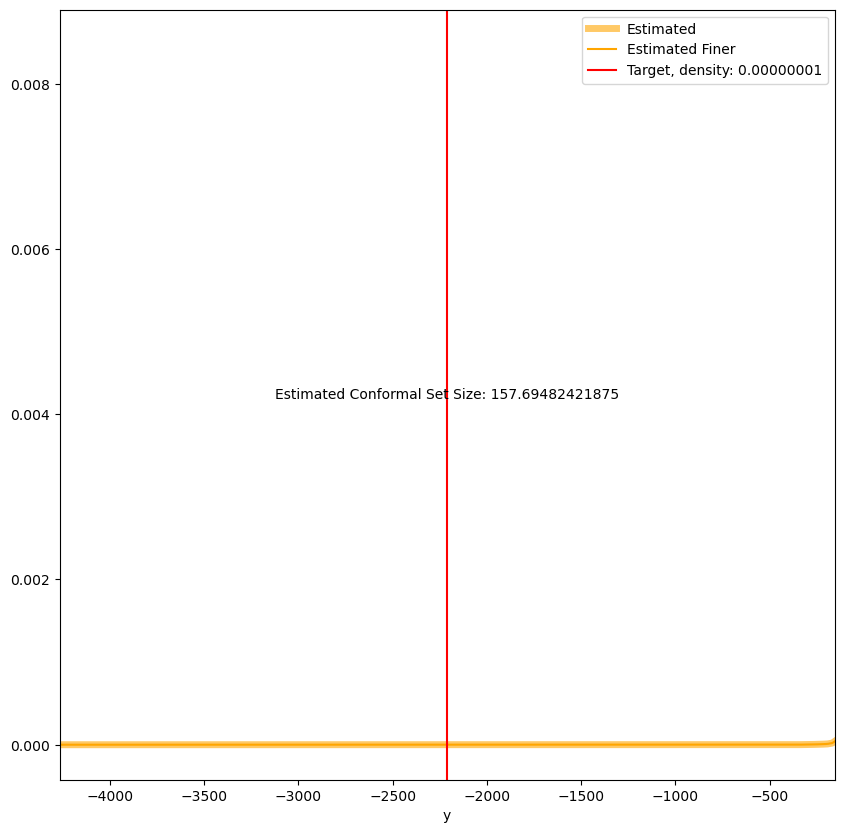

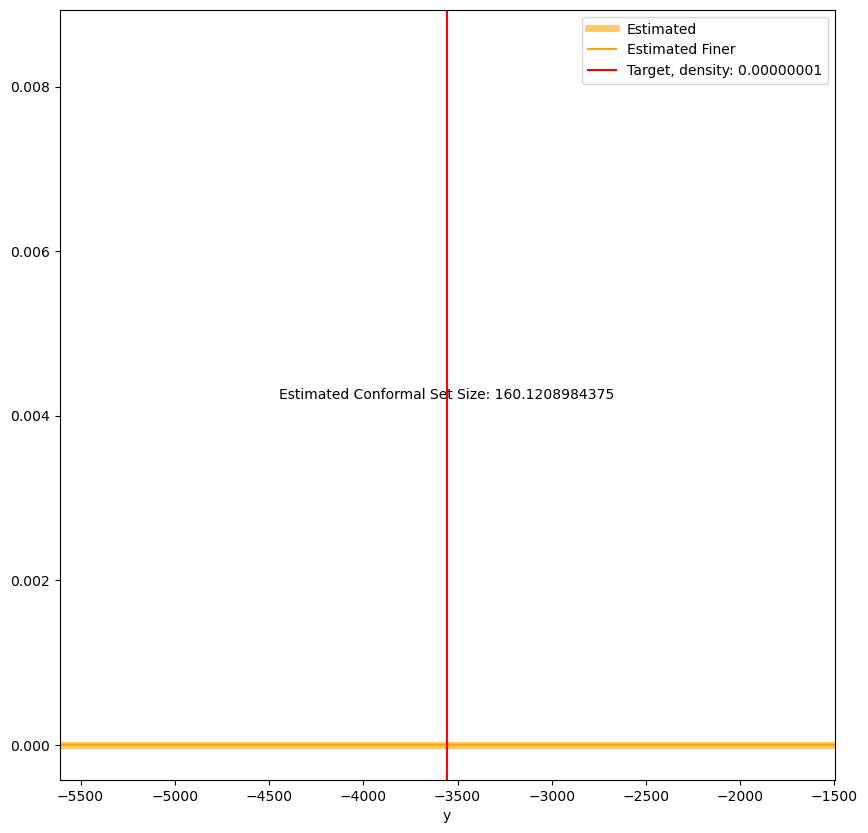

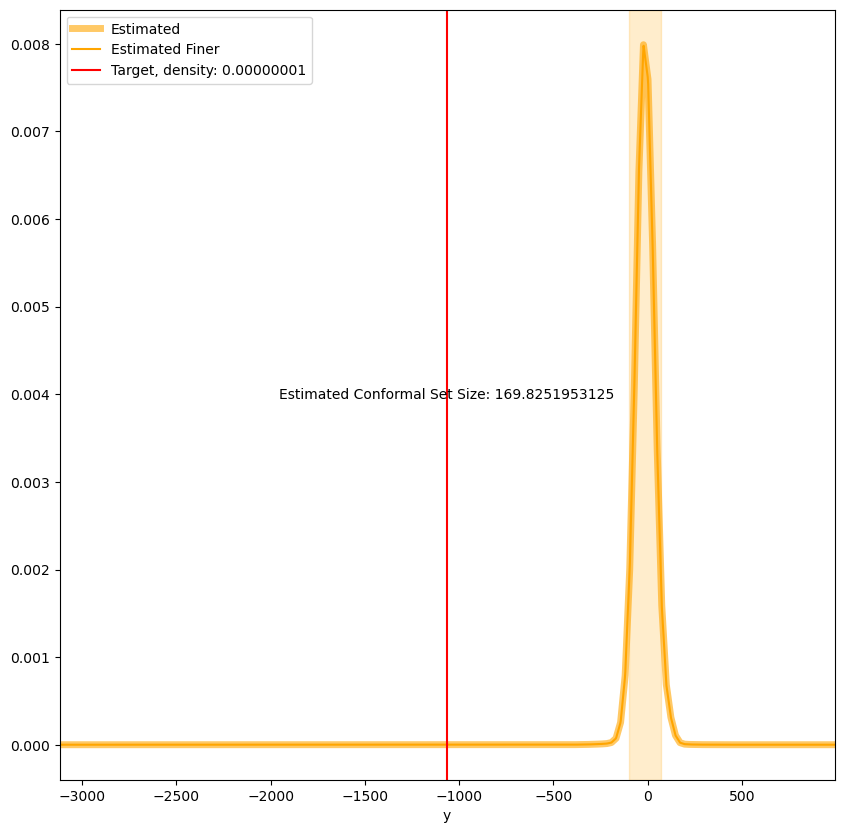

 57%|█████▋    | 48/84 [00:26<00:40,  1.12s/it]

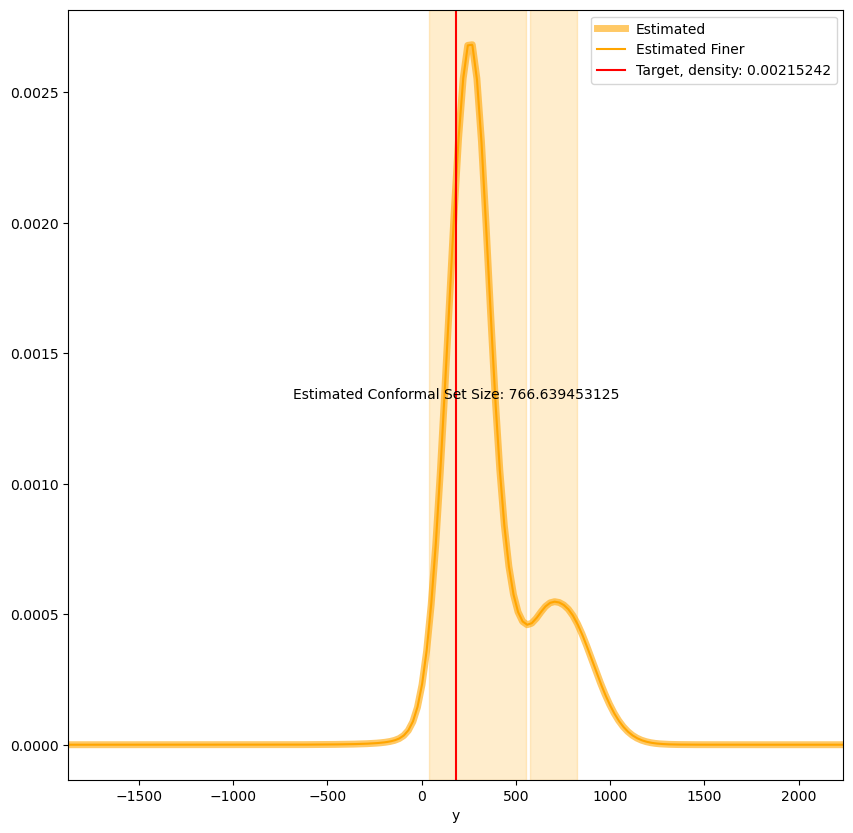

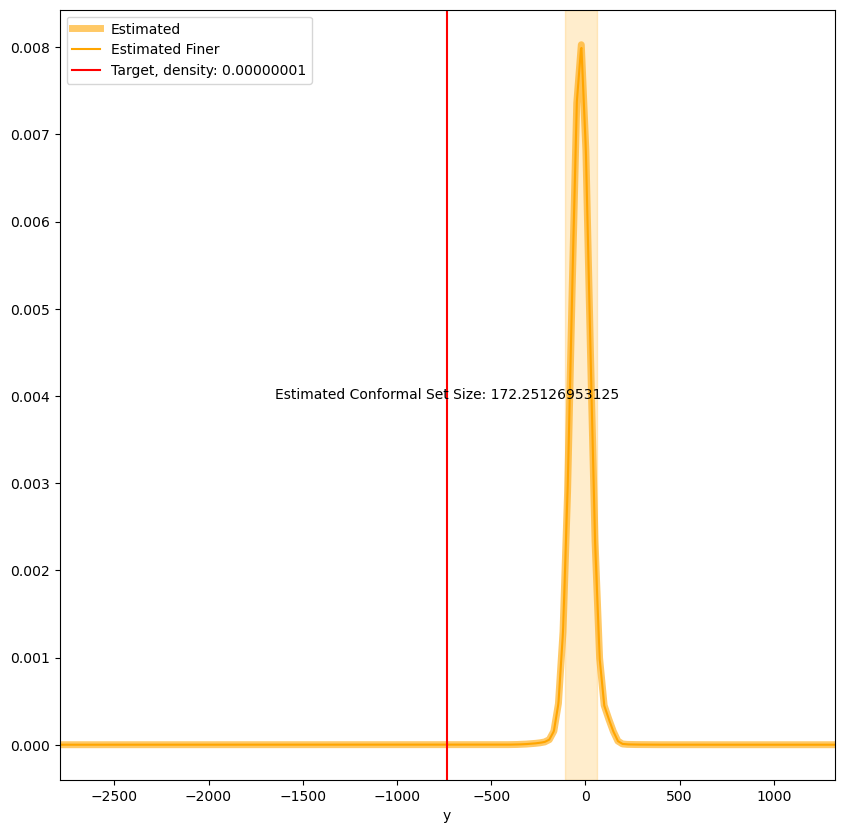

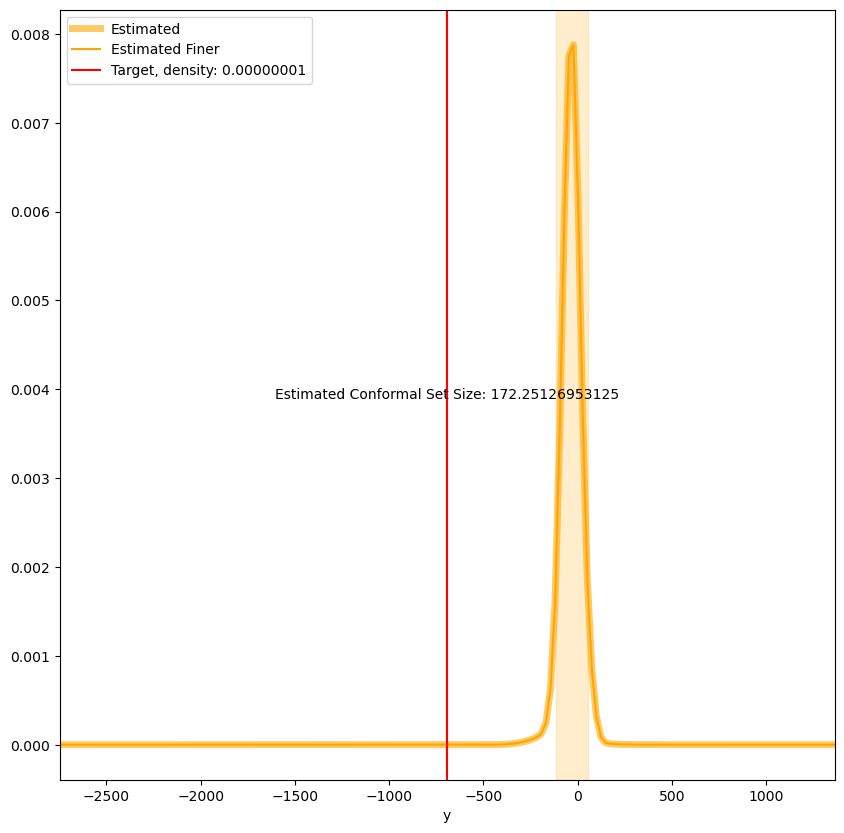

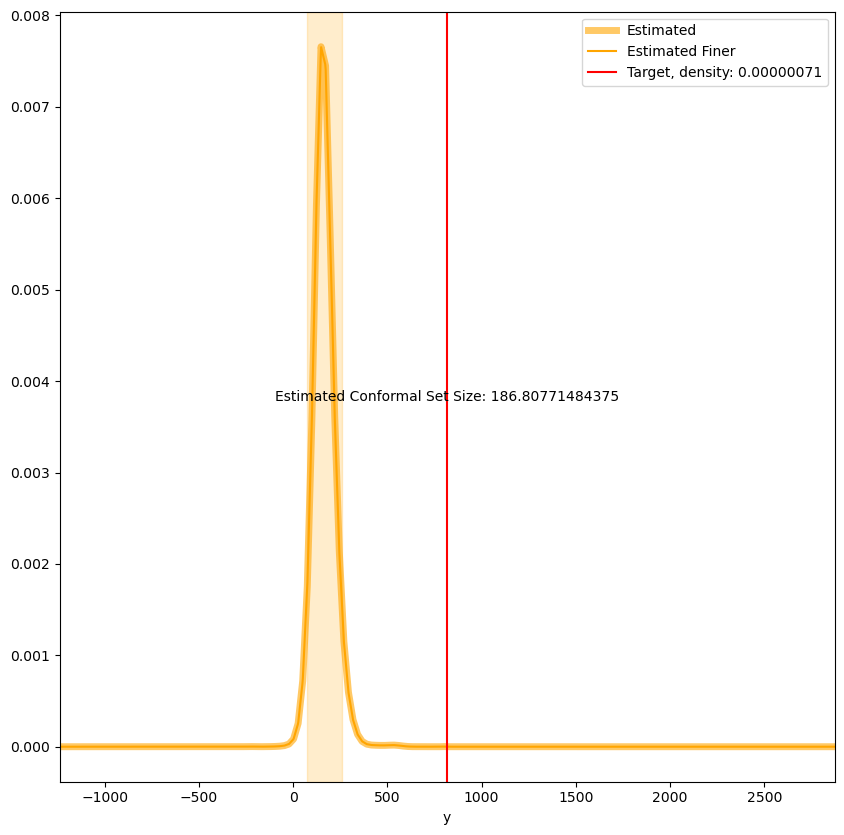

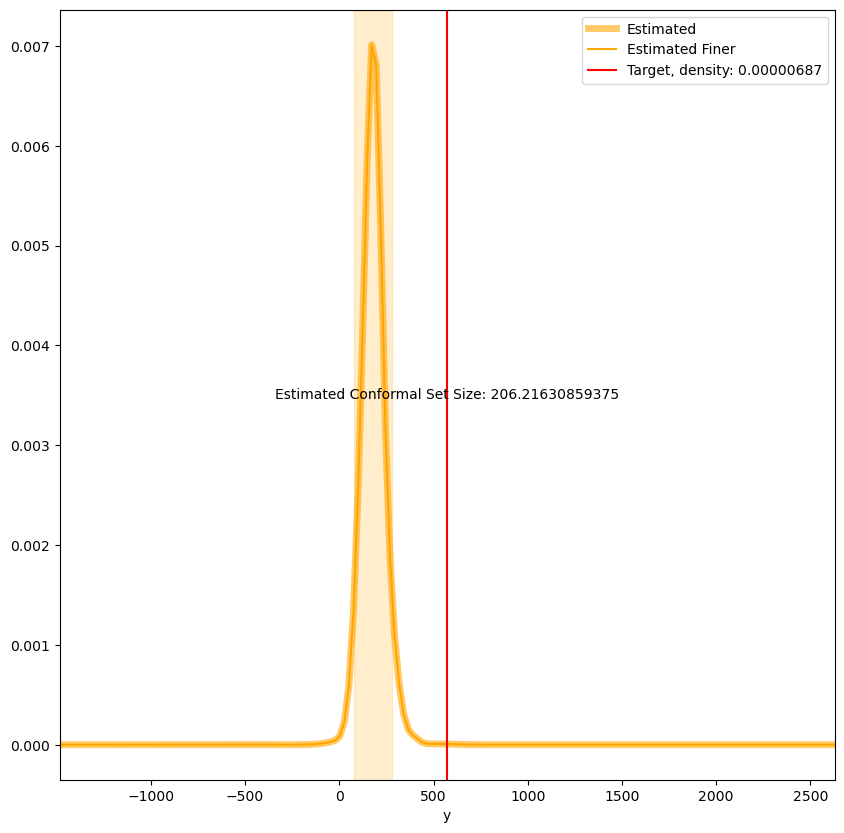

 63%|██████▎   | 53/84 [00:29<00:15,  2.04it/s]

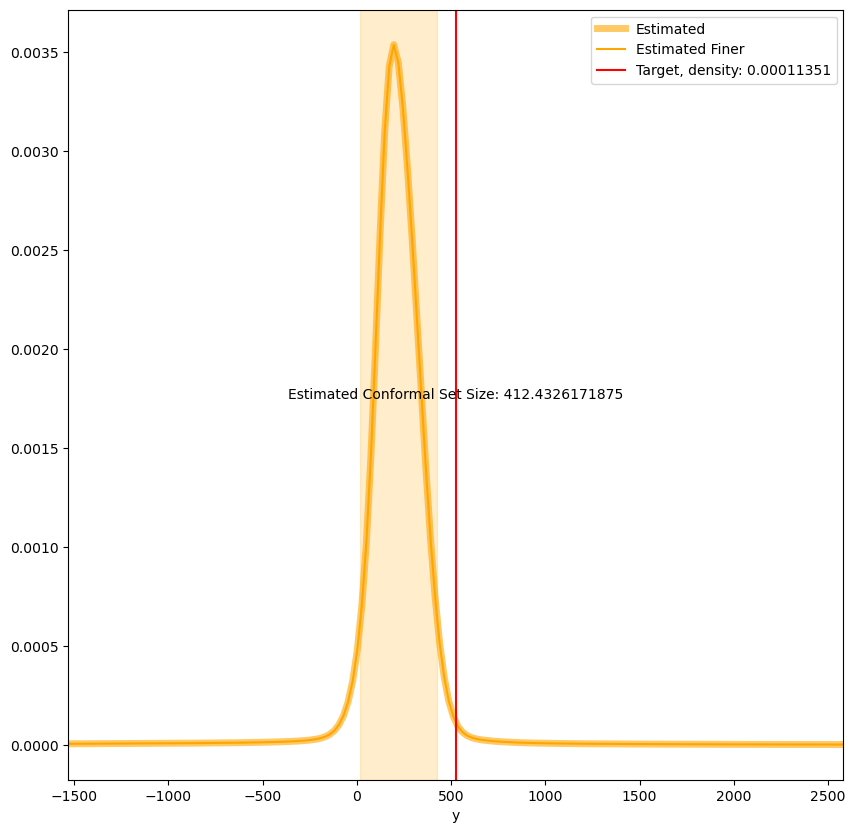

 64%|██████▍   | 54/84 [00:30<00:14,  2.10it/s]

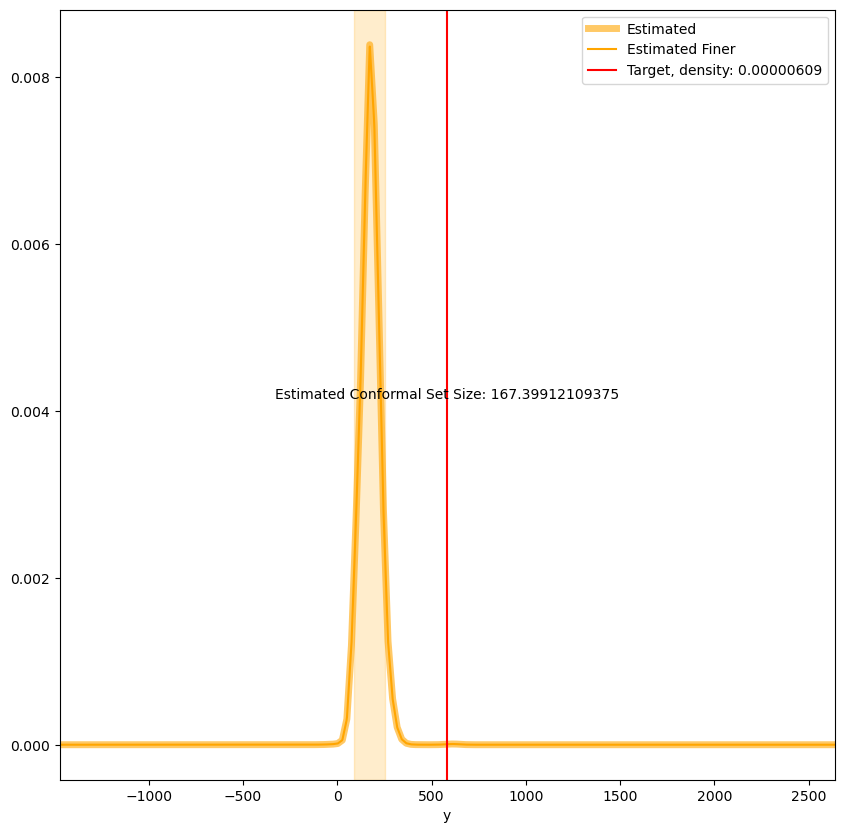

 65%|██████▌   | 55/84 [00:30<00:14,  1.97it/s]

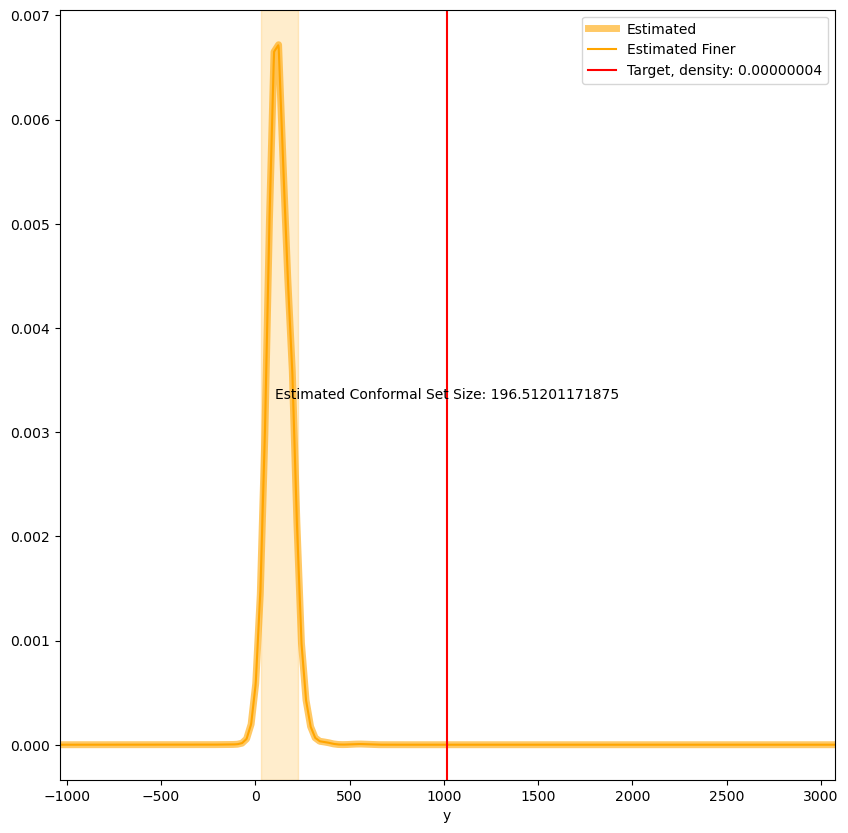

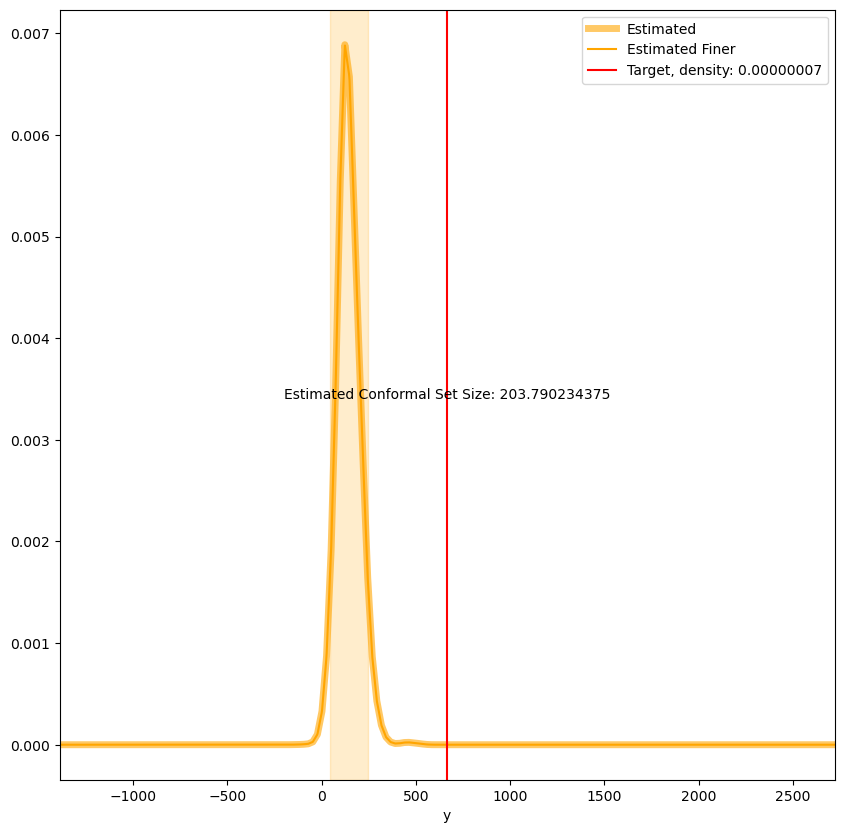

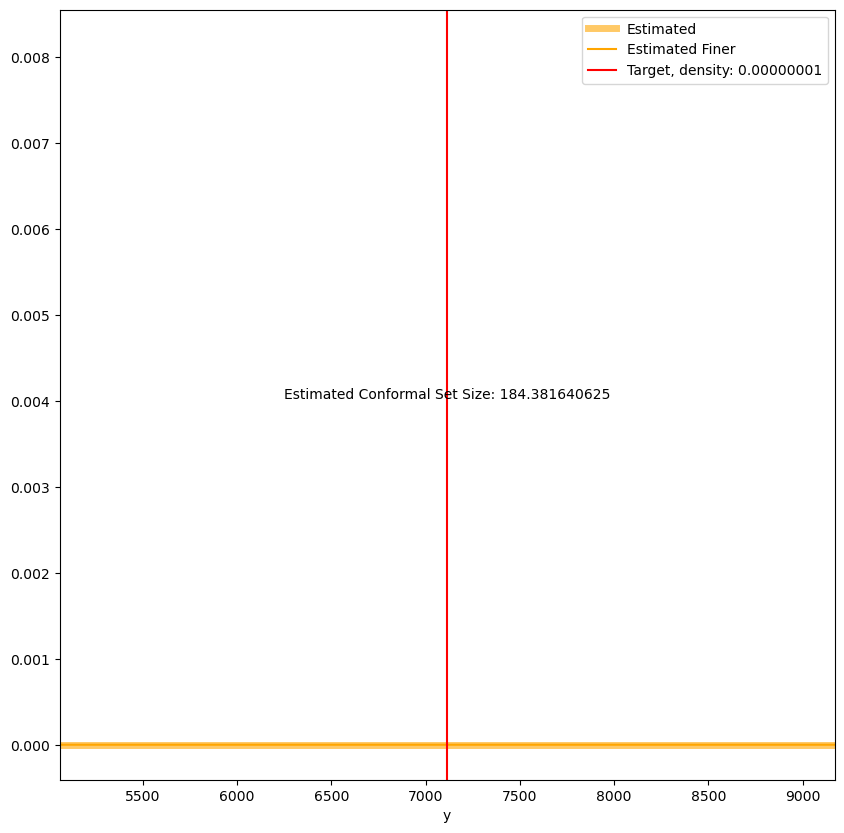

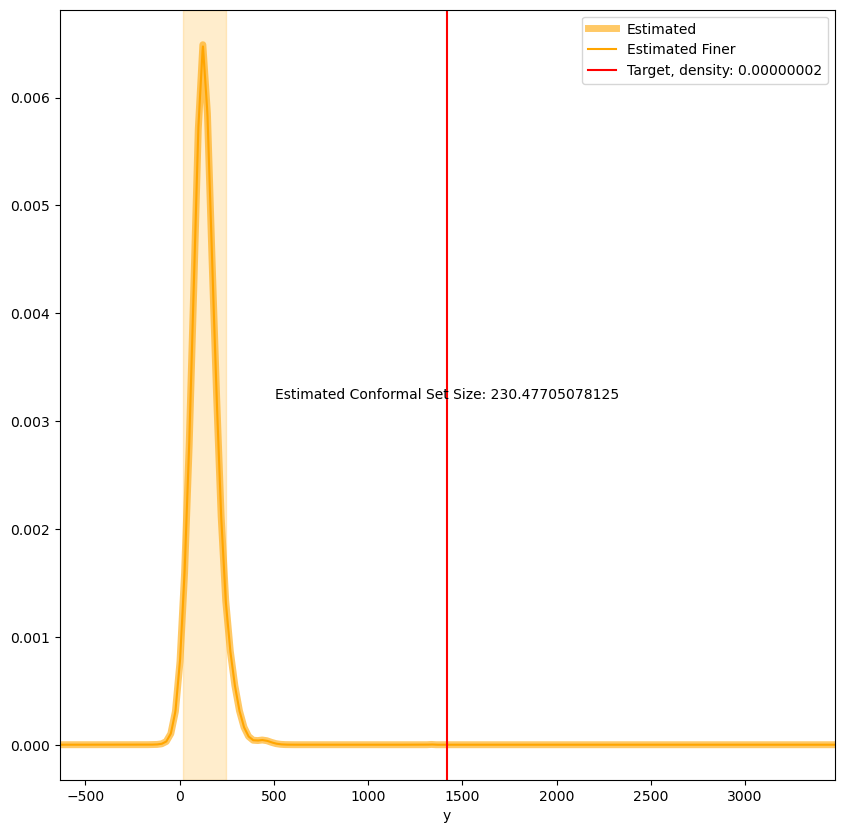

 71%|███████▏  | 60/84 [00:33<00:07,  3.26it/s]

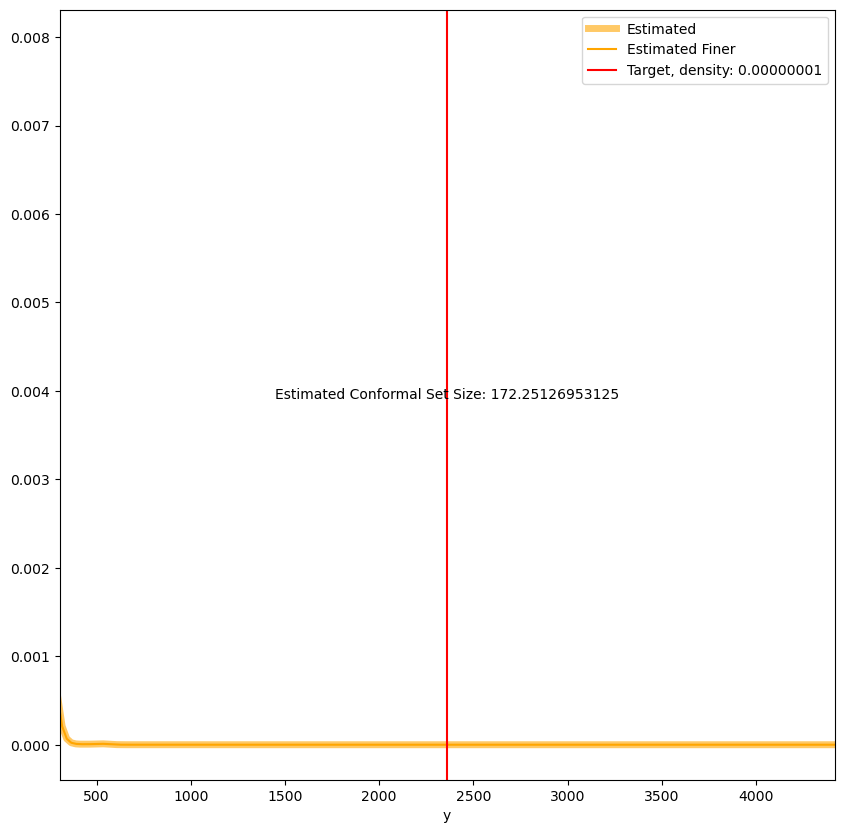

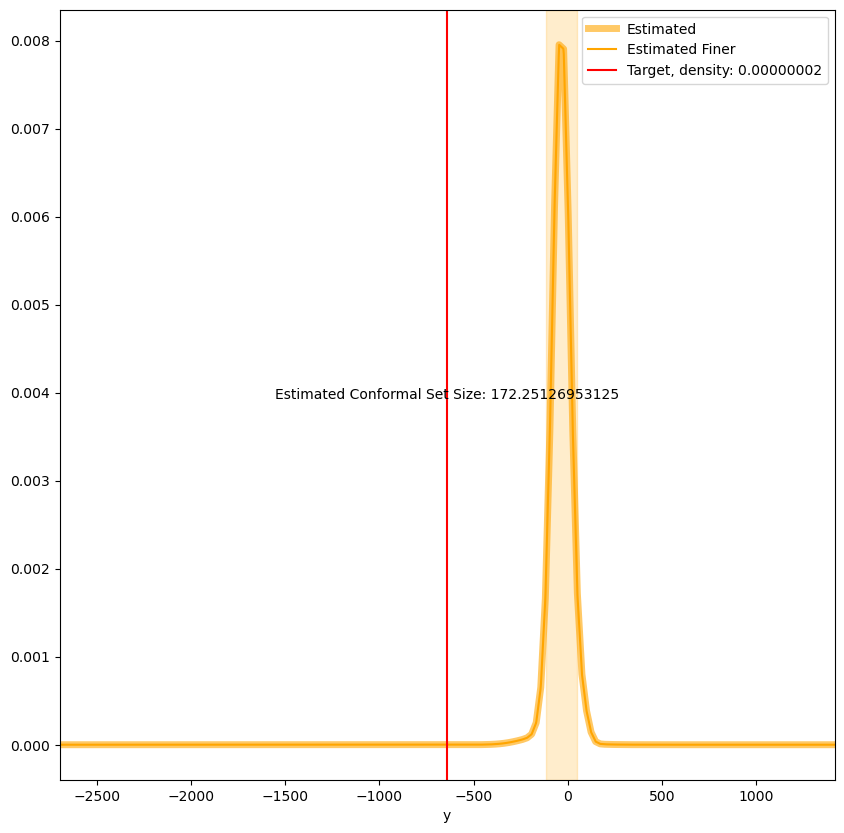

 73%|███████▎  | 61/84 [00:33<00:11,  2.04it/s]

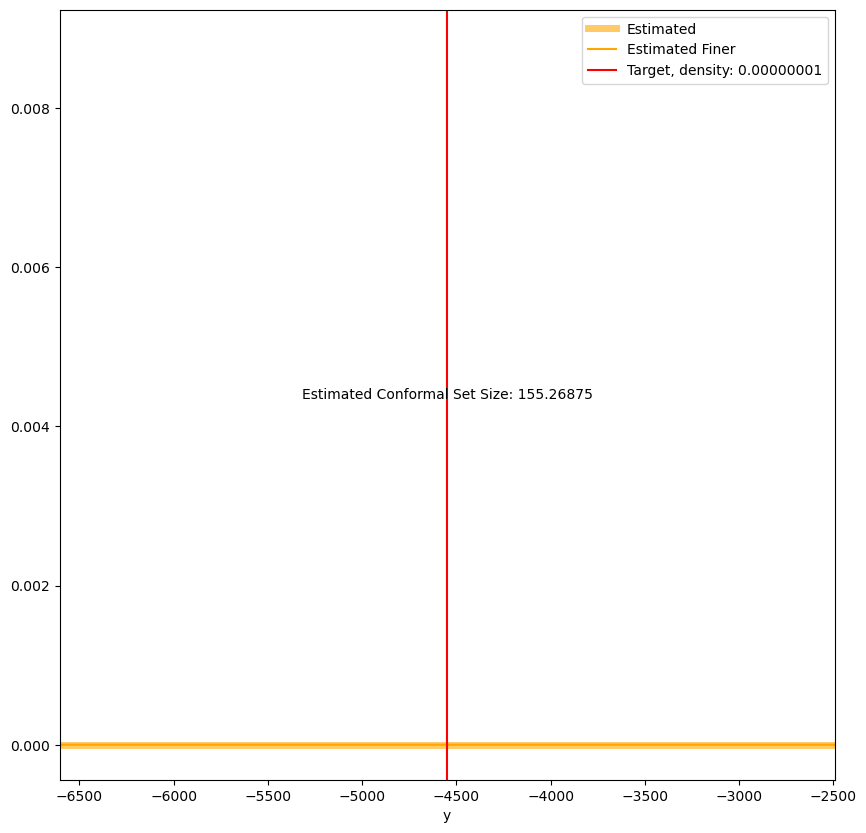

 77%|███████▋  | 65/84 [00:34<00:04,  3.90it/s]

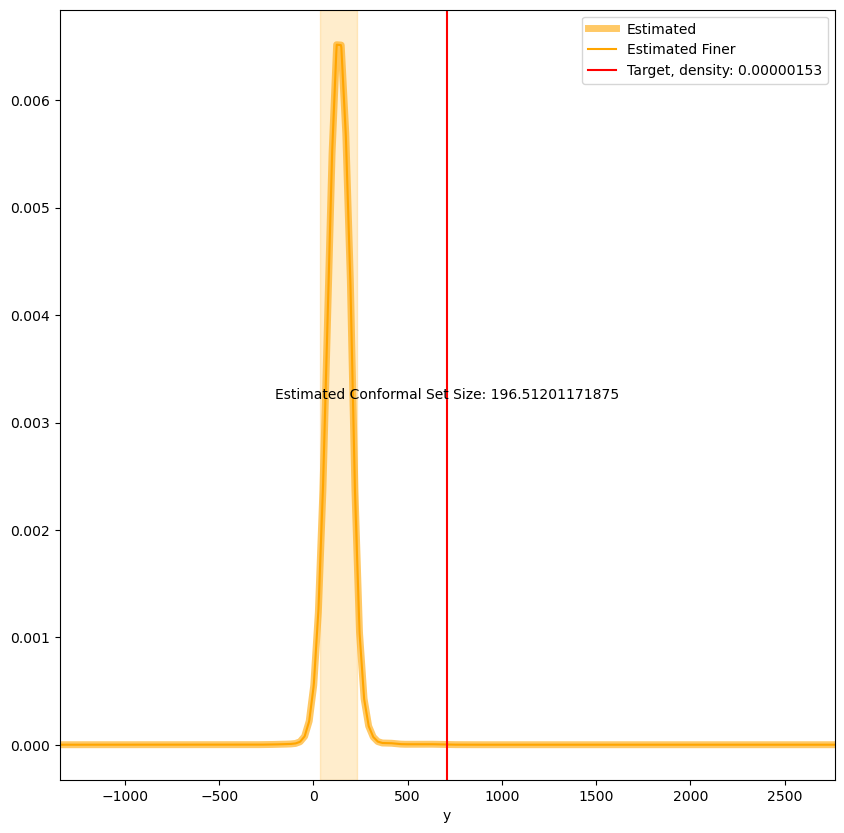

 79%|███████▊  | 66/84 [00:35<00:06,  2.79it/s]

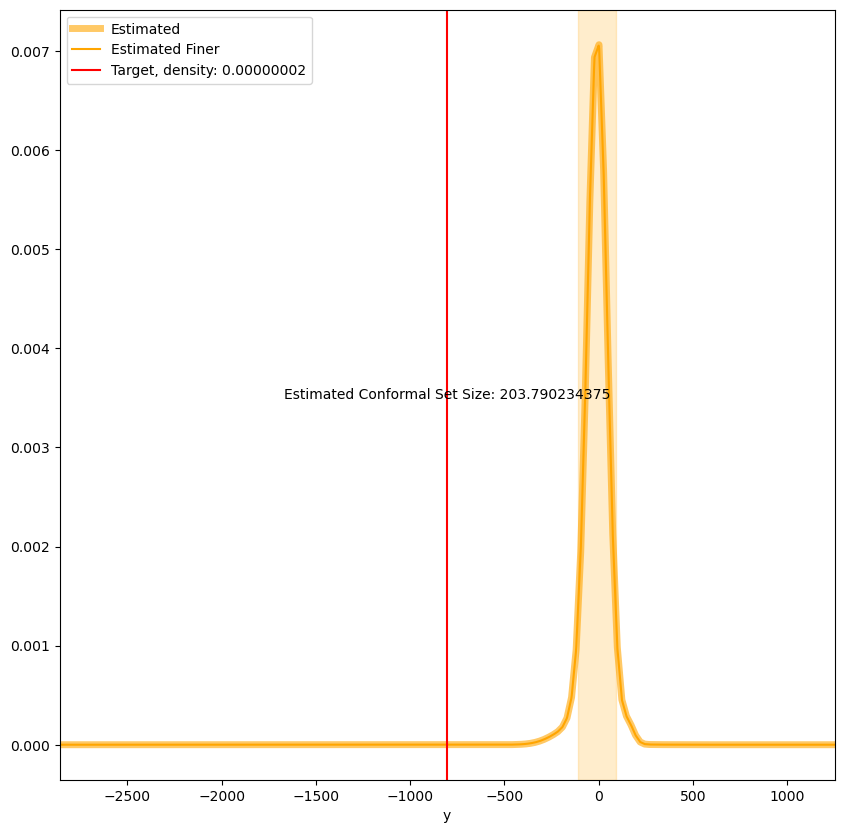

 80%|███████▉  | 67/84 [00:36<00:07,  2.31it/s]

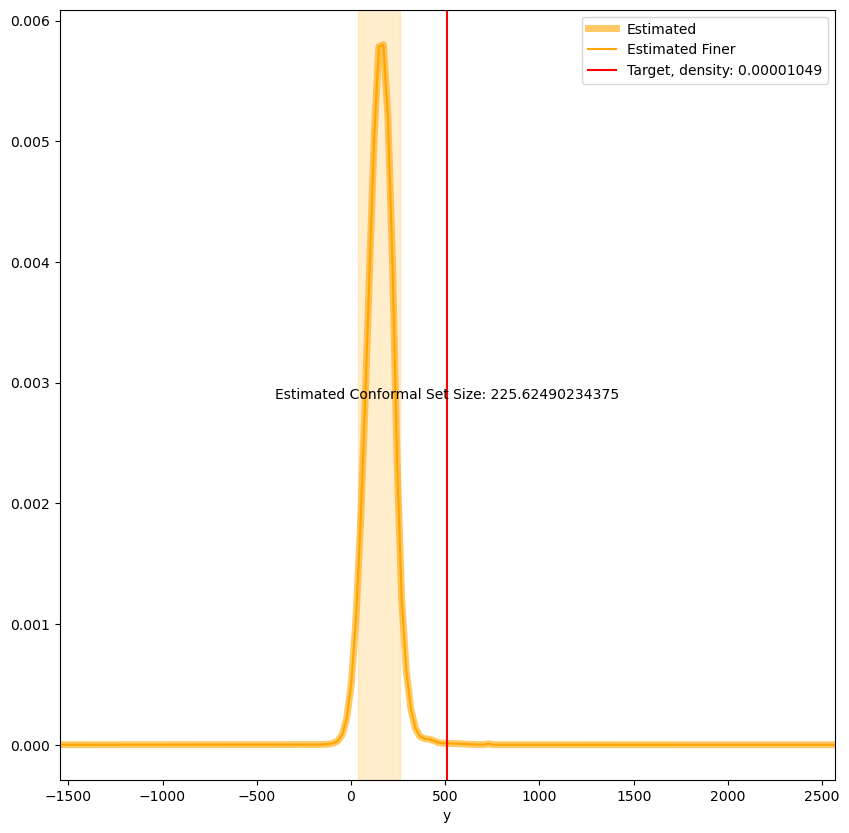

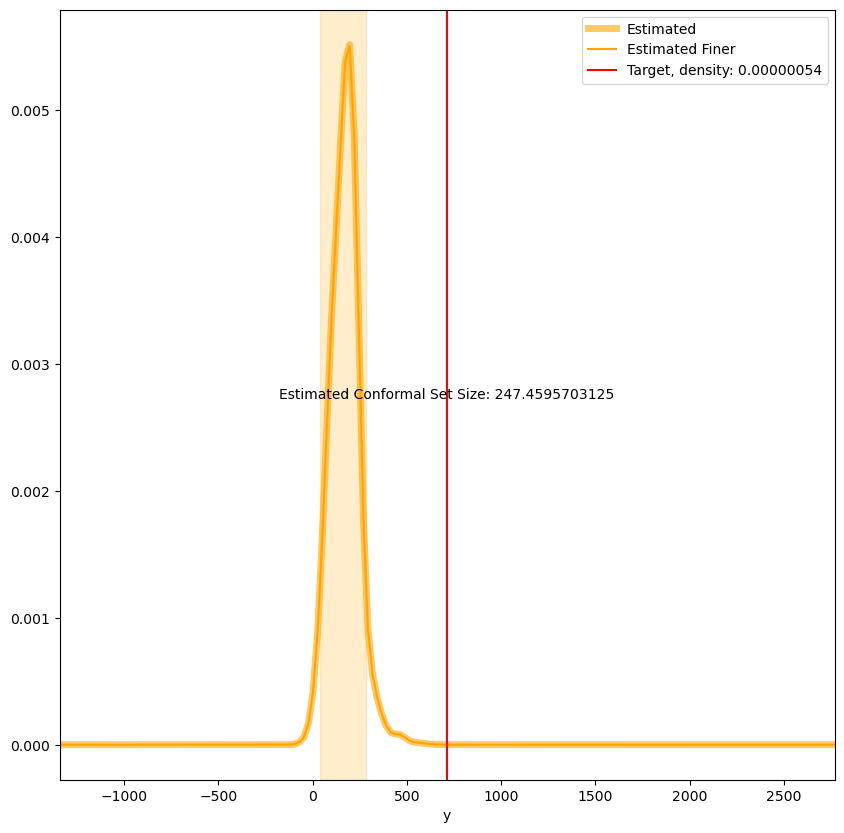

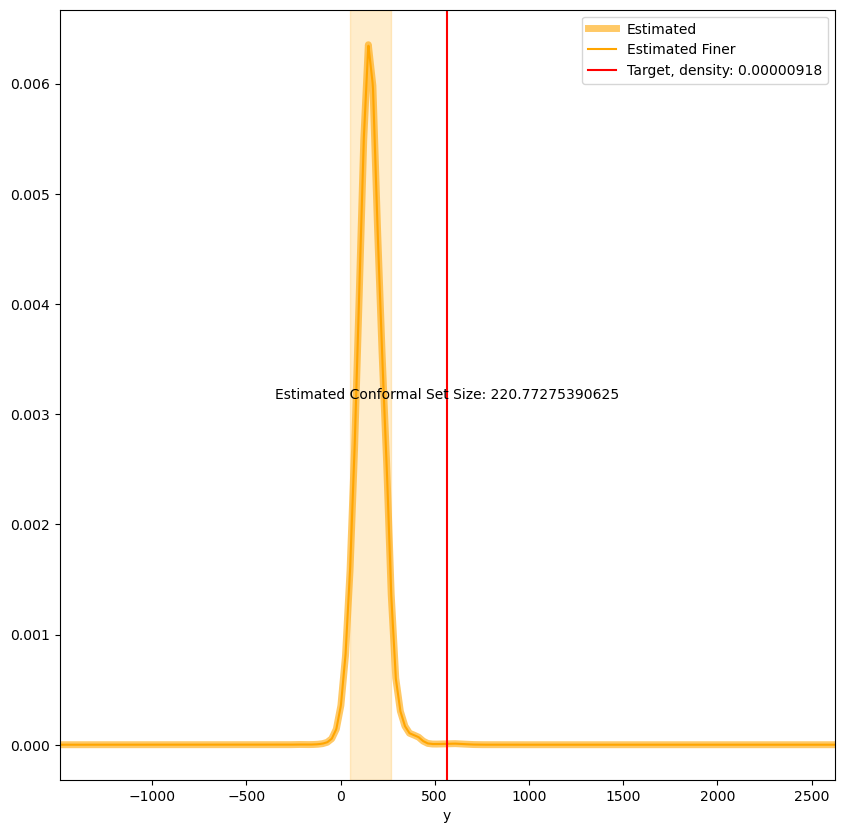

 82%|████████▏ | 69/84 [00:37<00:08,  1.73it/s]

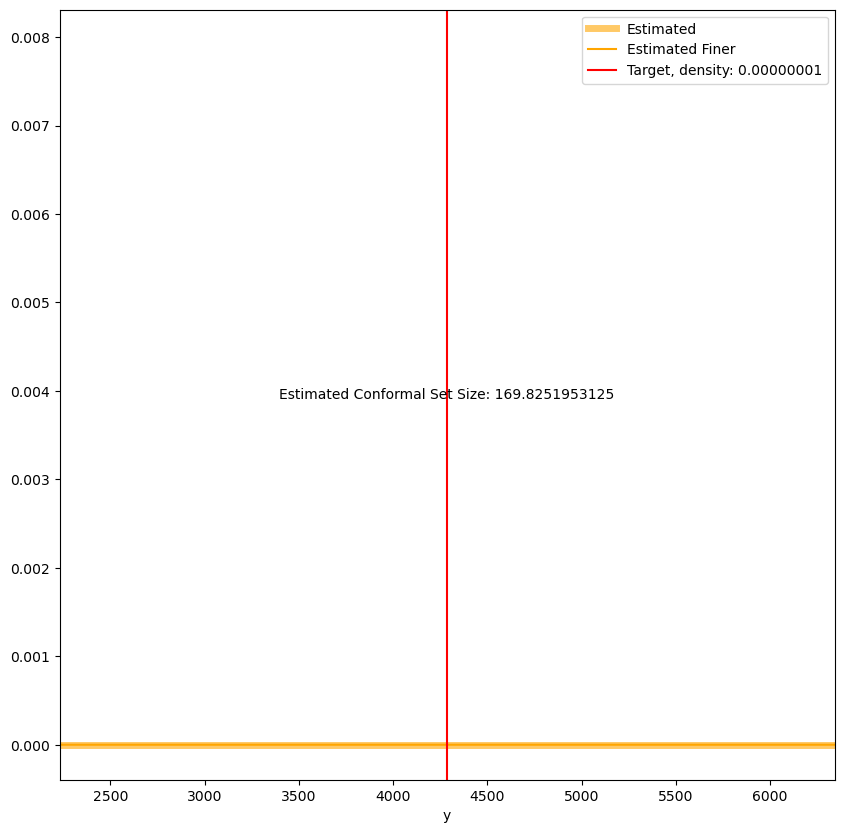

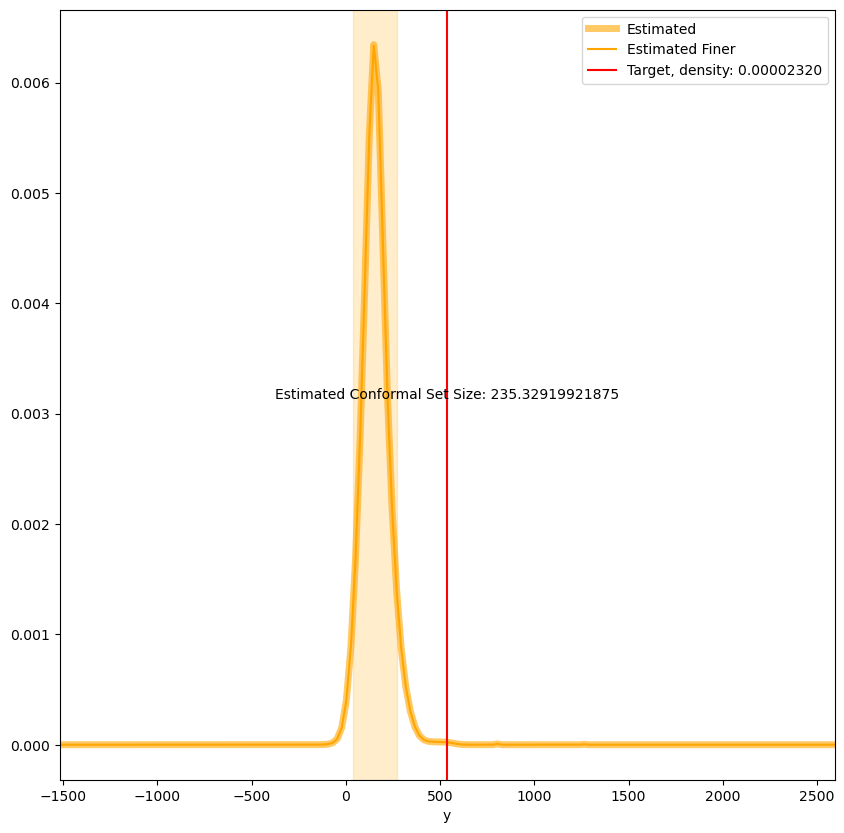

 85%|████████▍ | 71/84 [00:38<00:06,  1.95it/s]

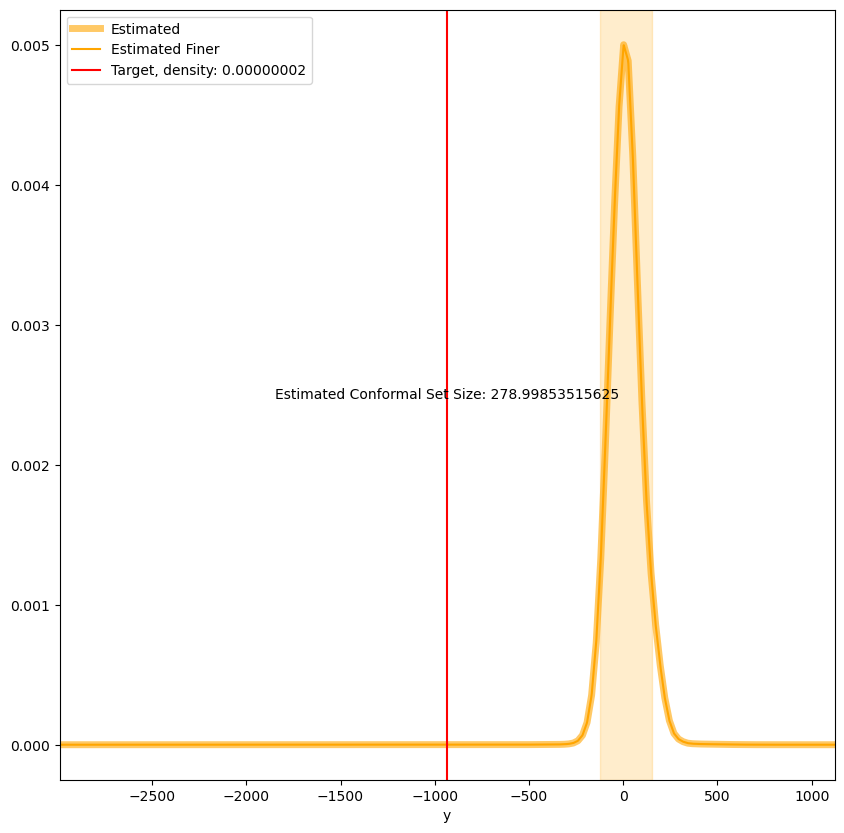

 87%|████████▋ | 73/84 [00:39<00:04,  2.37it/s]

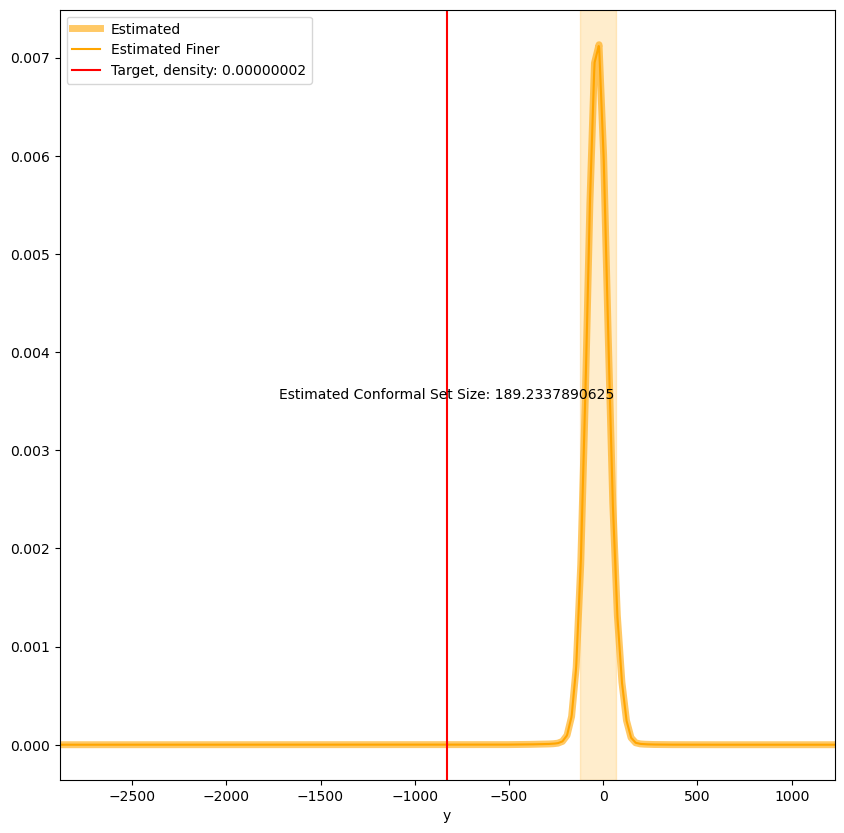

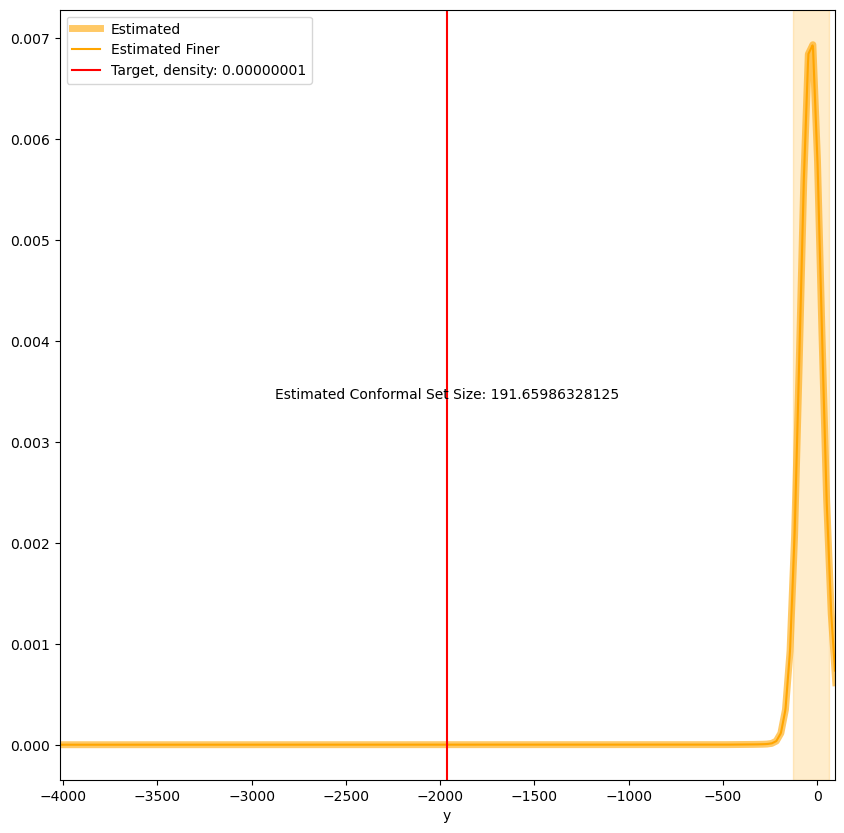

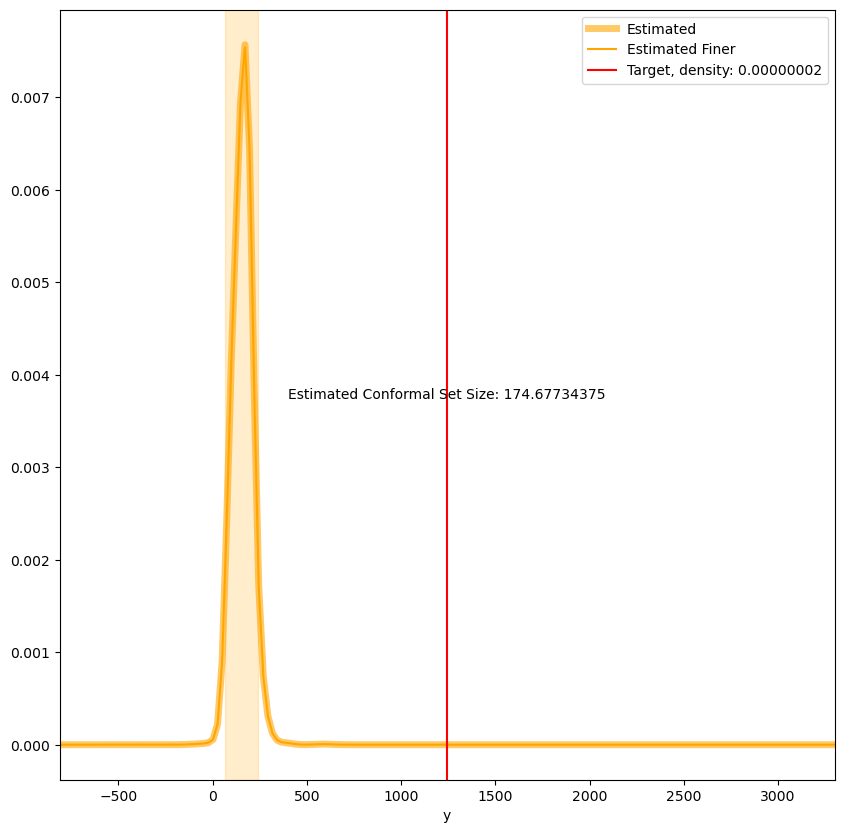

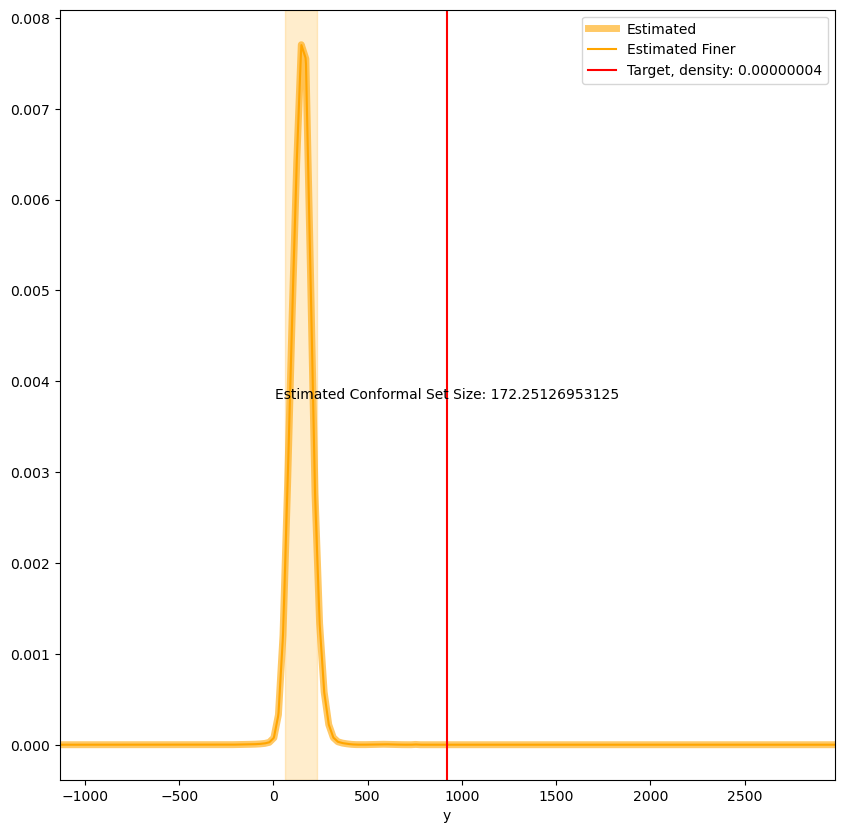

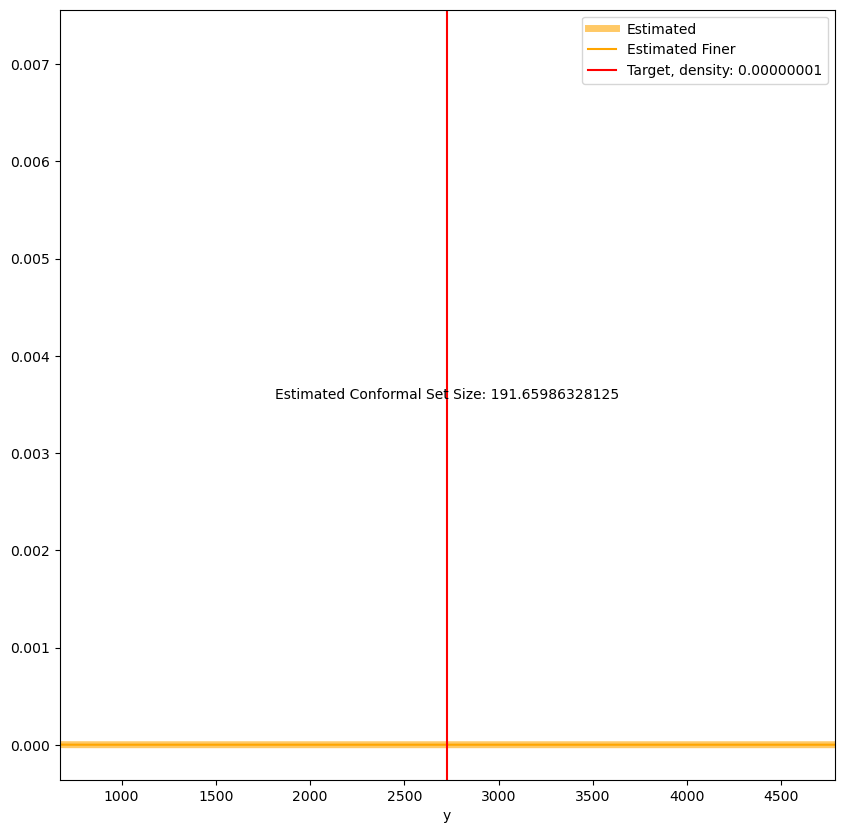

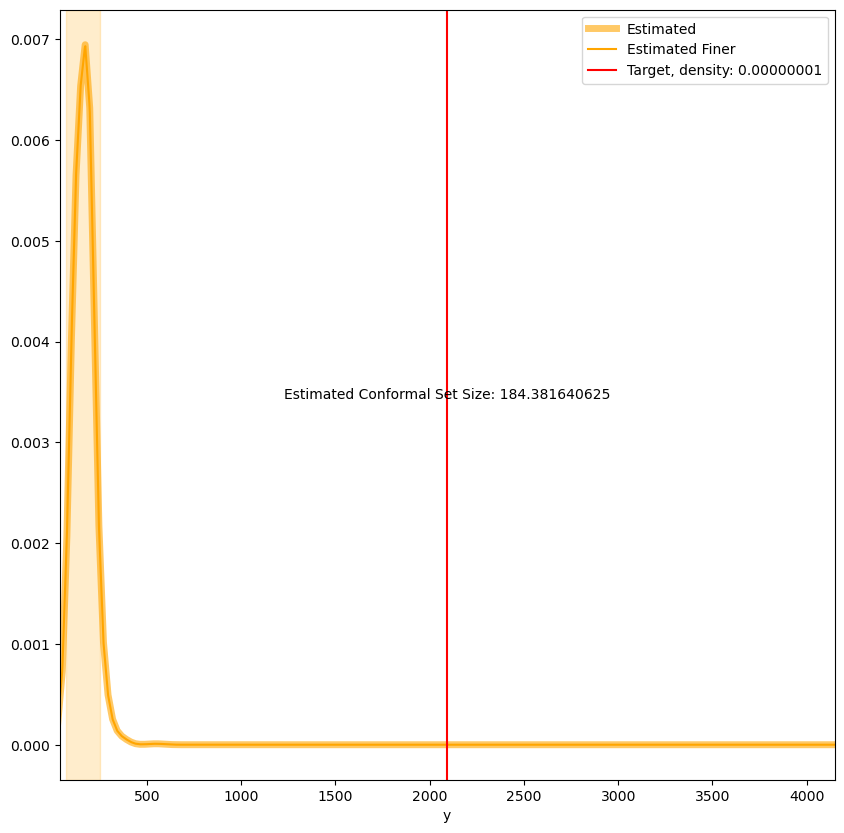

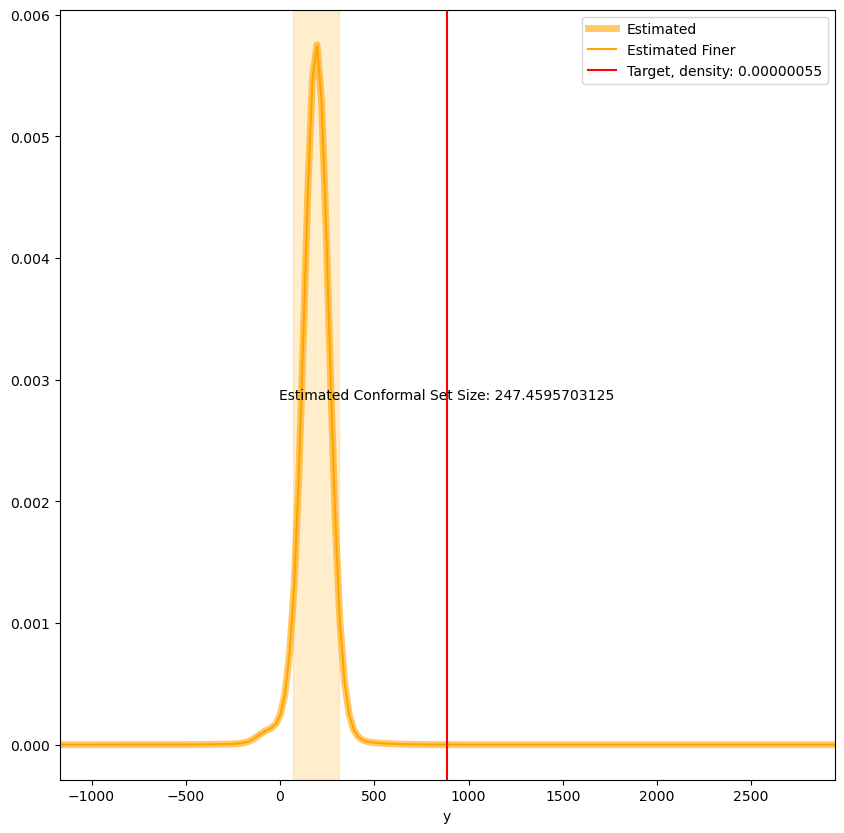

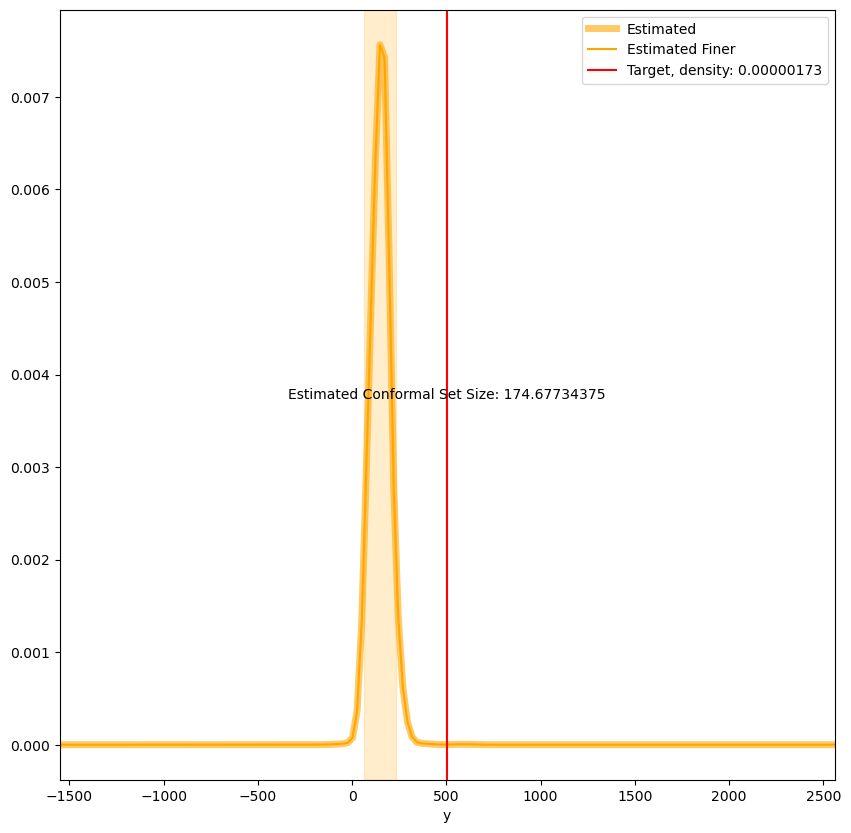

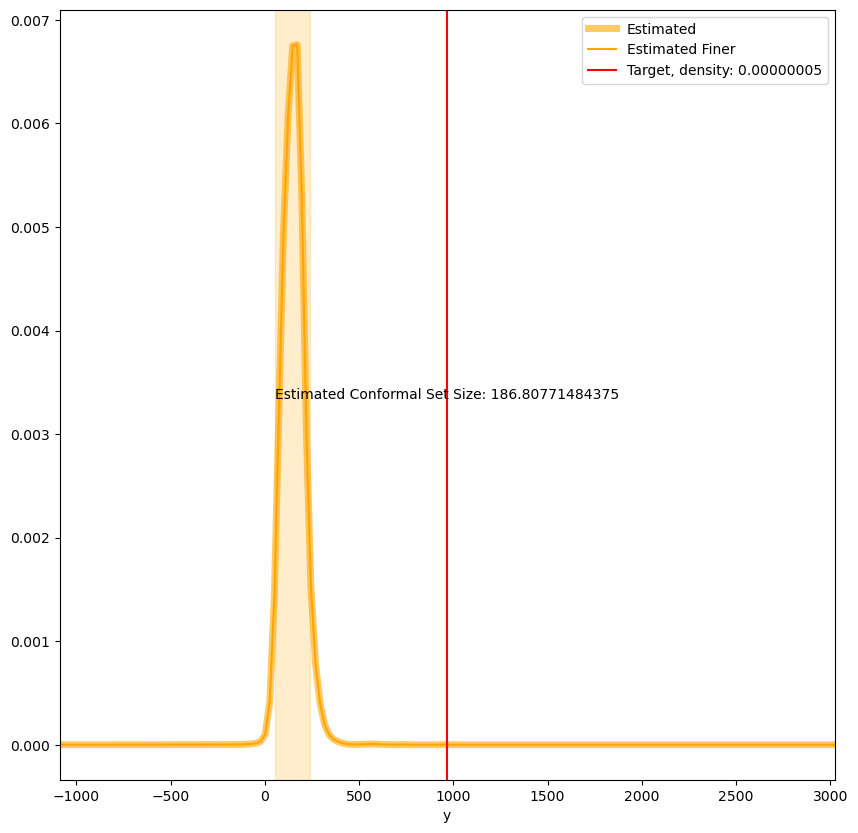

 88%|████████▊ | 74/84 [00:43<00:15,  1.57s/it]

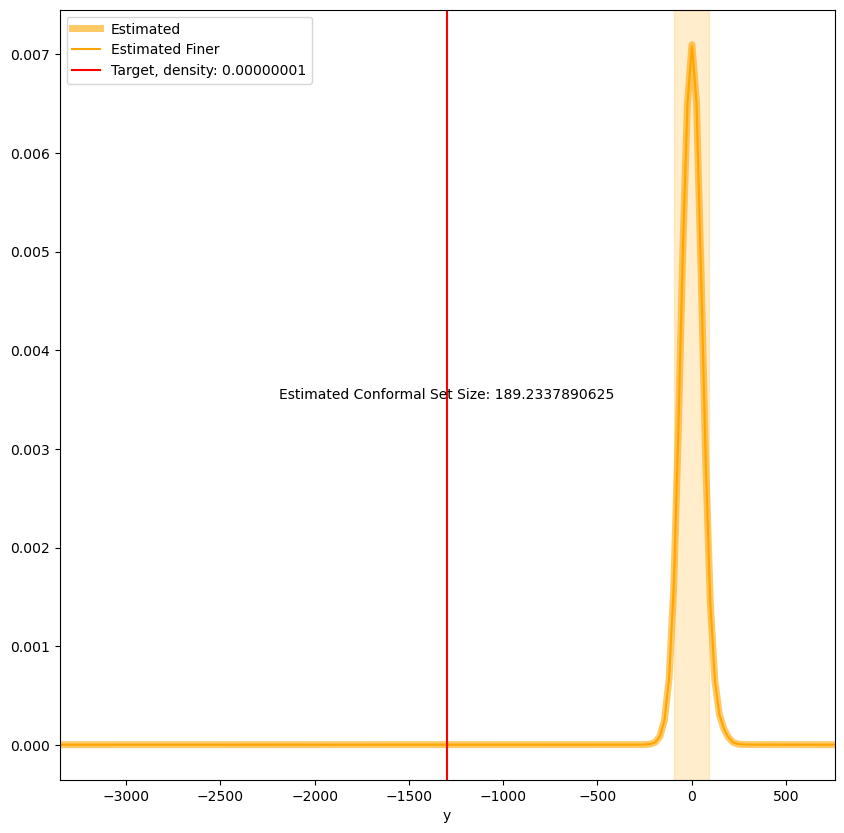

 89%|████████▉ | 75/84 [00:44<00:11,  1.30s/it]

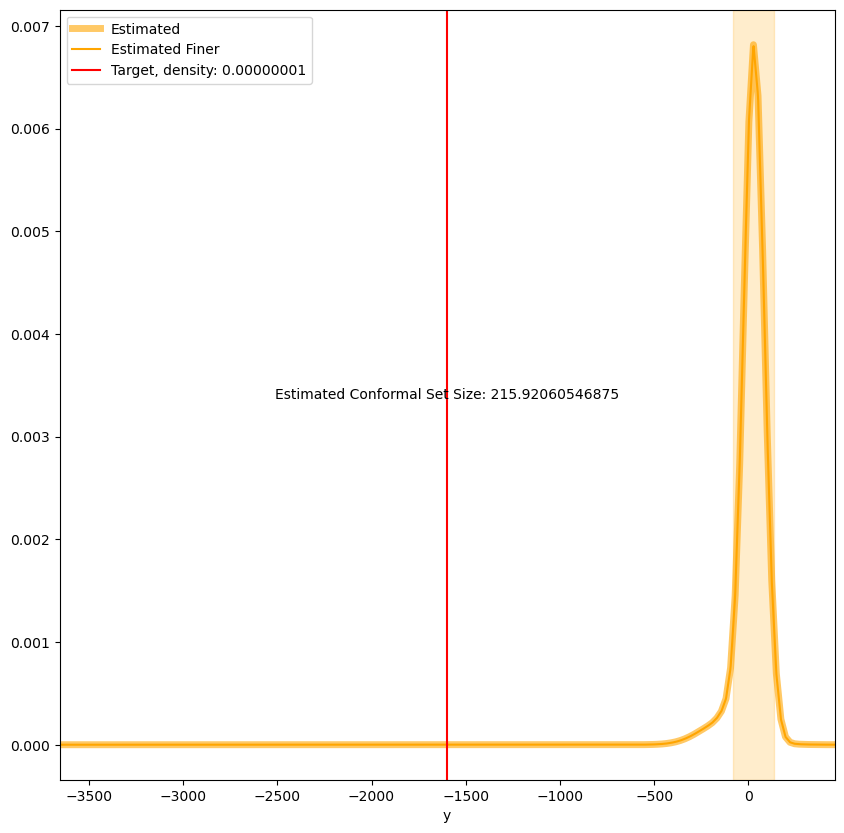

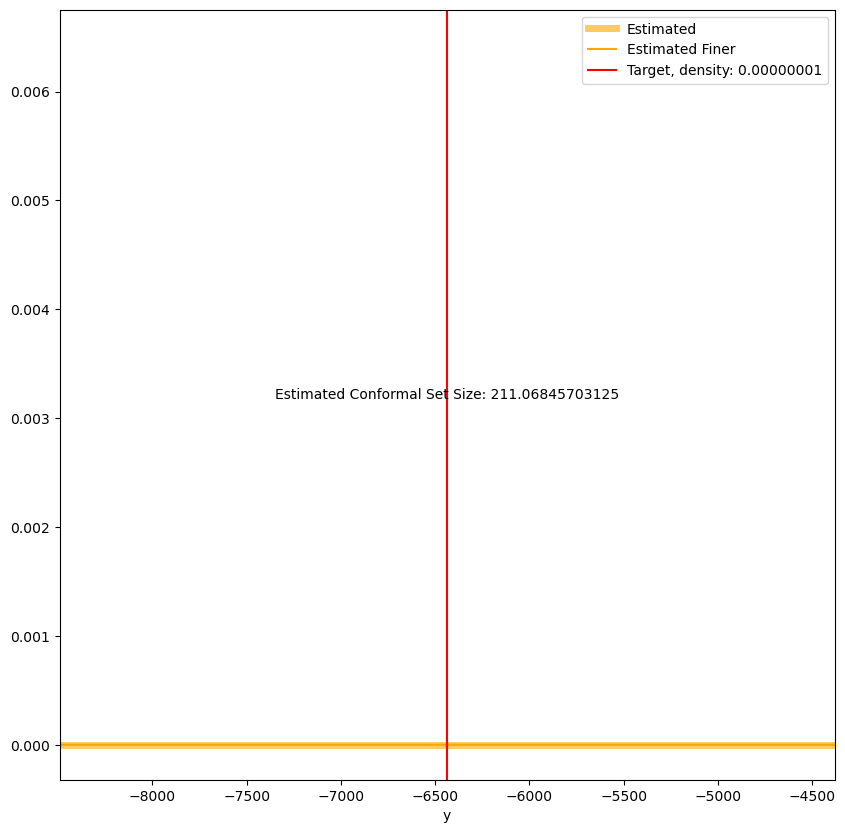

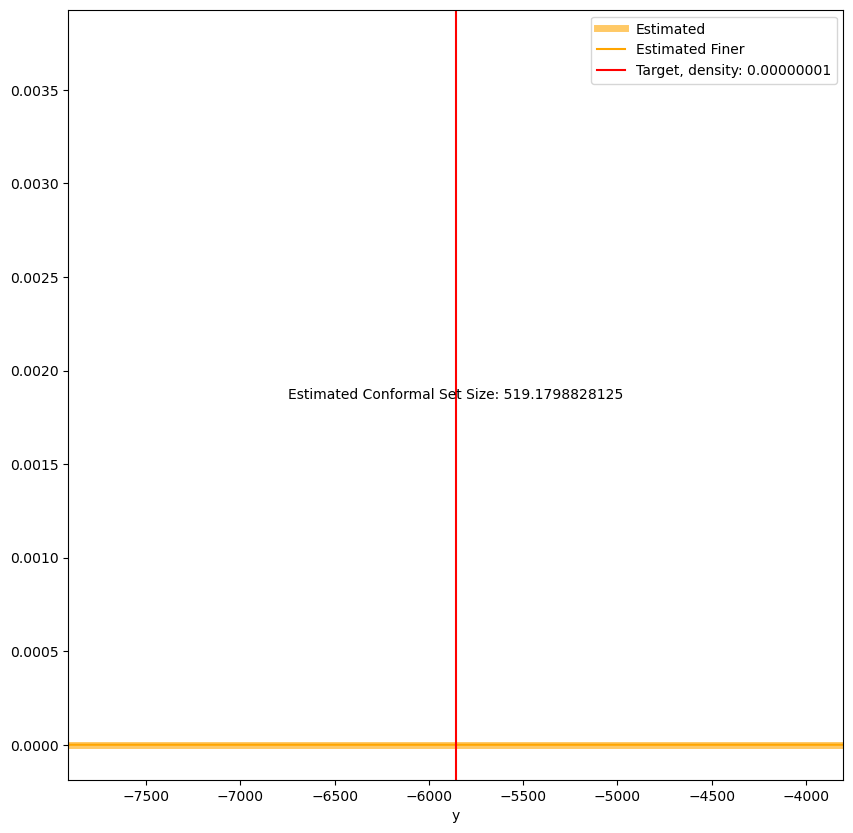

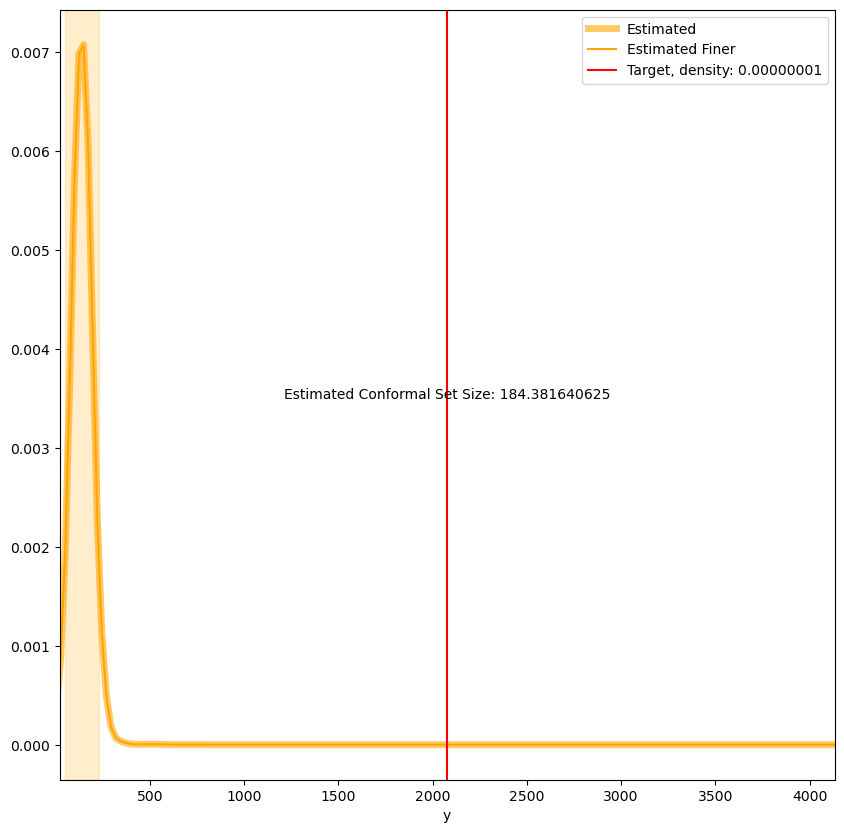

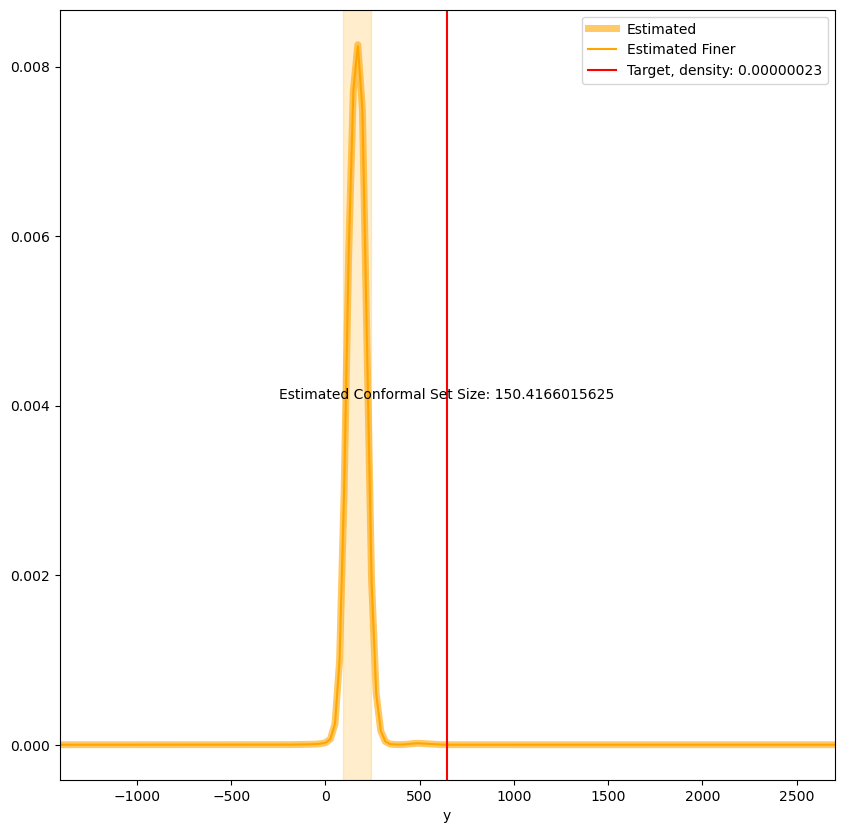

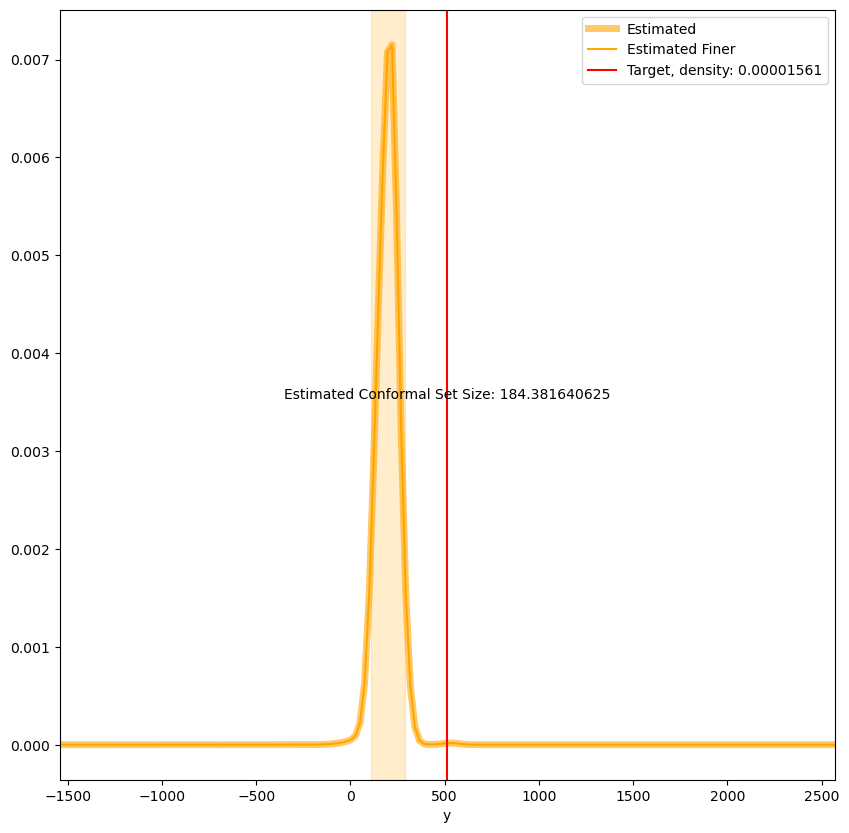

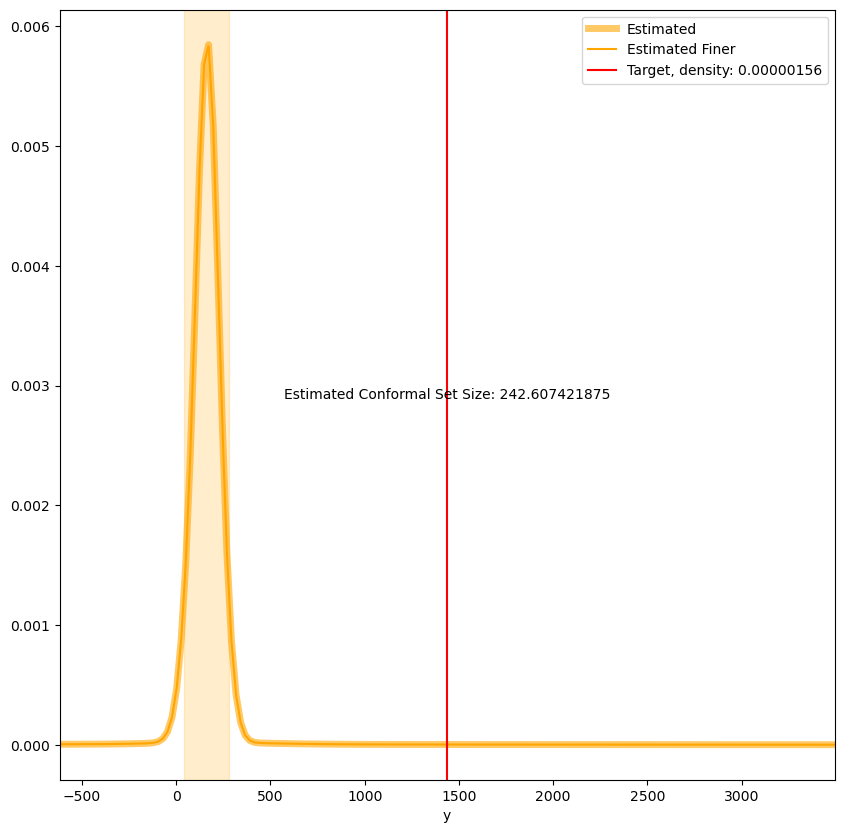

 90%|█████████ | 76/84 [00:47<00:14,  1.86s/it]

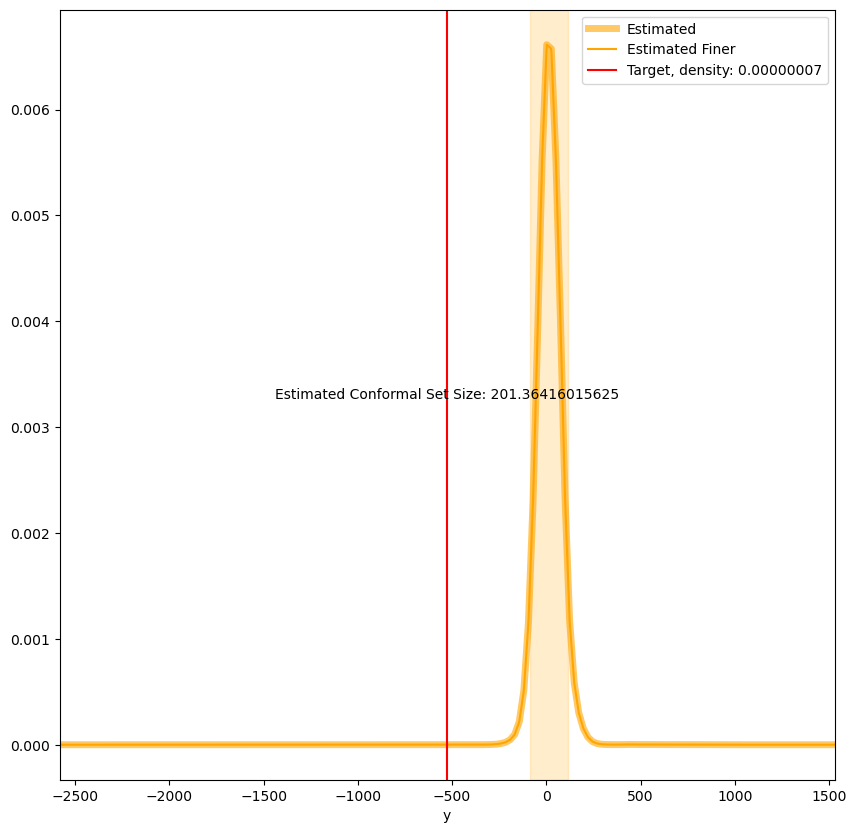

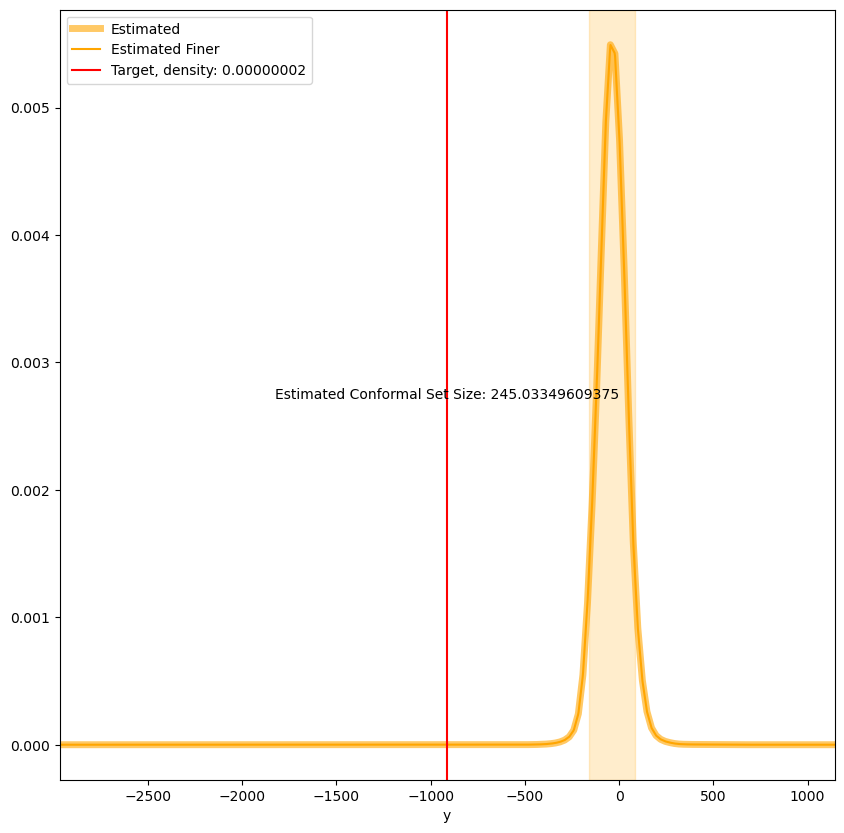

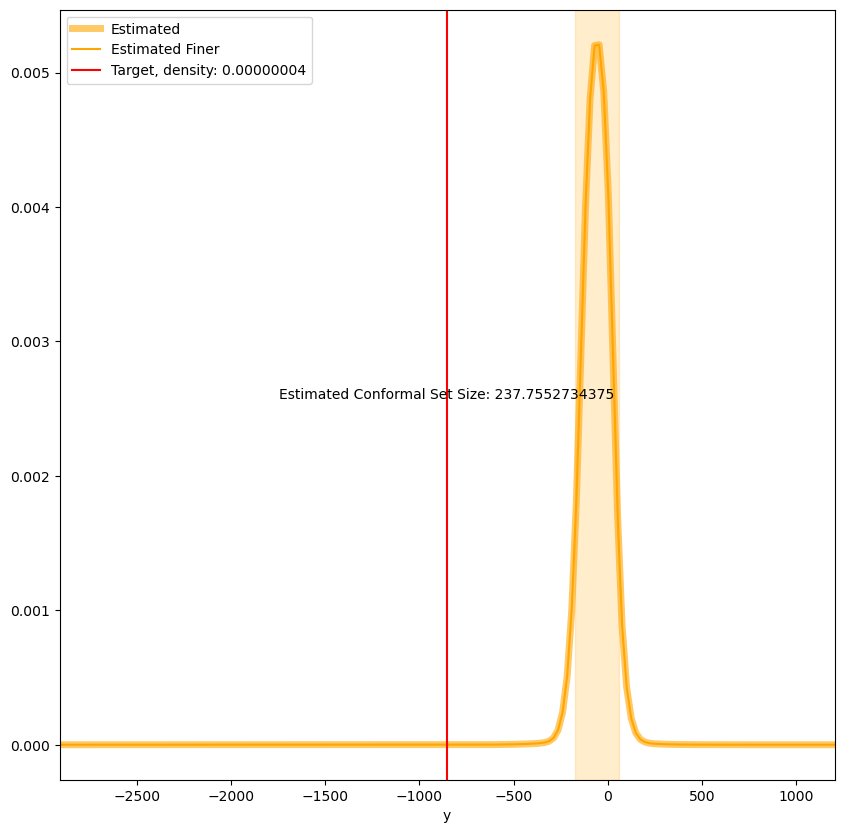

 92%|█████████▏| 77/84 [00:49<00:12,  1.73s/it]

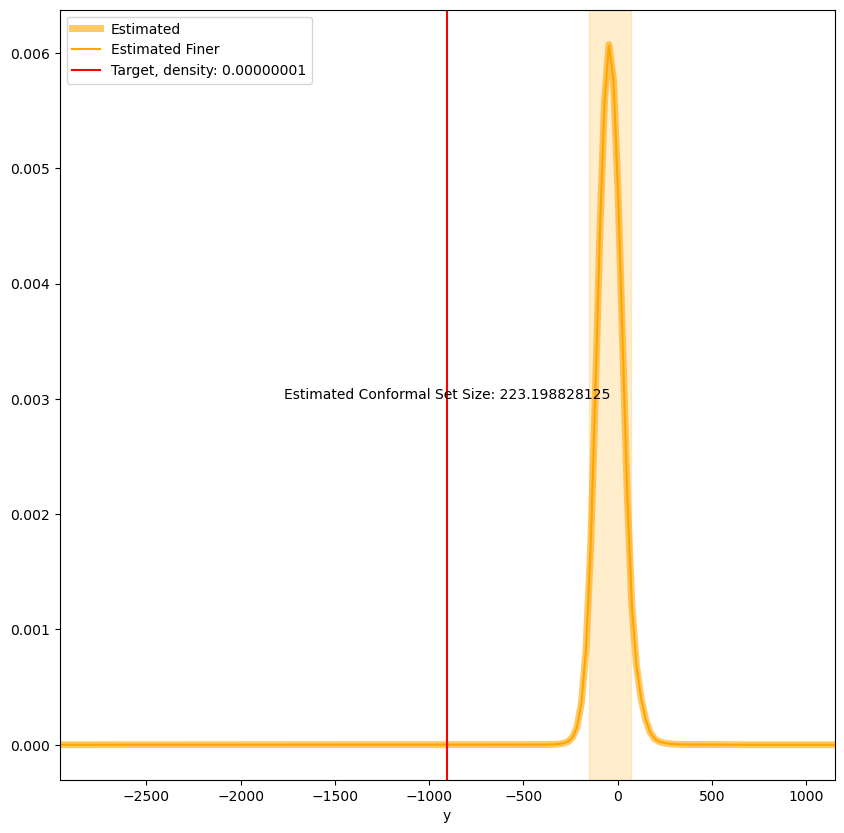

 93%|█████████▎| 78/84 [00:49<00:08,  1.41s/it]

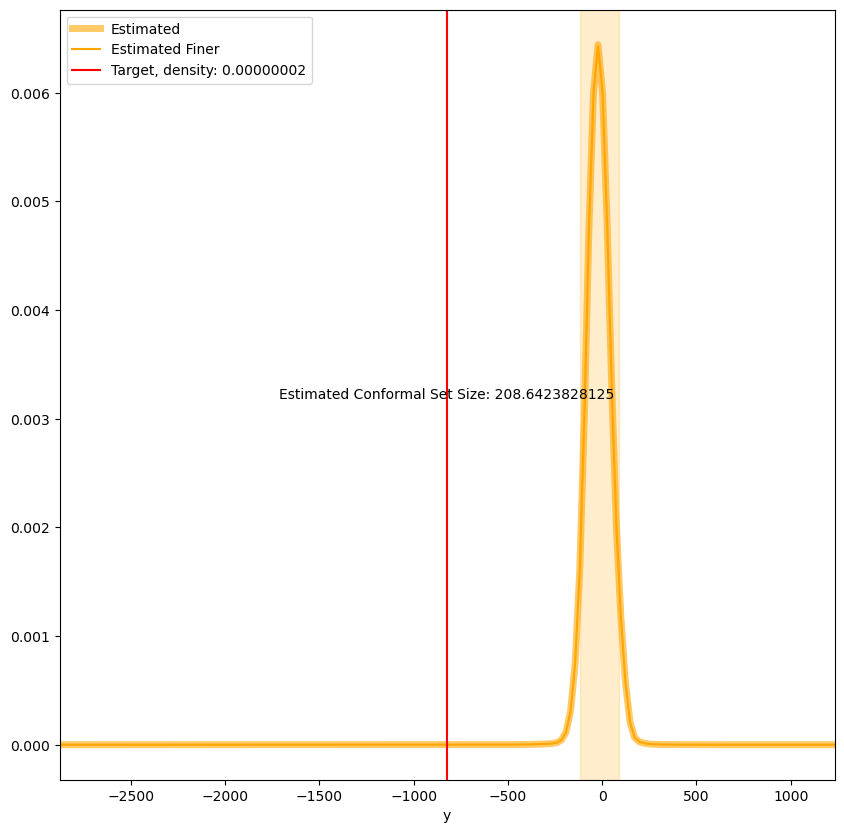

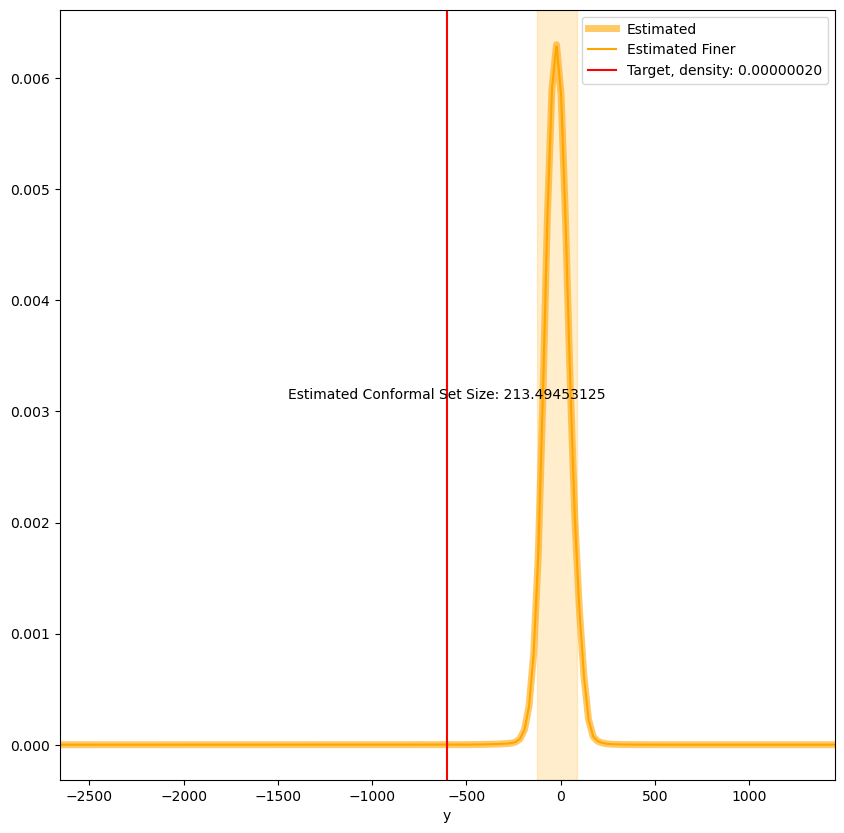

 94%|█████████▍| 79/84 [00:50<00:06,  1.28s/it]

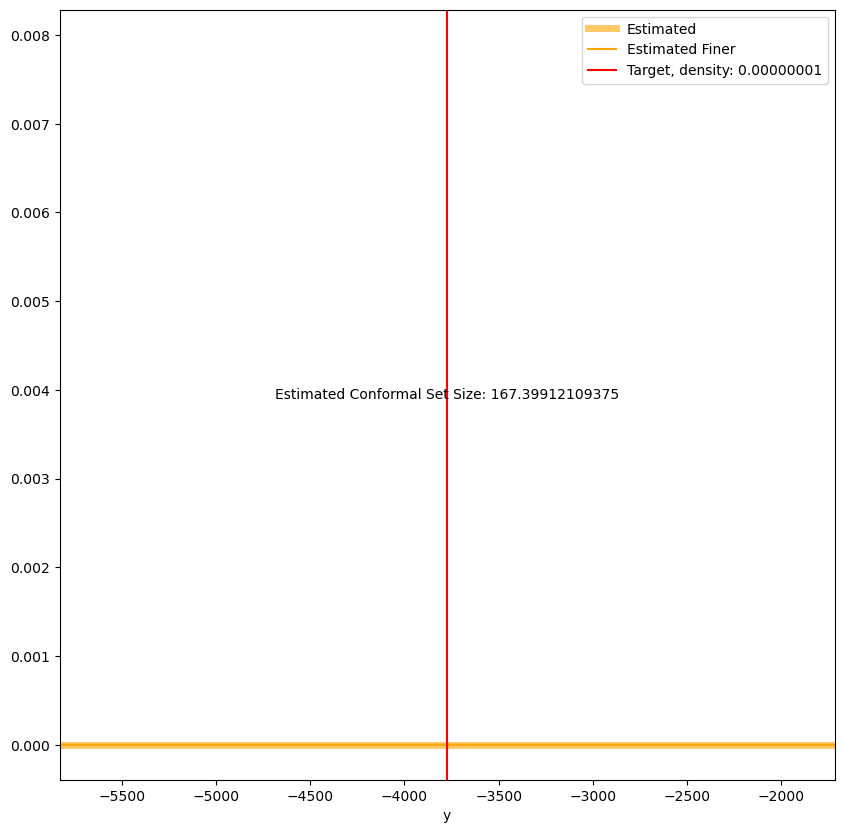

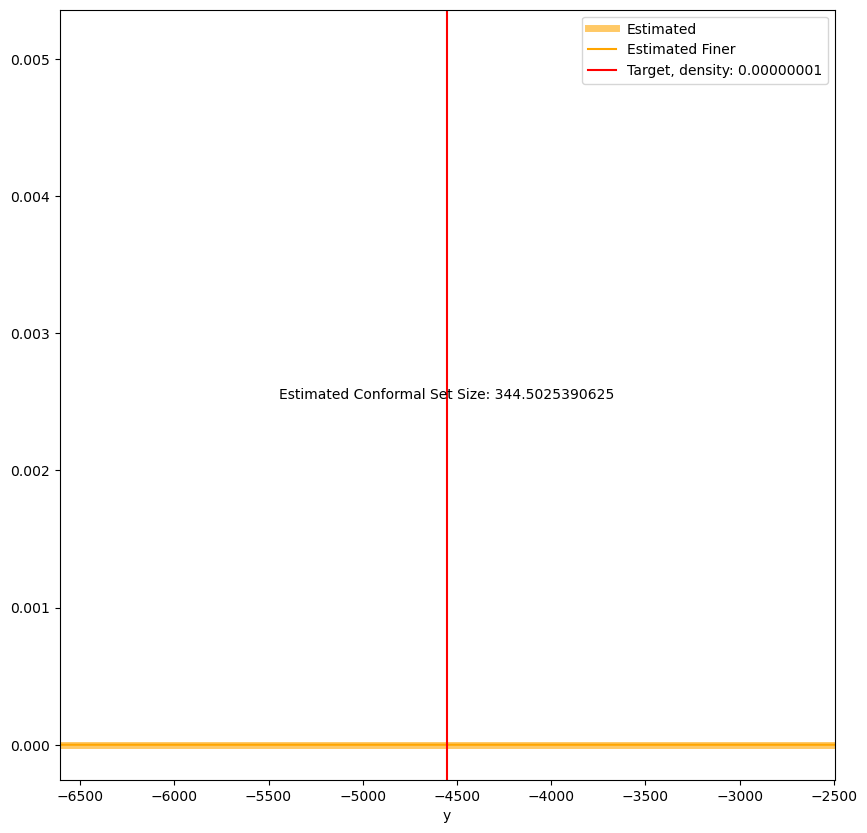

100%|██████████| 84/84 [00:52<00:00,  1.61it/s]


In [27]:
test_loader = dm.get_test_dataloader(64, shuffle=False)
model.eval()

target_std = dm.train_dataset.std_y

if has_true_distribution:
    y_space = training_dm.y_space
    y_space = torch.tensor(y_space, device=device).view(-1, 1)
else:
    y_space = torch.linspace((dm.train_dataset.y.min() - dm.train_dataset.std_y).item(), (dm.train_dataset.y.max() + dm.train_dataset.std_y).item(), 1028).to(device).view(-1, 1)

num_steps = y_space.shape[0]
step_size = (y_space[1] - y_space[0]).abs()

estimated_conformal_set_sizes = []
target_in_conformal_set = []

for batch in tqdm(test_loader):


    if has_true_distribution:
        x_batch, y, densities = batch
    else:
        x_batch, y = batch

    precomputed_variables = model(x_batch.to(device), y.to(device))

    for idx in range(x_batch.shape[0]):
        x_space = x_batch[idx].unsqueeze(0).expand(num_steps, -1)

        if precomputed_variables:
            to_pass_precomputed_variables = make_to_pass_precomputed_variables(
                precomputed_variables, num_steps, idx
            )
            estimated_densities = model.get_density(
                x_space, y_space, False, **to_pass_precomputed_variables
            )
        else:
            estimated_densities = model.get_density(x_space, y_space, False)

        y_space_np = y_space.flatten().cpu().detach().numpy()
        y_space_fine = torch.linspace(
            y_space_np.min(), y_space_np.max(), num_steps * finer_factor
        )
        true_y_density_idx = (y_space_fine - y[idx]).abs().argmin().item()


        # conformal set true
        if has_true_distribution:
            densities_np = densities[idx].cpu().detach().numpy()
            interp = interp1d(y_space_np, densities_np, kind="linear")

            densities_fine = torch.from_numpy(interp(y_space_fine.numpy()))

            densities_fine_normalized = densities_fine / densities_fine.sum()
            sorted_indices = torch.argsort(densities_fine_normalized, descending=True)
            cumulative_sum = torch.cumsum(densities_fine_normalized[sorted_indices], dim=0)
            conformal_set = sorted_indices[cumulative_sum < conformal_p]

            sorted_conformal_set = torch.sort(conformal_set)[0]
            diff = sorted_conformal_set[1:] - sorted_conformal_set[:-1]
            breaks = torch.where(diff != 1)[0] + 1
            breaks = torch.cat(
                (torch.tensor([0]), breaks, torch.tensor([len(sorted_conformal_set)]))
            )

            starts = sorted_conformal_set[breaks[:-1]]
            ends = sorted_conformal_set[breaks[1:] - 1]

            conformal_set_size = len(conformal_set) * step_size.item() / finer_factor

        # conformal set estimated
        estimated_densities_np = estimated_densities.cpu().detach().numpy()
        interp = interp1d(y_space_np, estimated_densities_np, kind="linear")
        estimated_densities_fine = torch.from_numpy(interp(y_space_fine.numpy()))
        true_y_density = estimated_densities_fine[true_y_density_idx].item()

        estimated_densities_fine_normalized = (
            estimated_densities_fine / estimated_densities_fine.sum()
        )
        sorted_indices = torch.argsort(estimated_densities_fine_normalized, descending=True)
        cumulative_sum = torch.cumsum(
            estimated_densities_fine_normalized[sorted_indices], dim=0
        )
        estimated_conformal_set = sorted_indices[cumulative_sum < conformal_p]

        sorted_conformal_set = torch.sort(estimated_conformal_set)[0]
        diff = sorted_conformal_set[1:] - sorted_conformal_set[:-1]
        breaks = torch.where(diff != 1)[0] + 1
        breaks = torch.cat(
            (torch.tensor([0]), breaks, torch.tensor([len(sorted_conformal_set)]))
        )

        estimated_starts = sorted_conformal_set[breaks[:-1]]
        estimated_ends = sorted_conformal_set[breaks[1:] - 1]

        append_target_in_conformal_set = False
        for start, end in zip(y_space_fine[estimated_starts], y_space_fine[estimated_ends]):
            if start <= y[idx].flatten().item() <= end:
                append_target_in_conformal_set = True
                break
        target_in_conformal_set.append(append_target_in_conformal_set)

        estimated_conformal_set_size = len(estimated_conformal_set) * step_size.item() / finer_factor
        estimated_conformal_set_sizes.append(estimated_conformal_set_size)
        
        if draw_plot or len(estimated_starts) > 1 or abs(y[idx].flatten().item()) > 500:
            plt.figure(figsize=(10, 10))
            plt.plot(
                y_space_np,
                estimated_densities_np,
                label="Estimated",
                lw=5,
                alpha=0.6,
                c="orange",
            )
            plt.plot(
                y_space_fine, estimated_densities_fine, label="Estimated Finer", c="orange"
            )
            plt.axvline(y[idx].flatten().item(), c="red", label="Target, density: {:.8f}".format(true_y_density))
            if has_true_distribution:
                plt.plot(y_space_np, densities_np, label="True", lw=5, alpha=0.6, c="green")
                plt.plot(y_space_fine, densities_fine, label="True Finer", c="green")
                for start, end in zip(y_space_fine[starts], y_space_fine[ends]):
                    plt.axvspan(start, end, alpha=0.2, color="green")

            for start, end in zip(y_space_fine[estimated_starts], y_space_fine[estimated_ends]):
                plt.axvspan(start, end, alpha=0.2, color="orange")

            if has_true_distribution:
                plt.text(
                    0.5,
                    0.5,
                    f"True Conformal Set Size: {conformal_set_size}\nEstimated Conformal Set Size: {estimated_conformal_set_size}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=plt.gca().transAxes,
                )
            else:
                plt.text(
                    0.5,
                    0.5,
                    f"Estimated Conformal Set Size: {estimated_conformal_set_size}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=plt.gca().transAxes,
                )
            plt.legend()
            plt.xlabel("y")
            plt.xlim(y[idx].flatten().item() - 5 * target_std, y[idx].flatten().item() + 5 * target_std)
            plt.show()
    if only_one_batch:
        break

In [28]:
print("Coverage Original Scale", np.mean(estimated_conformal_set_sizes), np.mean(target_in_conformal_set))
print("Coverage Standardized", np.mean(estimated_conformal_set_sizes) / target_std.item(), np.mean(target_in_conformal_set))

Coverage Original Scale 185.1584914104777 0.9473782422093674
Coverage Standardized 0.45030976951061047 0.9473782422093674
